In [3]:
cuda_lib_path = "/usr/local/cuda-10.2/targets/x86_64-linux/lib:/home/brovoletto/SerotoninSNN/nvcc_installation/nvcc_folder/targets/x86_64-linux/lib"
os.environ["LD_LIBRARY_PATH"] = cuda_lib_path + ":" + os.environ.get("LD_LIBRARY_PATH", "")

LD_LIBRARY_PATH: /usr/local/cuda-10.2/targets/x86_64-linux/lib:/home/brovoletto/SerotoninSNN/nvcc_installation/nvcc_folder/targets/x86_64-linux/lib::


A
Bottom-up:  5 5 5
synapses s1
synapses_1 s2
C
Top-down:  4 5 5
synapses_2 s5
synapses_3 s6
D
Top-down-2:  4 5 5
synapses_4 s7
synapses_5 s8
A
Bottom-up:  4 4 4
synapses_6 s1
synapses_7 s2
B
Bottom-up-2:  4 4 4
synapses_8 s3
synapses_9 s4
C
Top-down:  3 4 4
synapses_10 s5
synapses_11 s6
D
Top-down-2:  3 4 4
synapses_12 s7
synapses_13 s8
A
Bottom-up:  3 3 3
synapses_14 s1
synapses_15 s2
B
Bottom-up-2:  3 3 3
synapses_16 s3
synapses_17 s4
C
Top-down:  2 3 3
synapses_18 s5
synapses_19 s6
D
Top-down-2:  2 3 3
synapses_20 s7
synapses_21 s8
synapses_22 s9
synapses_23 s10
synapses_24 s11
synapses_25 s12
fgh
spikemonitor
spikemonitor_1
spikemonitor_10
spikemonitor_11
spikemonitor_2
spikemonitor_3
spikemonitor_4
spikemonitor_5
spikemonitor_6
spikemonitor_7
spikemonitor_8
spikemonitor_9
NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_11')


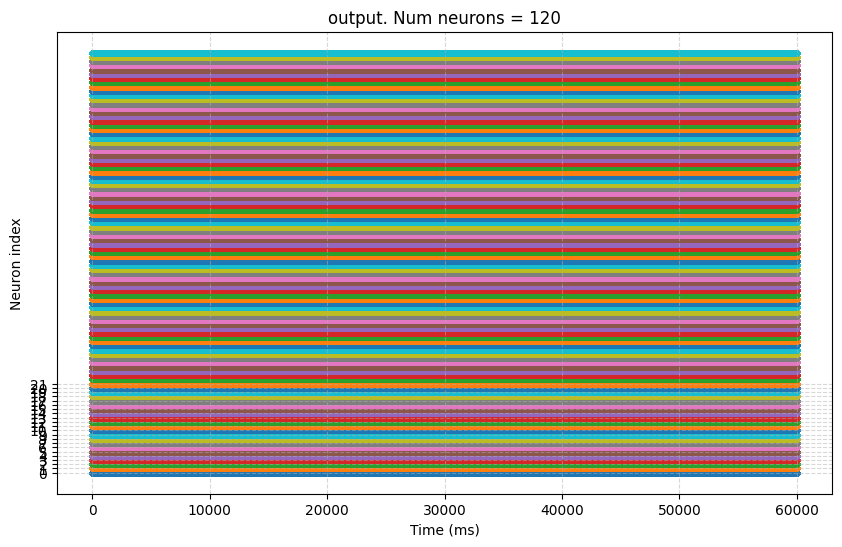

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_10')


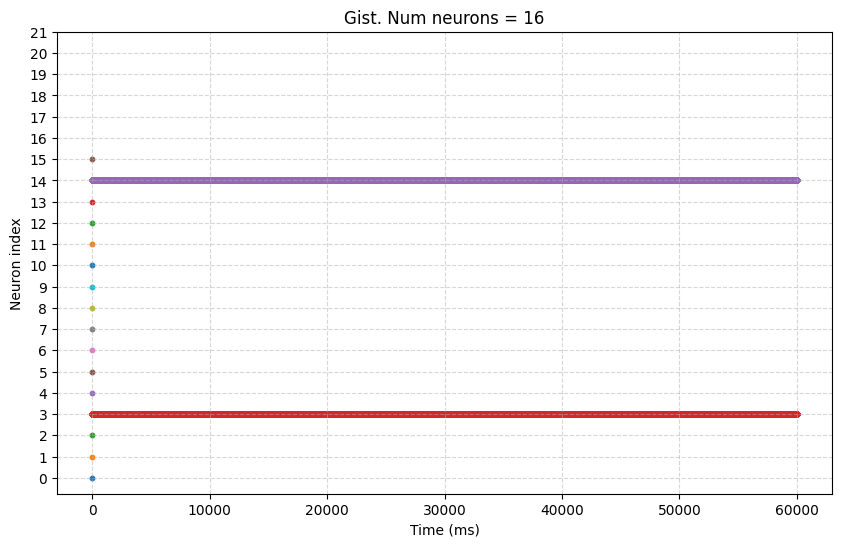

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_6')


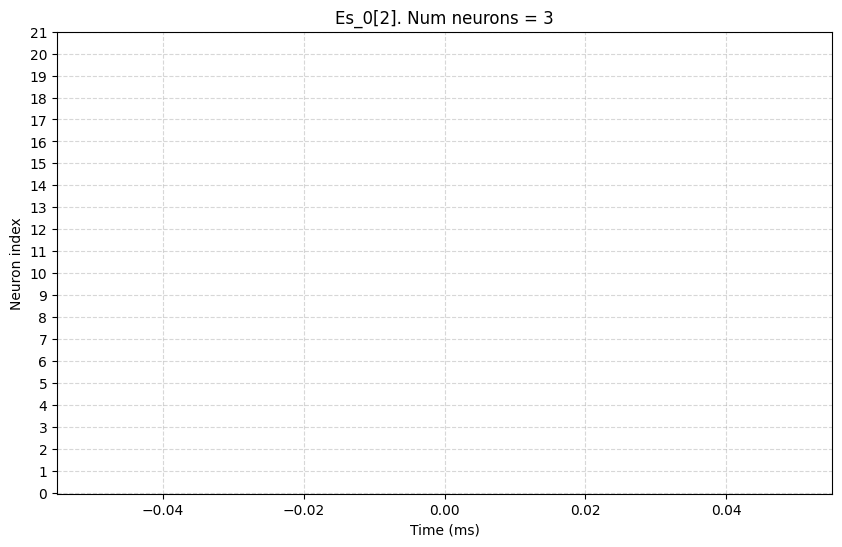

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_9')


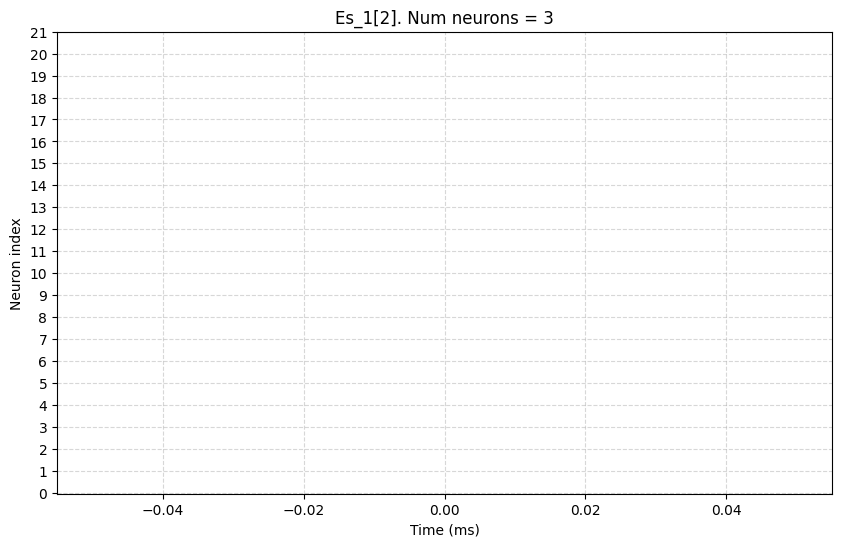

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')


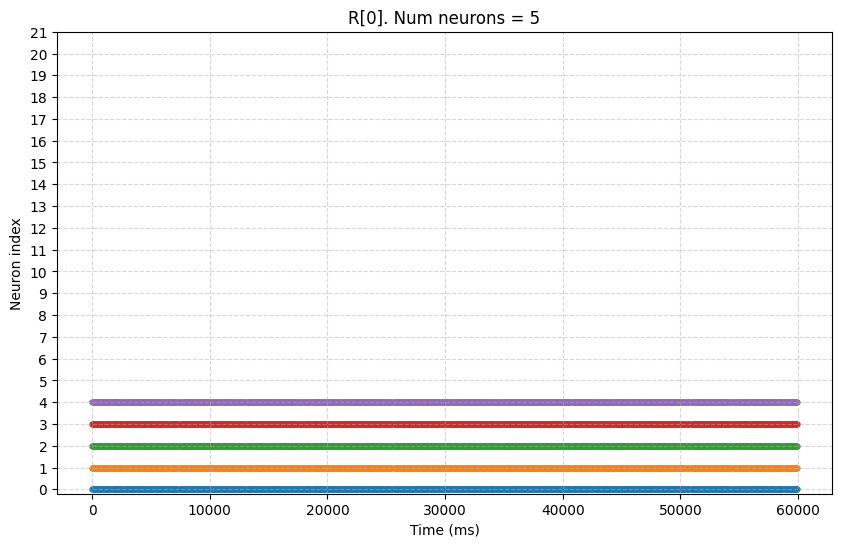

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')


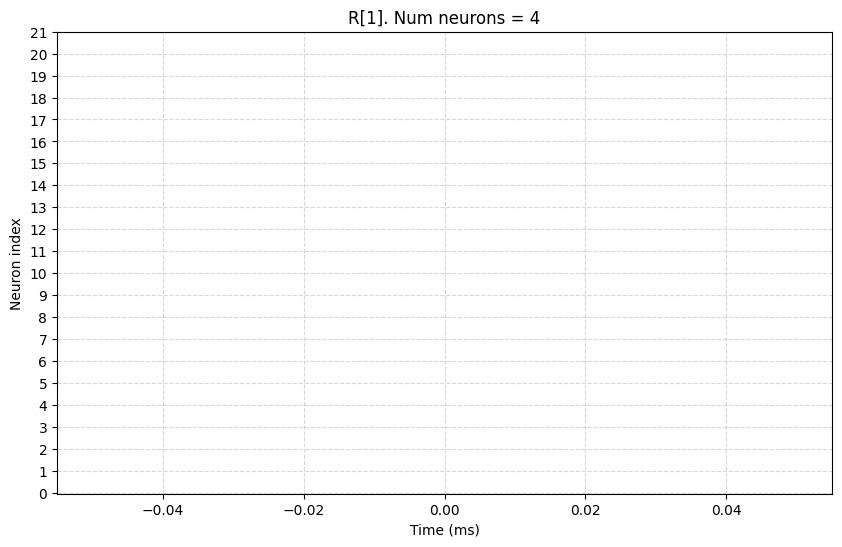

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_4')


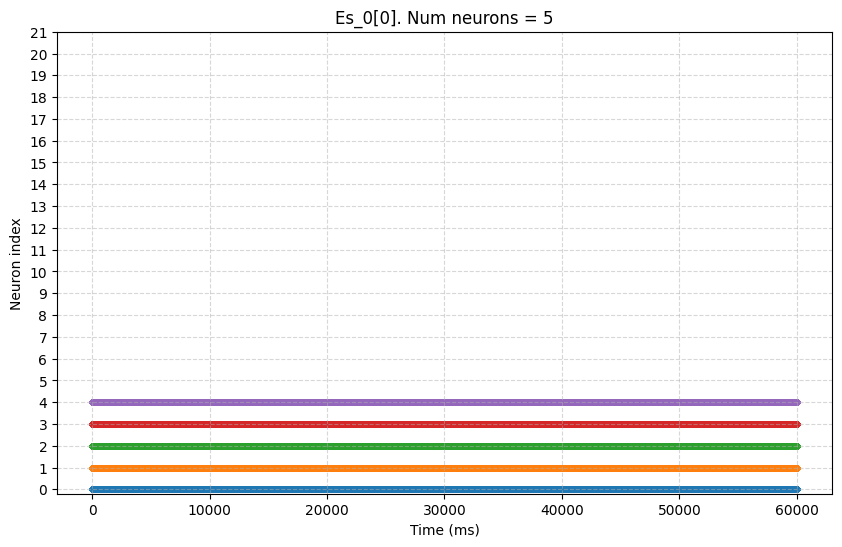

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_7')


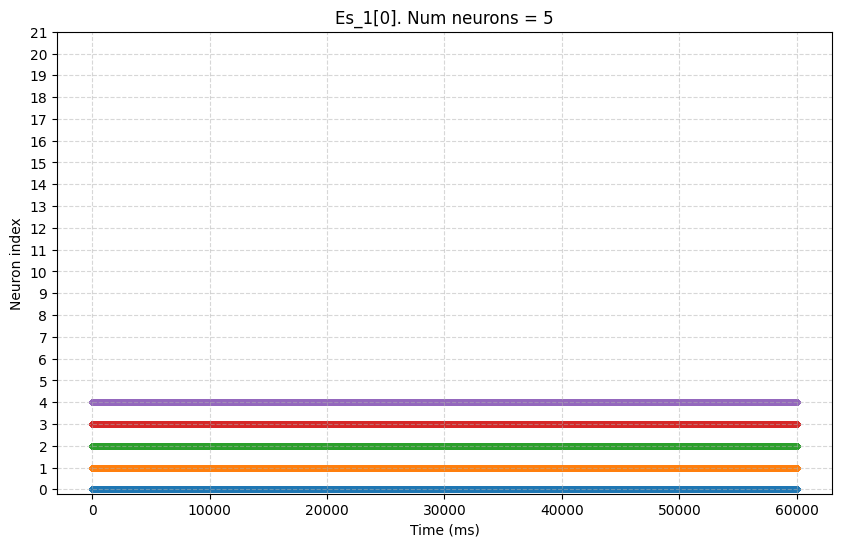

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')


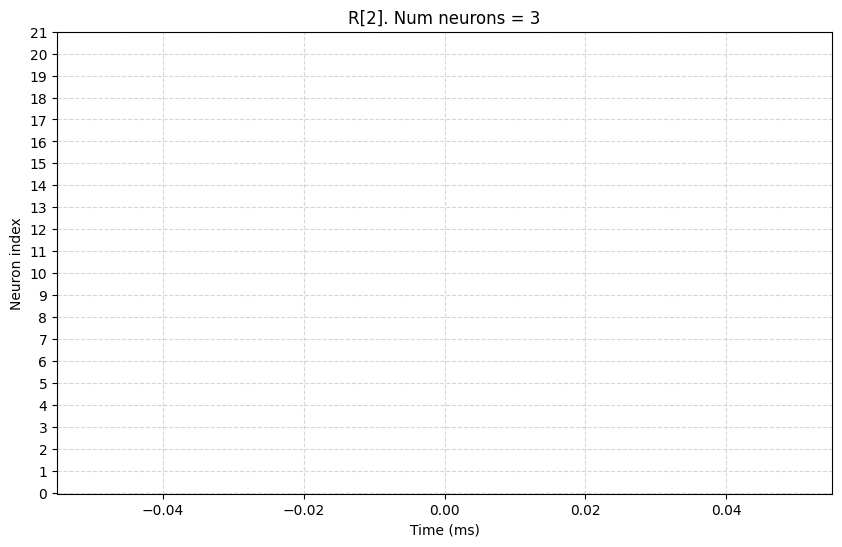

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_5')


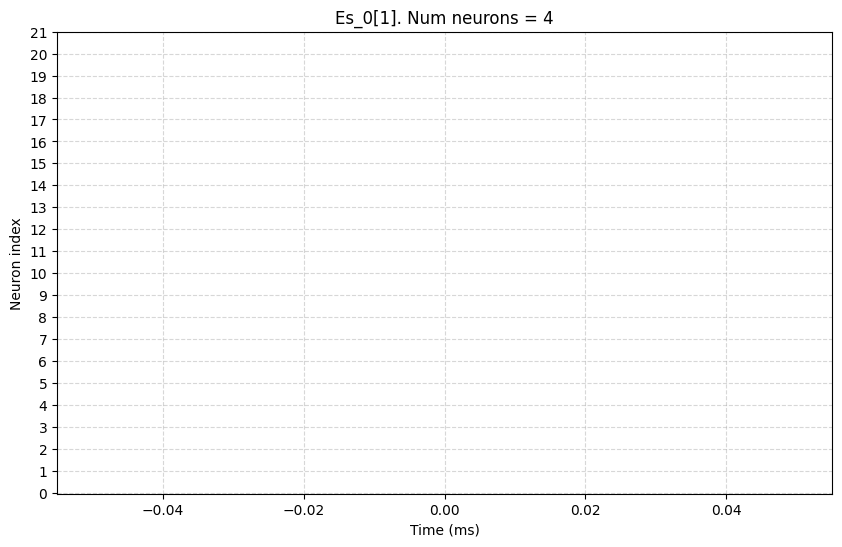

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_8')


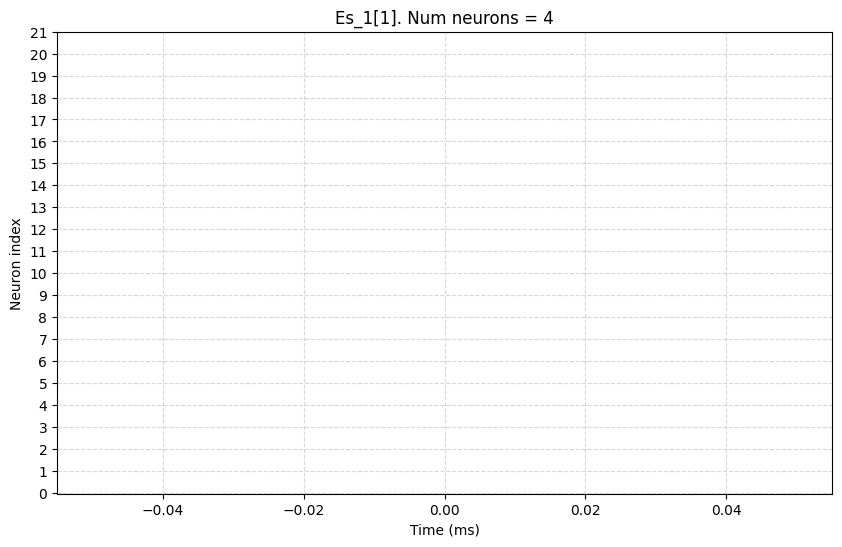

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_3')


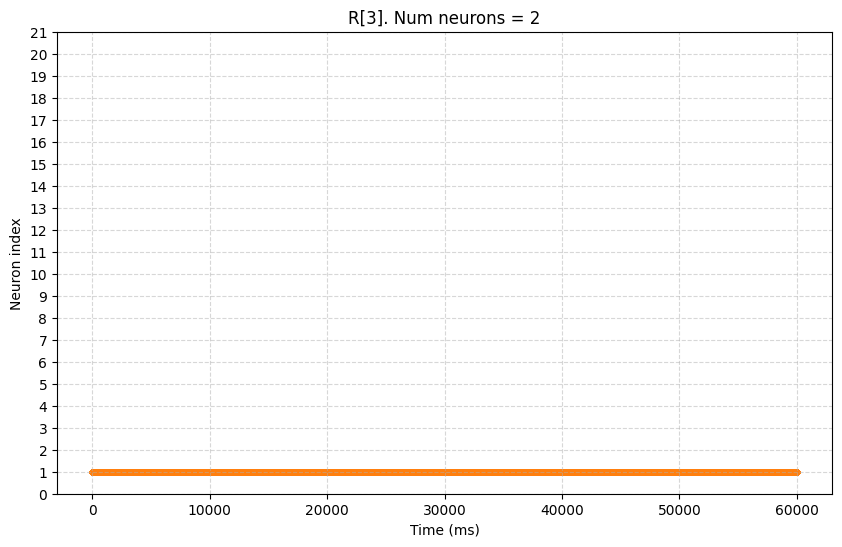

In [ ]:

import os

import time
import torch
import datetime
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils




from brian2 import prefs
#from brian2 import set_device
from brian2.devices import device_module

import brian2cuda
from brian2cuda import *

set_device("cpp_standalone", directory='project', build_on_run=False)

device = b2.get_device()


#set_device("cuda_standalone", build_on_run=True)
# Set specific preferences for CUDA standalone


prefs.devices.cuda_standalone.cuda_backend.cuda_runtime_version = (12.2)
prefs.devices.cuda_standalone.profile_statemonitor_copy_to_host = None
prefs.devices.cuda_standalone.cuda_backend.extra_compile_args_nvcc = ['-use_fast_math', '-w']
prefs.devices.cuda_standalone.cuda_backend.detect_gpus = True
prefs.devices.cuda_standalone.cuda_backend.gpu_id = 0  # Use the first GPU
# prefs.devices.cuda_standalone.cuda_backend.cuda_path = '/home/brovoletto/SerotoninSNN/nvcc_installation/nvcc_folder'



# REMEMBER YOU SWITCHED SOME EXCITATORY WITH INHIBITORY!!!!!!!!


###############################################################################
# Model Parameters and Equations
###############################################################################
msec_step = 100 * ms

# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# TODO: Make weights always non-negative! (maybe not necessary)
# Equations for everything. I_post in the synapse is modifying I in the target neuron




# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.1   # Initial synaptic weight (conductance)

regularizer = 1 * nS


# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : 1    # Spike trace
dY/dt = -Y / tau_decay : 1  # Glutamate decay
Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : 1   # Accumulate X values over a batch

'''
# Ii = I + input_stimuli(t)  :  amp  # Input current


input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : 1    # Spike trace
dY/dt = -Y / tau_decay : 1  # Glutamate decay
I = input_stimuli(t, indices) : amp
indices : integer
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : 1    # Spike trace
dY/dt = -Y / tau_decay : 1  # Glutamate decay
Iexc : amp  # Synaptic input
Iexc_internal : amp  # Synaptic input
I_tot = Iexc + Iexc_internal + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
spike_count = 0 : integer
batch_sum_X : 1
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
w : 1   # Synaptic weight, conductance

Iexc_post = w * X  : amp (summed)
'''

syn_eqs_exc_2 = '''
w : 1   # Synaptic weight, conductance

Iexc_2_post = w * X  : amp (summed)
'''

syn_eqs_exc_3 = '''
w : 1

Iexc_3_post = w * X  : amp (summed)
'''

syn_eqs_exc_4 = '''
w : 1

Iexc_4_post = w * X  : amp (summed)
'''


syn_eqs_exc_output = '''
w : 1   # Synaptic weight, conductance

Iexc_internal_post = w * X   : amp (summed)
'''



syn_eqs_inh= '''
w : 1   # Synaptic weight, conductance

Iinh_post = w * X   : amp (summed)
'''

syn_eqs_inh_2= '''
w : 1   # Synaptic weight, conductance

Iinh_2_post = w * X   : amp (summed)
'''

syn_eqs_inh_3= '''
w : 1   # Synaptic weight, conductance

Iinh_3_post = w * X   : amp (summed)
'''

syn_eqs_inh_4= '''
w : 1   # Synaptic weight, conductance

Iinh_4_post = w * X   : amp (summed)
'''






###############################################################################
# Helper Functions
###############################################################################
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for i, dim in enumerate(dims):
        if i == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups


class NamedSynapses(Synapses):
    def __init__(self, source, target=None, model=None, custom_name=None, **kwargs):
        super().__init__(source, target, model, **kwargs)
        
        self.add_attribute("brian2_name")
        self.add_attribute("custom_name")
        
        self.brian2_name = self.name  
        
        self.custom_name = custom_name or f"{source}-{target}"
        
        print(self.brian2_name, self.custom_name)
        
    def connect(self, **kwargs):
        # Call the original connect method
        super().connect(**kwargs)
        if self.custom_name == "suygu5":
            # Print the connections
            connections = [(i, j) for i, j in zip(self.i[:], self.j[:])]
            print("Connections created:")
            for pre, post in connections:
                print(f"Pre: {pre}, Post: {post}")
            
        
        
class NamedSpikeMonitor(SpikeMonitor):
    def __init__(self, group, custom_name=None, **kwargs):
        super().__init__(group, **kwargs)
        self.add_attribute("custom_name")
        self.custom_name = custom_name or str(group)    
     
     
     
def manual_fully_connect(syn, N_pre, N_post):
    # Manually specify connections
    pre_indices = [i for i in range(N_pre) for _ in range(N_post)]
    post_indices = [j for _ in range(N_pre) for j in range(N_post)]

    # Connect manually
    syn.connect(i=pre_indices, j=post_indices) 
    
    return syn  
            

def make_bottom_up_connections(R, E_0, E_1):
    print("A")
    print("Bottom-up: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(R, E_0, model=syn_eqs_exc, on_pre='Y_post = 1', custom_name = "s1")
    S_p.connect(j='i')
    S_p.w = 'w_init'

    S_m = NamedSynapses(R, E_1, model=syn_eqs_inh, on_pre='Y_post = 1', custom_name = "s2")
    S_m.connect(j='i')
    S_m.w = 'w_init'

    return S_p, S_m

def make_bottom_up_connections_2(E_0, E_1,R):
    print("B")
    print("Bottom-up-2: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(E_0, R, model=syn_eqs_exc_2, on_pre='Y_post = 1', custom_name = "s3")
    S_p.connect(j='i')
    S_p.w = 'w_init'

    S_m = NamedSynapses(E_1, R,  model=syn_eqs_inh_2, on_pre='Y_post = 1', custom_name = "s4")
    S_m.connect(j='i')
    S_m.w = 'w_init'

    return S_p, S_m




def make_top_down_connections(R, E_0, E_1):
    print("C")
    print("Top-down: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(R, E_1, model=syn_eqs_exc_3, on_pre='Y_post = 1', custom_name = "s5")
    #S_p.connect()
    manual_fully_connect(S_p, R.N, E_1.N)
    S_p.w = 'rand() * w_init'

    S_m = NamedSynapses(R, E_0, model=syn_eqs_inh_3, on_pre='Y_post = 1', custom_name = "s6")
    #S_m.connect()
    manual_fully_connect(S_m, R.N, E_0.N)
    S_m.w = 'rand() * w_init'

    return S_p, S_m



def make_top_down_connections_2(E_0, E_1, R):
    print("D")
    print("Top-down-2: ", R.N, E_0.N, E_1.N )
    S_p_2 = NamedSynapses(E_1, R,  model=syn_eqs_exc_4, on_pre='Y_post = 1', custom_name = "s7")
    #S_p.connect()
    manual_fully_connect(S_p_2, E_1.N, R.N)
    S_p_2.w = 'rand() * w_init'

    S_m_2 = NamedSynapses(E_0, R,  model=syn_eqs_inh_4, on_pre='Y_post = 1', custom_name = "s8")
    #S_m.connect()
    manual_fully_connect(S_m_2, E_0.N, R.N)
    S_m_2.w = 'rand() * w_init'

    return S_p_2, S_m_2



def make_gist_connections(Rs, G):
    S_gist_input = NamedSynapses(Rs[0], G, model=syn_eqs_exc, on_pre='Y_post = 1', custom_name = "s9")
    S_gist_input.connect(p=0.05)
    S_gist_input.w = 'rand() * w_init'

    # Connect G to all other layers
    S_gist_output = NamedSynapses(G, Rs[-1], model=syn_eqs_exc, on_pre='Y= 1', custom_name = "s10")
    S_gist_output.connect(p=0.05)
    S_gist_output.w = 'rand() * w_init'
    return S_gist_input, S_gist_output



def make_output_layer(num_classes_per_layer, max_depth, w_out_init=None):
    if w_out_init is None:
        w_out_init = w_init/3000

    total_neurons = sum([num_classes_per_layer**(d+1) for d in range(max_depth)])
    Os = NeuronGroup(N=total_neurons, model=out_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    #S_o = NamedSynapses(Os, Os, model=syn_eqs_exc_output, on_pre='Y_post = 1')

    trace = 0
    for d in range(num_classes_per_layer - 1):
        new_trace = trace + num_classes_per_layer**(d+1)
        source_indices = list(range(trace, trace + num_classes_per_layer**(d+1)))
        target_indices = list(range(new_trace, new_trace + num_classes_per_layer**(d+2)))
        ii, jj = np.meshgrid(source_indices, target_indices, indexing='ij')
        #S_o.connect(i=ii.flatten(), j=jj.flatten())
        trace = new_trace

    # Assign indices for output stimuli
    stimulus_indices = []
    for i in range(max_depth):
        for _ in range(num_classes_per_layer**(i+1)):
            stimulus_indices.append(i)
    Os.indices = stimulus_indices

    return Os#, S_o






def make_network(dims, num_classes_per_layer, max_depth, w_out_init=None):
    max_depth += 1
    Rs = make_groups(dims, with_input=True)
    Es_0 = make_groups(dims[:-1])
    Es_1 = make_groups(dims[:-1])
    G = NeuronGroup(16, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    #Os, S_o_internal = make_output_layer(num_classes_per_layer, max_depth, w_out_init=w_out_init)
    Os = make_output_layer(num_classes_per_layer, max_depth, w_out_init=w_out_init)

    connections = {}
    for i in range(len(Rs)-1):
        S_p, S_m = make_bottom_up_connections(Rs[i], Es_0[i], Es_1[i])

        if i != 0:
            S_p_2, S_m_2 = make_bottom_up_connections_2(Es_0[i], Es_1[i], Rs[i])
            connections[f"bottom_up_2_{i}"] = [S_p_2, S_m_2]
        connections[f"bottom_up_{i}"] = [S_p, S_m]

        if i != len(Rs)-1:
            S_p_td, S_m_td = make_top_down_connections(Rs[i+1], Es_0[i], Es_1[i])
            S_p_td_2, S_m_td_2 = make_top_down_connections_2(Es_0[i], Es_1[i], Rs[i+1])
            connections[f"top_down{i}"] = [S_p_td, S_m_td]
            connections[f"top_down_2_{i}"] = [S_p_td_2, S_m_td_2]

    S_gist_input, S_gist_output = make_gist_connections(Rs, G)
    connections["gist_input"] = [S_gist_input]
    connections["gist_output"] = [S_gist_output]

    # External output connections
    # In original code: attempted to connect Rs[-1] to Os
    # We'll do a single large synapse group for simplicity:
    S_o_external = NamedSynapses(Rs[-1], Os, model=syn_eqs_exc, on_pre='Y_post = 1', custom_name = "s11")
    S_o_external_2 = NamedSynapses(Os, Rs[-1],  model=syn_eqs_exc_2, on_pre='Y_post = 1', custom_name = "s12")
    S_o_external.connect()
    S_o_external.w = 'rand() * w_init'
    S_o_external_2.connect()
    S_o_external_2.w = 'rand() * w_init'
    connections["output_external"] = [S_o_external]
    connections["output_external_2"] = [S_o_external_2]

  
    # return Rs, Es_0, Es_1, G, Os, S_o_internal, connections
    
    return Rs, Es_0, Es_1, G, Os,  connections




def normalize_tensor(tensor, old_min, old_max, new_min, new_max):
    normalized_tensor = (tensor - old_min) / (old_max - old_min)
    scaled_tensor = normalized_tensor * (new_max - new_min) + new_min
    return scaled_tensor




def normalize_and_unwrap_dataset(dt, minval, maxval):
    minimum = 0
    maximum = 0
    all_curves = [torch.tensor(curve, dtype=torch.float64) for curve in chain.from_iterable(dt["curves"].values())]
    for curve in all_curves:
        _min = torch.min(curve)
        _max = torch.max(curve)
        if (minimum > _min): minimum = _min
        if (maximum < _max): maximum = _max

    unwrapped = []
    for key in dt["categories"].keys():
        for curve in dt["curves"][key]:
            unwrapped.append((torch.tensor(key), normalize_tensor(torch.tensor(curve), minimum, maximum, minval, maxval)))
    return unwrapped



def get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer):
    if labels.ndim == 1:
        labels = labels.unsqueeze(0)

    indexes = torch.zeros_like(labels)
    for i in range(labels.shape[1]):
        summed = 0
        if i > 0:
            summed = torch.stack([labels[:, j]*num_classes_per_layer**(i-j) for j in range(i)]).sum(dim=0)
        indexes[:, i] = summed + labels[:, i]

    # Adjust indexes for concatenation
    to_sum = 0
    for i in range(labels.shape[1]):
        if i > 0:
            to_sum += num_classes_per_layer**i
        indexes[:, i] = indexes[:, i] + to_sum
    return indexes

def get_output_current_arrays(I_indexes, dim, I_value):
    if I_indexes.ndim == 1:
        I_indexes = I_indexes.unsqueeze(0)

    out = torch.zeros((I_indexes.shape[0], dim), dtype=torch.float32)
    row_indices = torch.arange(I_indexes.shape[0]).repeat_interleave(I_indexes.shape[1])
    col_indices = I_indexes.flatten()
    out[row_indices, col_indices] = I_value
    return out

class CurveDataset(Dataset):
    def __init__(self, data, minval, maxval):
        self.data = normalize_and_unwrap_dataset(data, minval, maxval)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels, curves = self.data[idx]
        return labels, curves.flatten()

def collate_fn(batch, msec_step, num_pause_blocks, num_classes_per_layer, out_dim):
    labels, curves = zip(*batch)
    labels = torch.stack(labels, dim=0)
    curves = torch.stack(curves, dim=0)

    pause = torch.zeros_like(curves[0])
    pause_block = torch.tile(pause, (num_pause_blocks, 1))
    curves_with_pause = torch.vstack([torch.vstack((row, pause_block)) for row in curves])
    visual_stimulus = TimedArray(curves_with_pause.numpy() * nA, dt=msec_step)

    stimulus_indexes = TimedArray(np.tile([1] + [0] * num_pause_blocks, curves.size(0)), dt=msec_step)

    out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer)
    out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
    label_pause = torch.zeros(out_dim)
    label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1))
    out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])
    output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * nA, dt=msec_step)

    return stimulus_indexes, output_stimuli, visual_stimulus

###############################################################################
# Build the network and run
###############################################################################
#dims = [22*22, 250, 125, 64]
dims = [5, 4, 3, 2]
num_classes_per_layer = 3
max_depth = 3

# Rs, Es_0, Es_1, G, Os, S_o_internal, connections = make_network(dims, num_classes_per_layer, max_depth)
Rs, Es_0, Es_1, G, Os, connections = make_network(dims, num_classes_per_layer, max_depth)

Rs[0].indices = range(Rs[0].N)

su = Synthetic_Dataset_Utils()
ranges = [30, 30, 30, 30]
prior_params = [10, 10, 10, 10]
num_samples_per_class = 500
N = 22
tree = su.build_tree(prior_params, 0, max_depth, num_classes_per_layer, 1, ranges)
synth_dataset = su.make_dataset(tree, num_classes_per_layer, num_samples_per_class=num_samples_per_class, N=N)

output_dim = Os.N
lr = 0.03
batch_size = 300
num_pause_blocks = 1

dataset = CurveDataset(synth_dataset, 0.6, 1.5)
dl = DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=partial(
        collate_fn,
        msec_step=msec_step,
        num_pause_blocks=num_pause_blocks,
        num_classes_per_layer=num_classes_per_layer,
        out_dim=output_dim
    )
)



torch.save(dataset, "data/dataset1.pt")

#dataset = torch.load("data/dataset1.pt")




@network_operation()
def debug():
    print("Rs[0].I: ", Rs[0].I[:])
    
    
def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation
    
    
@network_operation()
def update_sums():
    current_idx = int(defaultclock.t / msec_step)
    if stimulus_indexes.values[current_idx] == 1:
        for n in range(len(Rs)-1):
            if n > 0:
                Rs[n+1].batch_sum_X += Rs[n+1].X
            Es_0[n].batch_sum_X += Es_0[n].X
            Es_1[n].batch_sum_X += Es_1[n].X
            
    Os.batch_sum_X += Os.X
            


def if_positive(x, w):
    # Return x where w > 0, otherwise 0 (element-wise)
    return np.where(w > 0, x, 0)
    
    
@network_operation()
def apply_weight_update():
    print("Applying weight update")
    for n in range(len(Rs)-1):
        
        print("n: ", n)
        
        # Retrieve top_down synapses       
        S_p, S_m = connections[f"top_down_{n}"]
        S_p_2, S_m_2 = connections[f"top_down_2_{n}"]
        
        
        
        
            
        for j_idx in range(Es_0[n].N):
            for i_idx in range(Rs[n+1].N):
                
                positive_connections_delta = lr * Es_0[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx] - if_positive(regularizer, S_p.w[i_idx, j_idx])
                negative_connections_delta = lr * Es_1[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx] - if_positive(regularizer, S_m.w[i_idx, j_idx])
                
                S_p.w[i_idx, j_idx] += positive_connections_delta
                S_m.w[i_idx, j_idx] -= negative_connections_delta
                
                S_p_2.w[i_idx, j_idx] += positive_connections_delta
                S_m_2.w[i_idx, j_idx] -= negative_connections_delta
                
     
            # Reset after update
            Rs[n+1].batch_sum_X[:] = 0
            Es_0[n].batch_sum_X[:] = 0
            Es_1[n].batch_sum_X[:] = 0
    
    
    
    external_syn = connections["output_external"][0]
    external_syn_2 = connections["output_external_2"][0]
    
    for i_idx in range(Rs[-1].N):
        for j_idx in range(Os.N):
            
            delta = lr * Rs[-1].batch_sum_X[i_idx] * Os.batch_sum_X[j_idx] * siemens
            external_syn.w[i_idx, j_idx] += delta
            external_syn_2.w[i_idx, j_idx] += delta
            
            
    Rs[-1].batch_sum_X[:] = 0
    Os.batch_sum_X[:] = 0
        
            
            
     
# Extract all synapses and objects for the network
all_synapses = []
# all_synapses.append(S_o_internal)

for i in range(len(Rs)-1):
    bu_syns = connections[f"bottom_up_{i}"]
    all_synapses.extend(bu_syns)
    td_key = f"top_down_{i}"
    if td_key in connections:
        td_syns = connections[td_key]
        all_synapses.extend(td_syns)

for i in range(1,len(Rs)-1):
    bu_syns = connections[f"bottom_up_2_{i}"]
    all_synapses.extend(bu_syns)
    td_key = f"top_down_2_{i}"
    if td_key in connections:
        td_syns = connections[td_key]
        all_synapses.extend(td_syns)

gist_input_syn = connections["gist_input"][0]
gist_output_syn = connections["gist_output"][0]
all_synapses.append(gist_input_syn)
all_synapses.append(gist_output_syn)

external_syn = connections["output_external"][0]
external_syn_2 = connections["output_external_2"][0]
all_synapses.append(external_syn)

#monitor = StateMonitor(Rs[0], ['v', 'I'], record=[0])
#spike_monitor = SpikeMonitor(Rs[0])

s = 0

        



monitor_o = StateMonitor(Os, ['v', 'I_tot', 'X'], record=True)
spike_mon_o = NamedSpikeMonitor(Os, record = True, custom_name = "output")

'''
net = Network(
    Rs, Es_0, Es_1, G, Os,
    all_synapses,        
    monitor_o, spike_mon_o,         # <-- Add these
    debug, update_sums, apply_weight_update
)
'''

# Add spike monitors for all neuron groups

spike_mon_G = NamedSpikeMonitor(G, record=True, custom_name = "Gist")

try:
    if net in globals():
        print("asd")
        ddebug = "asd"
        pass
except:
    # Add all monitors to the network
    print("fgh")
    ddebug = "fgh"
    net = Network(
        Rs, Es_0, Es_1, G, Os,  # Neuron groups       
        monitor_o, spike_mon_o, # Output monitors
        spike_mon_G,  # Spike monitors
        debug, update_sums, apply_weight_update  # Additional operations
    )

for i in range(len(Rs)):
    net.add(NamedSpikeMonitor(Rs[i], record=True, custom_name = f"R[{i}]"))
    if i > 0:
        net.add(NamedSpikeMonitor(Es_0[i-1], record=True, custom_name = f"Es_0[{i-1}]"))
        net.add(NamedSpikeMonitor(Es_1[i-1], record=True, custom_name = f"Es_1[{i-1}]"))

for synapse in all_synapses:
    net.add(synapse)

all_batch_rates = []
output_spikes = []

s = 0
stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))
net.stimulus_indexes = stimulus_indexes
net.output_stimuli   = output_stimuli
net.input_stimuli    = input_stimuli



run_time = (batch_size + batch_size*num_pause_blocks)*100*ms
net.run(run_time)
result_dir = f'results_v2'
device.build(run=True, directory="project_v2",results_directory=result_dir) 

# device.build(directory='project', run = False)

states = net.get_states()

keys = []
for key in states.keys():
    if "spike" in key:
        keys.append(key)
        print(key)
        
for key in keys:
    spike_mon_o = net[key]
    spikes = spike_mon_o.spike_trains()
    # Plotting the spike train with dots
    plt.figure(figsize=(10, 6))
    i=0
    old = 0
    for neuron, spike_times in spikes.items():
    
        old = spike_times
        
        if i < 100:
            plt.scatter(spike_times/ms, [neuron] * len(spike_times), s=10, label=f'Neuron {neuron}' if neuron == 0 else "")
            i+=1

    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.title(f'{spike_mon_o.custom_name}. Num neurons = {len(spikes.items())}')
    print(spike_mon_o.source)
    plt.yticks(range(N))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    
    '''# Add spike monitors for all neuron groups
spike_mon_Rs = [SpikeMonitor(group, record=True) for group in Rs]
spike_mon_Es_0 = [SpikeMonitor(group, record=True) for group in Es_0]
spike_mon_Es_1 = [SpikeMonitor(group, record=True) for group in Es_1]
spike_mon_G = SpikeMonitor(G, record=True)


# Add all monitors to the network
net = Network(
    Rs, Es_0, Es_1, G, Os,  # Neuron groups
    all_synapses,           # Synapses
    monitor_o, spike_mon_o, # Output monitors
    spike_mon_Rs, spike_mon_Es_0, spike_mon_Es_1, spike_mon_G,  # Spike monitors
    debug, update_sums, apply_weight_update  # Additional operations
)
'''

A
Bottom-up:  10 10 10
synapses s1
synapses_1 s2
C
Top-down:  10 10 10
synapses_2 s5
synapses_3 s6
D
Top-down-2:  10 10 10
synapses_4 s7
synapses_5 s8
A
Bottom-up:  10 10 10
synapses_6 s1
synapses_7 s2
B
Bottom-up-2:  10 10 10
synapses_8 s3
synapses_9 s4
C
Top-down:  10 10 10
synapses_10 s5
synapses_11 s6
D
Top-down-2:  10 10 10
synapses_12 s7
synapses_13 s8
synapses_14 s9
synapses_15 s10
synapses_16 s11
synapses_17 s12


WARNING    'i' is an internal variable of group 'neurongroup_8', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO:root:creating /tmp/brian_flag_test_jrpx6wlv/tmp/brian_flag_test_jrpx6wlv
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/brian_flag_test_jrpx6wlv/flag_test.cpp -o /tmp/brian_flag_test_jrpx6wlv/tmp/brian_flag_test_jrpx6wlv/flag_test.o -w
INFO:root:creating /tmp/brian_flag_test_wy78gp2w/tmp/brian_flag_test_wy78gp2w
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-stron

spikemonitor
spikemonitor_1
spikemonitor_2
spikemonitor_3
spikemonitor_4
spikemonitor_5
spikemonitor_6
spikemonitor_7
spikemonitor_8
spikemonitor_9
NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_8')


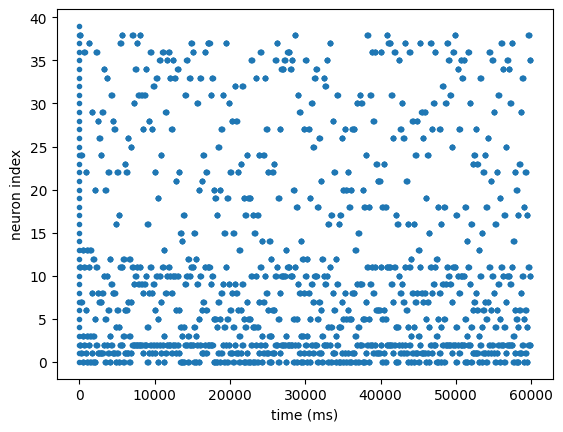

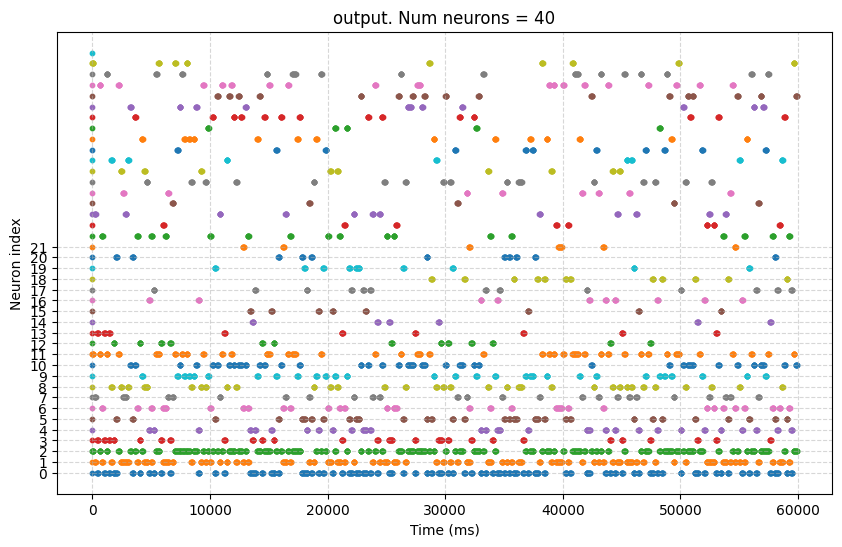

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_7')


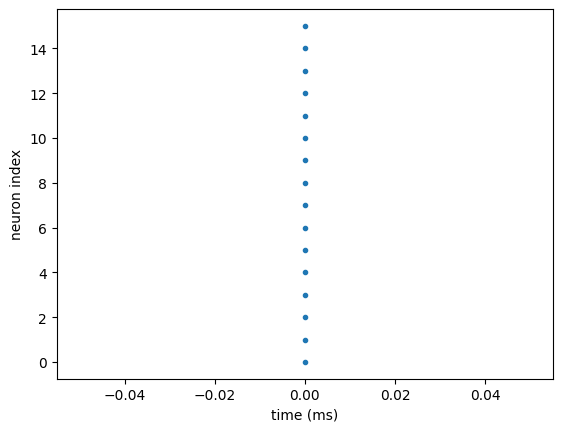

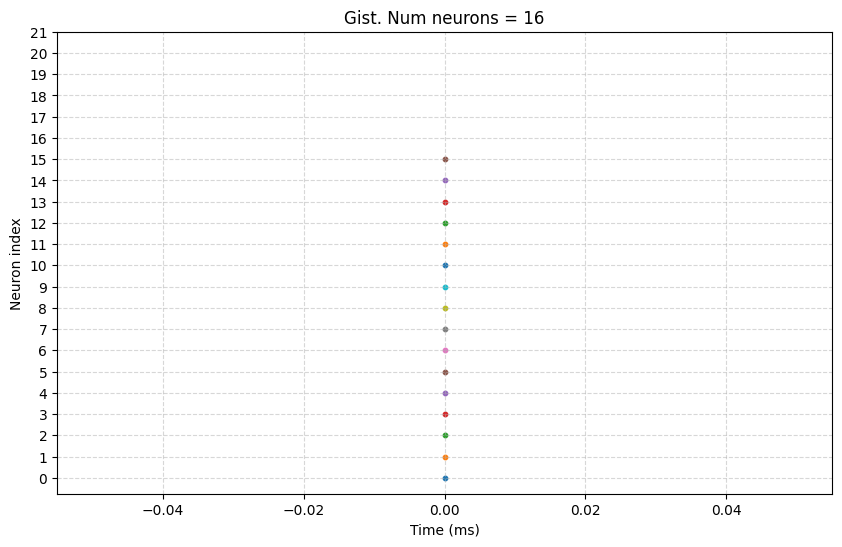

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_4')


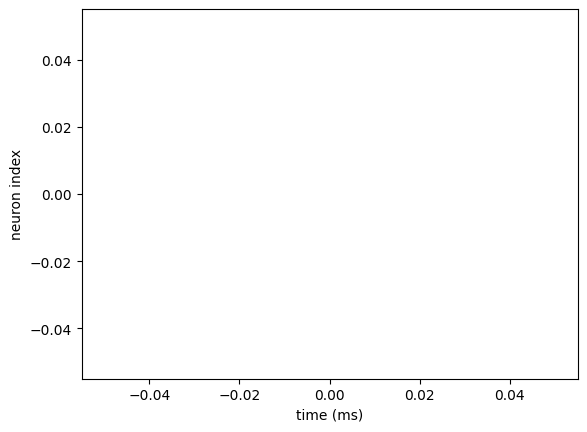

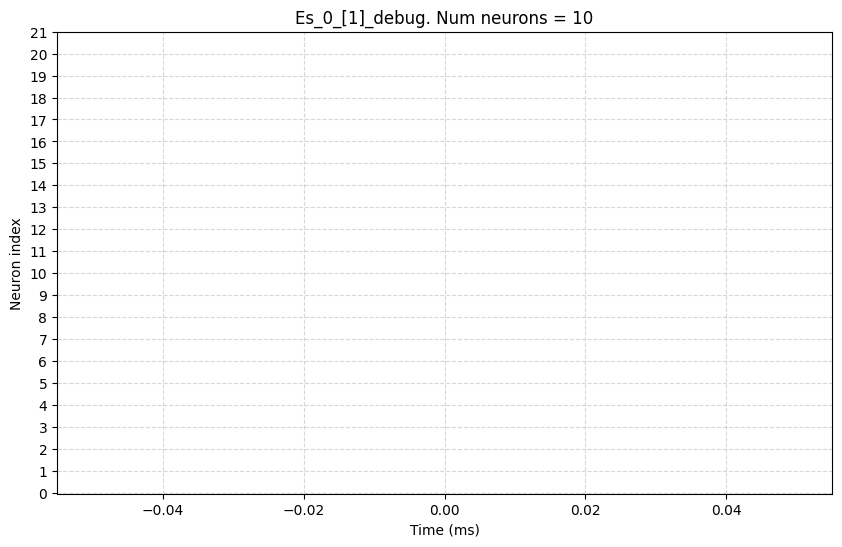

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')


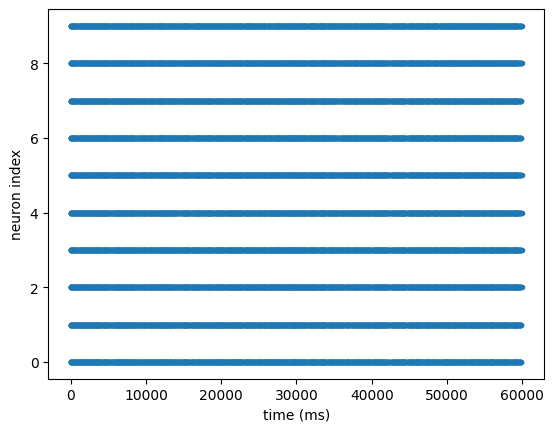

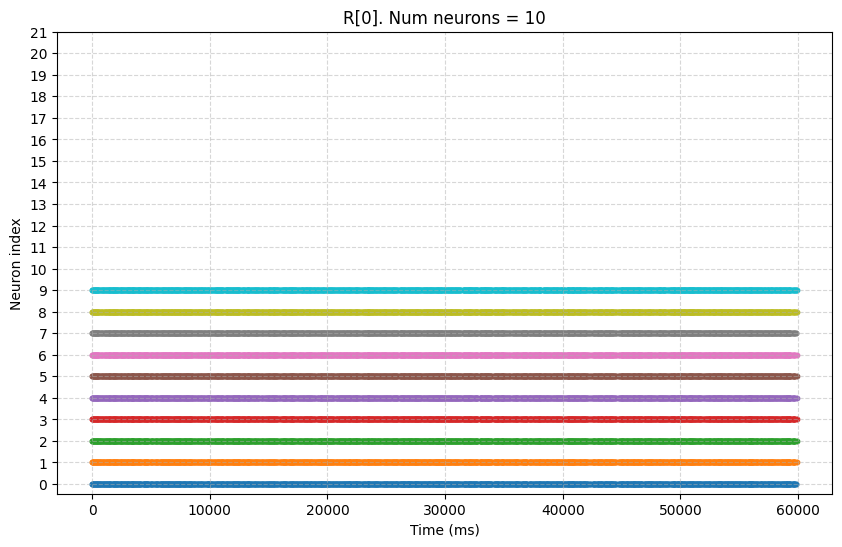

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')


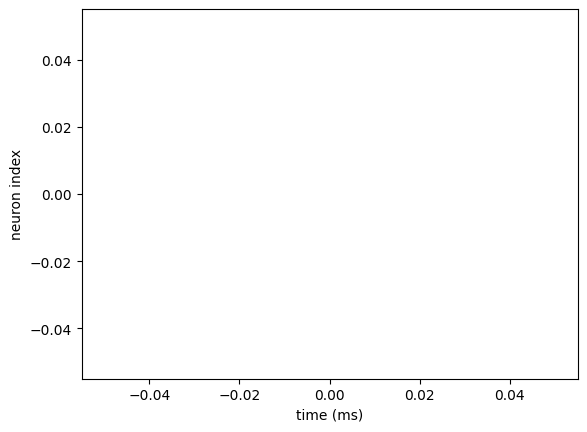

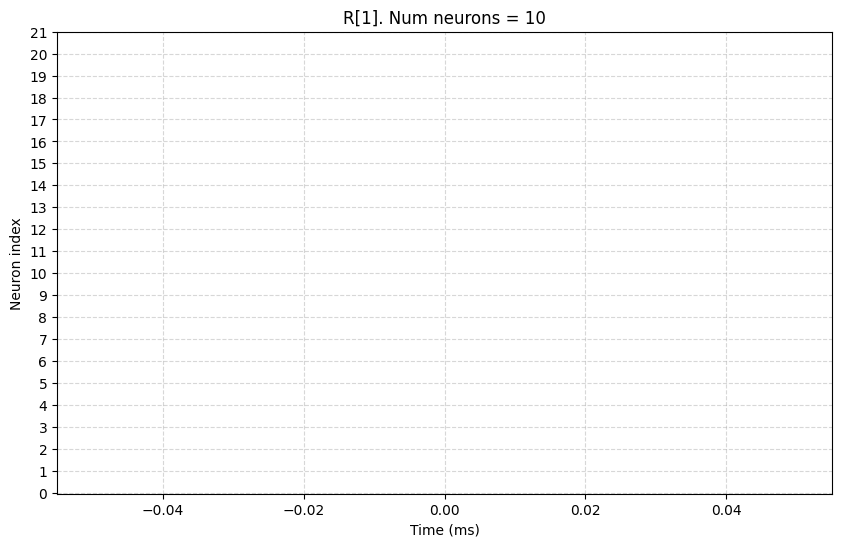

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_3')


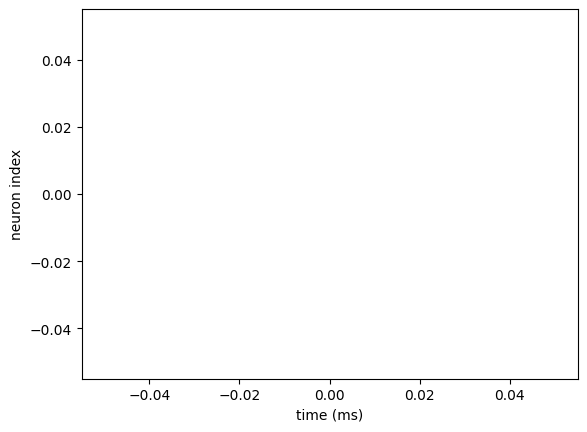

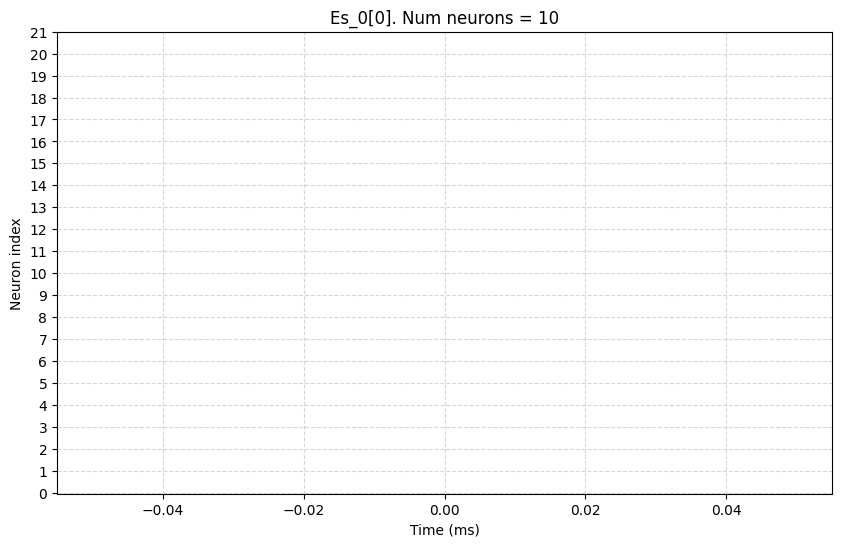

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_5')


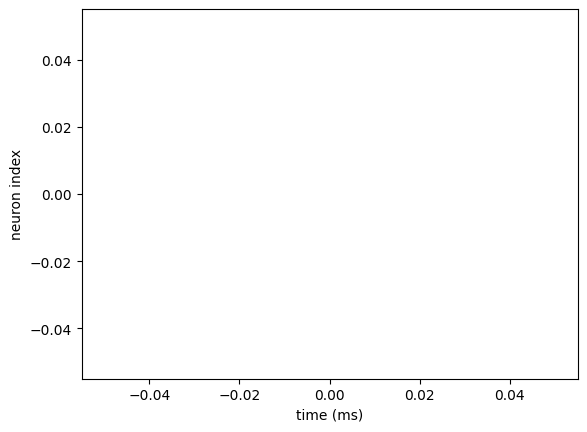

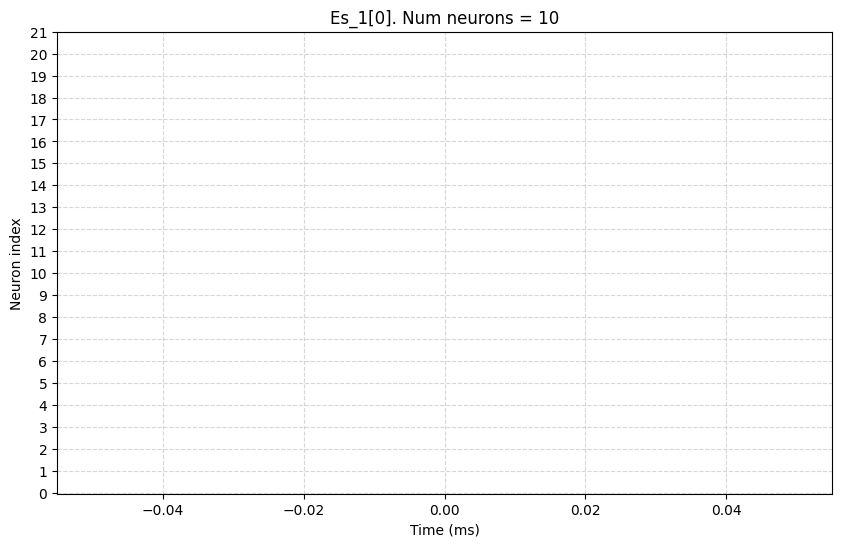

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')


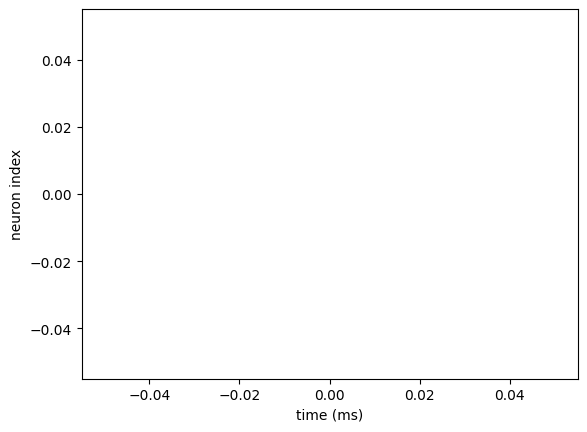

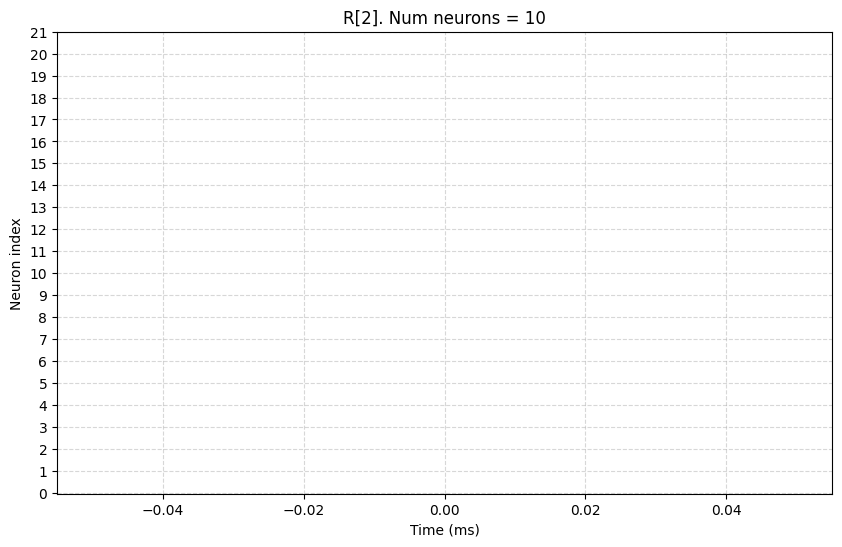

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_4')


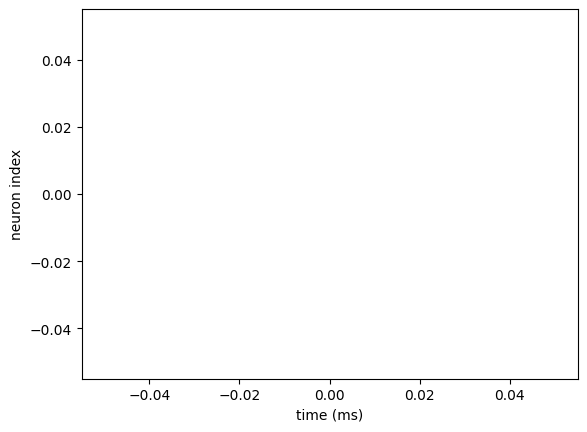

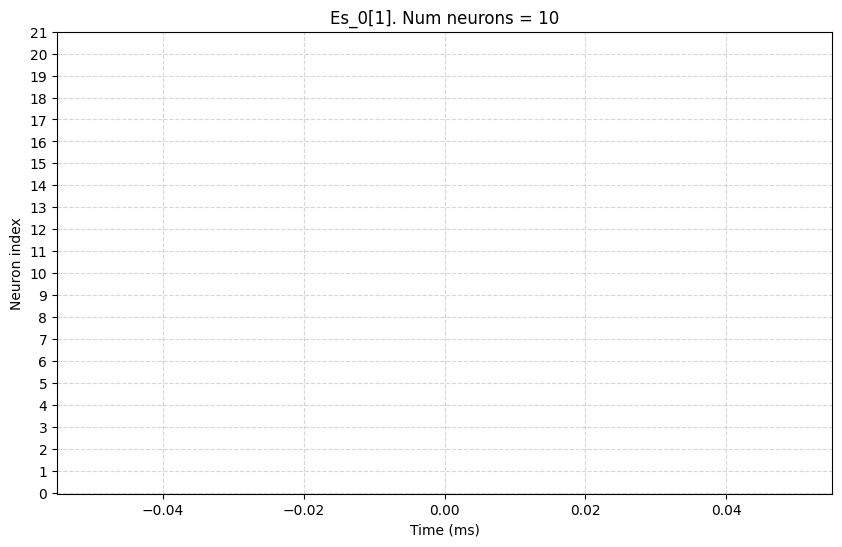

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_6')


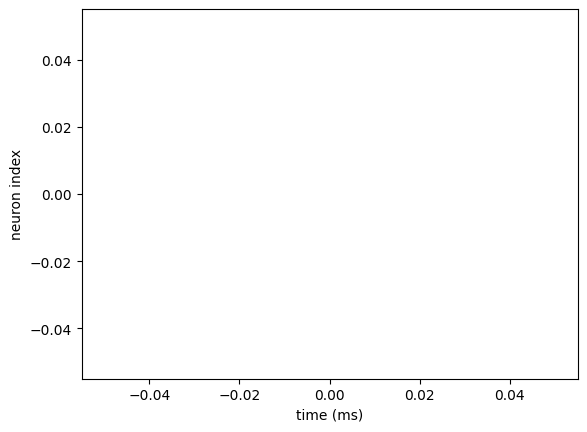

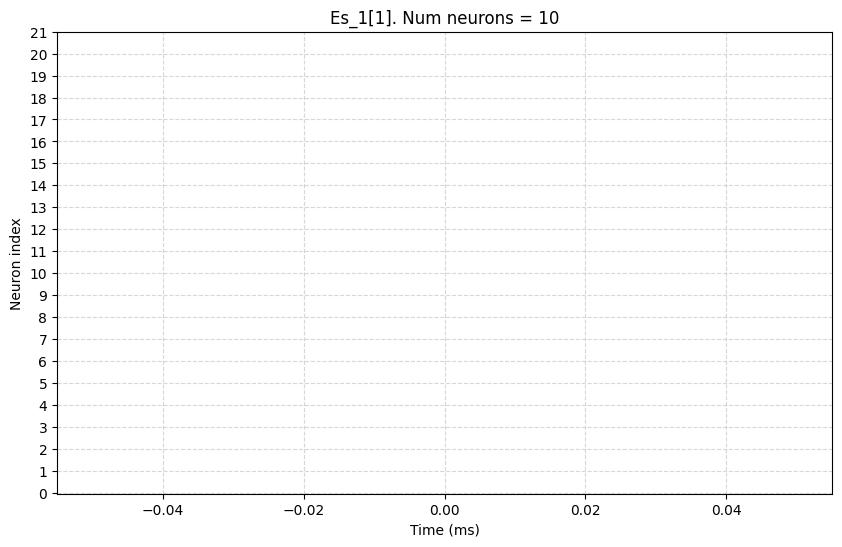

In [1]:

import os

import time
import torch
import datetime
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils




from brian2 import prefs
#from brian2 import set_device
from brian2.devices import device_module

import brian2cuda
from brian2cuda import *

import brian2tools as b2t


set_device("cpp_standalone", directory='project', build_on_run=False)

device = b2.get_device()


#set_device("cuda_standalone", build_on_run=True)
# Set specific preferences for CUDA standalone


prefs.devices.cuda_standalone.cuda_backend.cuda_runtime_version = (12.2)
prefs.devices.cuda_standalone.profile_statemonitor_copy_to_host = None
prefs.devices.cuda_standalone.cuda_backend.extra_compile_args_nvcc = ['-use_fast_math', '-w']
prefs.devices.cuda_standalone.cuda_backend.detect_gpus = True
prefs.devices.cuda_standalone.cuda_backend.gpu_id = 0  # Use the first GPU
# prefs.devices.cuda_standalone.cuda_backend.cuda_path = '/home/brovoletto/SerotoninSNN/nvcc_installation/nvcc_folder'



# REMEMBER YOU SWITCHED SOME EXCITATORY WITH INHIBITORY!!!!!!!!


###############################################################################
# Model Parameters and Equations
###############################################################################
msec_step = 100 * ms

# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# TODO: Make weights always non-negative! (maybe not necessary)
# Equations for everything. I_post in the synapse is modifying I in the target neuron




# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -45.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 100 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nsiemens   # Initial synaptic weight (conductance)

regularizer = 10 * nvolt


# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : volt   # Accumulate X values over a batch

'''
# Ii = I + input_stimuli(t)  :  amp  # Input current


input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
I = input_stimuli(t, i) : amp
indices : integer
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp  # Synaptic input
Iexc_internal : amp  # Synaptic input
I_tot = Iexc + Iexc_internal + output_stimuli(t, i) : amp
indices : integer  # dimensionless index variable
spike_count = 0 : integer
batch_sum_X : volt
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
w : siemens   # Synaptic weight, conductance

Iexc_post = w * X_post : amp (summed)
'''

syn_eqs_exc_2 = '''
w : siemens   # Synaptic weight, conductance

Iexc_2_post = w * X_post : amp (summed)
'''

syn_eqs_exc_3 = '''
w : siemens

Iexc_3_post = w * X_post : amp (summed)
'''

syn_eqs_exc_4 = '''
w : siemens

Iexc_4_post = w * X_post : amp (summed)
'''


syn_eqs_exc_output = '''
w : siemens   # Synaptic weight, conductance

Iexc_internal_post = w * X_post  : amp (summed)
'''



syn_eqs_inh= '''
w : siemens   # Synaptic weight, conductance

Iinh_post = w * -X_post  : amp (summed)
'''

syn_eqs_inh_2= '''
w : siemens   # Synaptic weight, conductance

Iinh_2_post = w * -X_post  : amp (summed)
'''

syn_eqs_inh_3= '''
w : siemens   # Synaptic weight, conductance

Iinh_3_post = w * -X_post  : amp (summed)
'''

syn_eqs_inh_4= '''
w : siemens   # Synaptic weight, conductance

Iinh_4_post = w * -X_post  : amp (summed)
'''






###############################################################################
# Helper Functions
###############################################################################
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for i, dim in enumerate(dims):
        if i == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups


class NamedSynapses(Synapses):
    def __init__(self, source, target=None, model=None, custom_name=None, **kwargs):
        super().__init__(source, target, model, **kwargs)
        
        self.add_attribute("brian2_name")
        self.add_attribute("custom_name")
        
        self.brian2_name = self.name  
        
        self.custom_name = custom_name or f"{source}-{target}"
        
        print(self.brian2_name, self.custom_name)
        
    def connect(self, **kwargs):
        # Call the original connect method
        super().connect(**kwargs)
        if self.custom_name == "suygu5":
            # Print the connections
            connections = [(i, j) for i, j in zip(self.i[:], self.j[:])]
            print("Connections created:")
            for pre, post in connections:
                print(f"Pre: {pre}, Post: {post}")
            
        
        
class NamedSpikeMonitor(SpikeMonitor):
    def __init__(self, group, custom_name=None, **kwargs):
        super().__init__(group, **kwargs)
        self.add_attribute("custom_name")
        self.custom_name = custom_name or str(group)    
     
     
     
def manual_fully_connect(syn, N_pre, N_post):
    # Manually specify connections
    pre_indices = [i for i in range(N_pre) for _ in range(N_post)]
    post_indices = [j for _ in range(N_pre) for j in range(N_post)]

    # Connect manually
    syn.connect(i=pre_indices, j=post_indices) 
    
    return syn  
            

def make_bottom_up_connections(R, E_0, E_1):
    print("A")
    print("Bottom-up: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(R, E_0, model=syn_eqs_exc, on_pre='Y_post = 1*mvolt', custom_name = "s1")
    S_p.connect(j='i')
    S_p.w = 'w_init'

    S_m = NamedSynapses(R, E_1, model=syn_eqs_inh, on_pre='Y_post = 1*mvolt', custom_name = "s2")
    S_m.connect(j='i')
    S_m.w = 'w_init'

    return S_p, S_m

def make_bottom_up_connections_2(E_0, E_1,R):
    print("B")
    print("Bottom-up-2: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(E_0, R, model=syn_eqs_inh_2, on_pre='Y_post = 1*mvolt', custom_name = "s3")
    S_p.connect(j='i')
    S_p.w = 'w_init'

    S_m = NamedSynapses(E_1, R,  model=syn_eqs_exc_2, on_pre='Y_post = 1*mvolt', custom_name = "s4")
    S_m.connect(j='i')
    S_m.w = 'w_init'

    return S_p, S_m




def make_top_down_connections(R, E_0, E_1):
    print("C")
    print("Top-down: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(R, E_1, model=syn_eqs_exc_3, on_pre='Y_post = 1*mvolt', custom_name = "s5")
    #S_p.connect()
    manual_fully_connect(S_p, R.N, E_1.N)
    S_p.w = 'rand() * w_init'

    S_m = NamedSynapses(R, E_0, model=syn_eqs_inh_3, on_pre='Y_post = 1*mvolt', custom_name = "s6")
    #S_m.connect()
    manual_fully_connect(S_m, R.N, E_0.N)
    S_m.w = 'rand() * w_init'

    return S_p, S_m



def make_top_down_connections_2(E_0, E_1, R):
    print("D")
    print("Top-down-2: ", R.N, E_0.N, E_1.N )
    S_p_2 = NamedSynapses(E_1, R,  model=syn_eqs_inh_4, on_pre='Y_post = 1*mvolt', custom_name = "s7")
    #S_p.connect()
    manual_fully_connect(S_p_2, E_1.N, R.N)
    S_p_2.w = 'rand() * w_init'

    S_m_2 = NamedSynapses(E_0, R,  model=syn_eqs_exc_4, on_pre='Y_post = 1*mvolt', custom_name = "s8")
    #S_m.connect()
    manual_fully_connect(S_m_2, E_0.N, R.N)
    S_m_2.w = 'rand() * w_init'

    return S_p_2, S_m_2



def make_gist_connections(Rs, G):
    S_gist_input = NamedSynapses(Rs[0], G, model=syn_eqs_exc, on_pre='Y_post = 1*mvolt', custom_name = "s9")
    #S_gist_input.connect(p=0.05)
    #S_gist_input.w = 'rand() * w_init'

    # Connect G to all other layers
    S_gist_output = NamedSynapses(G, Rs[-1], model=syn_eqs_exc, on_pre='Y = 1*volt', custom_name = "s10")
    #S_gist_output.connect(p=0.05)
    #S_gist_output.w = 'rand() * w_init'
    return S_gist_input, S_gist_output



def make_output_layer(num_classes_per_layer, max_depth):
    
    '''
    if w_out_init is None:
        w_out_init = w_init/3000
        print("W_OUT_INIT: ", w_out_init)
    '''

    total_neurons = sum([num_classes_per_layer**(d) for d in range(max_depth)])
    Os = NeuronGroup(N=total_neurons, model=out_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    #S_o = NamedSynapses(Os, Os, model=syn_eqs_exc_output, on_pre='Y_post = 1*mvolt')

    trace = 0
    for d in range(num_classes_per_layer - 1):
        new_trace = trace + num_classes_per_layer**(d+1)
        source_indices = list(range(trace, trace + num_classes_per_layer**(d+1)))
        target_indices = list(range(new_trace, new_trace + num_classes_per_layer**(d+2)))
        ii, jj = np.meshgrid(source_indices, target_indices, indexing='ij')
        #S_o.connect(i=ii.flatten(), j=jj.flatten())
        trace = new_trace

    # Assign indices for output stimuli
    stimulus_indices = []
    for i in range(max_depth):
        for _ in range(num_classes_per_layer**(i+1)):
            stimulus_indices.append(i)
    Os.indices = stimulus_indices

    return Os#, S_o






def make_network(dims, num_classes_per_layer, max_depth):
    max_depth += 1
    Rs = make_groups(dims, with_input=True)
    Es_0 = make_groups(dims[:-1])
    Es_1 = make_groups(dims[:-1])
    G = NeuronGroup(16, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    #Os, S_o_internal = make_output_layer(num_classes_per_layer, max_depth, w_out_init=w_out_init)
    Os = make_output_layer(num_classes_per_layer, max_depth)
    w_out_init = w_init/100
    
    connections = {}
    for i in range(len(Rs)-1):
        S_p, S_m = make_bottom_up_connections(Rs[i], Es_0[i], Es_1[i])

        if i != 0:
            S_p_2, S_m_2 = make_bottom_up_connections_2(Es_0[i], Es_1[i], Rs[i])
            connections[f"bottom_up_2_{i}"] = [S_p_2, S_m_2]
        connections[f"bottom_up_{i}"] = [S_p, S_m]

        if i != len(Rs)-1:
            S_p_td, S_m_td = make_top_down_connections(Rs[i+1], Es_0[i], Es_1[i])
            S_p_td_2, S_m_td_2 = make_top_down_connections_2(Es_0[i], Es_1[i], Rs[i+1])
            connections[f"top_down{i}"] = [S_p_td, S_m_td]
            connections[f"top_down_2_{i}"] = [S_p_td_2, S_m_td_2]

    S_gist_input, S_gist_output = make_gist_connections(Rs, G)
    connections["gist_input"] = [S_gist_input]
    connections["gist_output"] = [S_gist_output]

    # External output connections
    # In original code: attempted to connect Rs[-1] to Os
    # We'll do a single large synapse group for simplicity:
    S_o_external = NamedSynapses(Rs[-1], Os, model=syn_eqs_exc, on_pre='Y_post = 1*mvolt', custom_name = "s11")
    S_o_external_2 = NamedSynapses(Os, Rs[-1],  model=syn_eqs_exc_2, on_pre='Y_post = 1*mvolt', custom_name = "s12")
    '''
    S_o_external.connect()
    S_o_external.w = 'rand() * w_init'
    S_o_external_2.connect()
    S_o_external_2.w = 'rand() * w_init'
    '''
    connections["output_external"] = [S_o_external]
    connections["output_external_2"] = [S_o_external_2]

  
    # return Rs, Es_0, Es_1, G, Os, S_o_internal, connections
    
    return Rs, Es_0, Es_1, G, Os,  connections




def normalize_tensor(tensor, old_min, old_max, new_min, new_max):
    normalized_tensor = (tensor - old_min) / (old_max - old_min)
    scaled_tensor = normalized_tensor * (new_max - new_min) + new_min
    return scaled_tensor




def normalize_and_unwrap_dataset(dt, minval, maxval):
    minimum = 0
    maximum = 0
    all_curves = [torch.tensor(curve, dtype=torch.float64) for curve in chain.from_iterable(dt["curves"].values())]
    for curve in all_curves:
        _min = torch.min(curve)
        _max = torch.max(curve)
        if (minimum > _min): minimum = _min
        if (maximum < _max): maximum = _max

    unwrapped = []
    for key in dt["categories"].keys():
        for curve in dt["curves"][key]:
            unwrapped.append((torch.tensor(key), normalize_tensor(torch.tensor(curve), minimum, maximum, minval, maxval)))
    return unwrapped



def get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer):
    if labels.ndim == 1:
        labels = labels.unsqueeze(0)

    indexes = torch.zeros_like(labels)
    for i in range(labels.shape[1]):
        summed = 0
        if i > 0:
            summed = torch.stack([labels[:, j]*num_classes_per_layer**(i-j) for j in range(i)]).sum(dim=0)
        indexes[:, i] = summed + labels[:, i]

    # Adjust indexes for concatenation
    to_sum = 0
    for i in range(labels.shape[1]):
        if i > 0:
            to_sum += num_classes_per_layer**i
        indexes[:, i] = indexes[:, i] + to_sum
    return indexes

def get_output_current_arrays(I_indexes, dim, I_value):
    if I_indexes.ndim == 1:
        I_indexes = I_indexes.unsqueeze(0)

    out = torch.zeros((I_indexes.shape[0], dim), dtype=torch.float32)
    row_indices = torch.arange(I_indexes.shape[0]).repeat_interleave(I_indexes.shape[1])
    col_indices = I_indexes.flatten()
    out[row_indices, col_indices] = I_value
    return out

class CurveDataset(Dataset):
    def __init__(self, data, minval, maxval):
        self.data = normalize_and_unwrap_dataset(data, minval, maxval)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels, curves = self.data[idx]
        return labels, curves.flatten()

def collate_fn(batch, msec_step, num_pause_blocks, num_classes_per_layer, out_dim):
    labels, curves = zip(*batch)
    labels = torch.stack(labels, dim=0)
    curves = torch.stack(curves, dim=0)

    pause = torch.zeros_like(curves[0])
    pause_block = torch.tile(pause, (num_pause_blocks, 1))
    curves_with_pause = torch.vstack([torch.vstack((row, pause_block)) for row in curves])
    visual_stimulus = TimedArray(curves_with_pause.numpy() * nA, dt=msec_step)

    stimulus_indexes = TimedArray(np.tile([1] + [0] * num_pause_blocks, curves.size(0)), dt=msec_step)

    out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer)
    out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
    label_pause = torch.zeros(out_dim)
    label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1))
    out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])
    output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * nA, dt=msec_step)

    return stimulus_indexes, output_stimuli, visual_stimulus

###############################################################################
# Build the network and run
###############################################################################
#dims = [22*22, 250, 125, 64]
dims = [10,10,10]
num_classes_per_layer = 3
max_depth = 3

# Rs, Es_0, Es_1, G, Os, S_o_internal, connections = make_network(dims, num_classes_per_layer, max_depth)
Rs, Es_0, Es_1, G, Os, connections = make_network(dims, num_classes_per_layer, max_depth)

Rs[0].indices = range(Rs[0].N)

su = Synthetic_Dataset_Utils()
ranges = [30, 30, 30, 30]
prior_params = [10, 10, 10, 10]
num_samples_per_class = 500
N = 22
tree = su.build_tree(prior_params, 0, max_depth, num_classes_per_layer, 1, ranges)
synth_dataset = su.make_dataset(tree, num_classes_per_layer, num_samples_per_class=num_samples_per_class, N=N)

output_dim = Os.N
lr = 0.03
batch_size = 300
num_pause_blocks = 1

dataset = CurveDataset(synth_dataset, 0.6, 1.5)
dl = DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=partial(
        collate_fn,
        msec_step=msec_step,
        num_pause_blocks=num_pause_blocks,
        num_classes_per_layer=num_classes_per_layer,
        out_dim=output_dim
    )
)



torch.save(dataset, "data/dataset1.pt")

#dataset = torch.load("data/dataset1.pt")




@network_operation()
def debug():
    print("Rs[0].I: ", Rs[0].I[:])
    
    
def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation
    
    
@network_operation()
def update_sums():
    current_idx = int(defaultclock.t / msec_step)
    if stimulus_indexes.values[current_idx] == 1:
        for n in range(len(Rs)-1):
            if n > 0:
                Rs[n+1].batch_sum_X += Rs[n+1].X
            Es_0[n].batch_sum_X += Es_0[n].X
            Es_1[n].batch_sum_X += Es_1[n].X
            
    Os.batch_sum_X += Os.X
            


def if_positive(x, w):
    # Return x where w > 0, otherwise 0 (element-wise)
    return np.where(w > 0, x, 0 * volt)
    
    
@network_operation()
def apply_weight_update():
    print("Applying weight update")
    for n in range(len(Rs)-1):
        
        print("n: ", n)
        
        # Retrieve top_down synapses       
        S_p, S_m = connections[f"top_down_{n}"]
        S_p_2, S_m_2 = connections[f"top_down_2_{n}"]
        
        
        
        
            
        for j_idx in range(Es_0[n].N):
            for i_idx in range(Rs[n+1].N):
                
                positive_connections_delta = lr * volt * Es_0[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx] - if_positive(regularizer, S_p.w_[i_idx, j_idx])
                negative_connections_delta = lr * volt * Es_1[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx] - if_positive(regularizer, S_m.w_[i_idx, j_idx])
                
                S_p.w[i_idx, j_idx] += positive_connections_delta_ * siemens
                S_m.w[i_idx, j_idx] -= negative_connections_delta_ * siemens
                
                S_p_2.w[i_idx, j_idx] += positive_connections_delta_ * siemens
                S_m_2.w[i_idx, j_idx] -= negative_connections_delta_ * siemens
                
     
            # Reset after update
            Rs[n+1].batch_sum_X[:] = 0 * volt
            Es_0[n].batch_sum_X[:] = 0 * volt
            Es_1[n].batch_sum_X[:] = 0 * volt
    
    
    
    external_syn = connections["output_external"][0]
    external_syn_2 = connections["output_external_2"][0]
    
    for i_idx in range(Rs[-1].N):
        for j_idx in range(Os.N):
            
            delta = lr * Rs[-1].batch_sum_X[i_idx] * Os.batch_sum_X[j_idx] * siemens
            external_syn.w[i_idx, j_idx] += delta
            external_syn_2.w[i_idx, j_idx] += delta
            
            
    Rs[-1].batch_sum_X[:] = 0
    Os.batch_sum_X[:] = 0
        
            
            
     
# Extract all synapses and objects for the network
all_synapses = []
# all_synapses.append(S_o_internal)

for i in range(len(Rs)-1):
    bu_syns = connections[f"bottom_up_{i}"]
    all_synapses.extend(bu_syns)
    td_key = f"top_down_{i}"
    if td_key in connections:
        td_syns = connections[td_key]
        all_synapses.extend(td_syns)

for i in range(1,len(Rs)-1):
    bu_syns = connections[f"bottom_up_2_{i}"]
    all_synapses.extend(bu_syns)
    td_key = f"top_down_2_{i}"
    if td_key in connections:
        td_syns = connections[td_key]
        all_synapses.extend(td_syns)

gist_input_syn = connections["gist_input"][0]
gist_output_syn = connections["gist_output"][0]
all_synapses.append(gist_input_syn)
all_synapses.append(gist_output_syn)

external_syn = connections["output_external"][0]
external_syn_2 = connections["output_external_2"][0]
all_synapses.append(external_syn)

#monitor = StateMonitor(Rs[0], ['v', 'I'], record=[0])
#spike_monitor = SpikeMonitor(Rs[0])

s = 0

        



monitor_o = StateMonitor(Os, ['v', 'I_tot', 'X'], record=True)
spike_mon_o = NamedSpikeMonitor(Os, record = True, custom_name = "output")

'''
net = Network(
    Rs, Es_0, Es_1, G, Os,
    all_synapses,        
    monitor_o, spike_mon_o,         # <-- Add these
    debug, update_sums, apply_weight_update
)
'''

# Add spike monitors for all neuron groups

spike_mon_G = NamedSpikeMonitor(G, record=True, custom_name = "Gist")

stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))

debug_monitor = NamedSpikeMonitor(Es_0[1], record=True, custom_name = f"Es_0_[1]_debug")
net = Network(
    Rs, Es_0, Es_1, G, Os,  # Neuron groups       
    monitor_o, spike_mon_o, debug_monitor, # Output monitors
    spike_mon_G,  # Spike monitors
    debug, update_sums, apply_weight_update # Additional operations
)

for i in range(len(Rs)):
    net.add(NamedSpikeMonitor(Rs[i], record=True, custom_name = f"R[{i}]"))
    if i > 0:
        net.add(NamedSpikeMonitor(Es_0[i-1], record=True, custom_name = f"Es_0[{i-1}]"))
        net.add(NamedSpikeMonitor(Es_1[i-1], record=True, custom_name = f"Es_1[{i-1}]"))

for synapse in all_synapses:
    net.add(synapse)

all_batch_rates = []
output_spikes = []

s = 0

#stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))

#net.stimulus_indexes = stimulus_indexes
#net.output_stimuli   = output_stimuli
#net.input_stimuli    = input_stimuli

run_time = (batch_size + batch_size*num_pause_blocks)*100*ms
net.run(run_time)
result_dir = f'results_v2'
device.build(run=True, directory="project_v2",results_directory=result_dir) 

# device.build(directory='project', run = False)

states = net.get_states()

keys = []
for key in states.keys():
    if "spike" in key:
        keys.append(key)
        print(key)
        
for key in keys:
    spike_mon_o = net[key]
    spikes = spike_mon_o.spike_trains()
    
    b2t.brian_plot(spike_mon_o)
    # Plotting the spike train with dots
    plt.figure(figsize=(10, 6))
    i=0
    old = 0
    for neuron, spike_times in spikes.items():
    
        old = spike_times
        
        if i < 100:
            plt.scatter(spike_times/ms, [neuron] * len(spike_times), s=10, label=f'Neuron {neuron}' if neuron == 0 else "")
            i+=1

    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.title(f'{spike_mon_o.custom_name}. Num neurons = {len(spikes.items())}')
    print(spike_mon_o.source)
    plt.yticks(range(N))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    
    '''# Add spike monitors for all neuron groups
spike_mon_Rs = [SpikeMonitor(group, record=True) for group in Rs]
spike_mon_Es_0 = [SpikeMonitor(group, record=True) for group in Es_0]
spike_mon_Es_1 = [SpikeMonitor(group, record=True) for group in Es_1]
spike_mon_G = SpikeMonitor(G, record=True)


# Add all monitors to the network
net = Network(
    Rs, Es_0, Es_1, G, Os,  # Neuron groups
    all_synapses,           # Synapses
    monitor_o, spike_mon_o, # Output monitors
    spike_mon_Rs, spike_mon_Es_0, spike_mon_Es_1, spike_mon_G,  # Spike monitors
    debug, update_sums, apply_weight_update  # Additional operations
)
'''

In [2]:
spike_mon_o = net["spikemonitor"]
spikes = spike_mon_o.spike_trains()

<Axes: xlabel='time (ms)', ylabel='neuron index'>

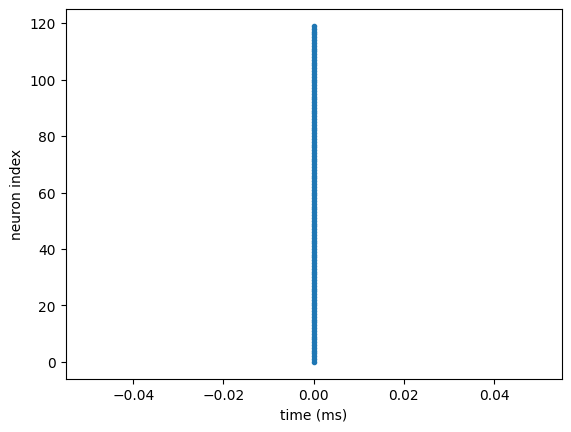

In [8]:
b2t.brian_plot(spike_mon_o)

In [6]:
import brian2tools as b2t

In [ ]:
for key in keys:
    spike_mon_o = net[key]
    spikes = spike_mon_o.spike_trains()
    # Plotting the spike train with dots
    plt.figure(figsize=(10, 6))
    i=0
    old = 0
    for neuron, spike_times in spikes.items():
    
        old = spike_times
        
        if i < 100:
            plt.scatter(spike_times/ms, [neuron] * len(spike_times), s=10, label=f'Neuron {neuron}' if neuron == 0 else "")
            i+=1

    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.title(f'{spike_mon_o.custom_name}. Num neurons = {len(spikes.items())}')
    print(spike_mon_o.source)
    plt.yticks(range(N))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [4]:
stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))

In [5]:
output_stimuli.values

array([[0.e+00, 1.e-09, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 1.e-09, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       ...,
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 1.e-09, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00]],
      shape=(600, 120))

In [2]:
start = time.time()
    
sim.do_run(i)
print("$: ", sim.ddebug)

duration = time.time() - start

print("Duration: ", duration)



$:  fgh
Duration:  10.813438177108765


In [4]:
states = net.get_states()

keys = []
for key in states.keys():
    if "spike" in key:
        keys.append(key)
        print(key)


spikemonitor
spikemonitor_1
spikemonitor_10
spikemonitor_11
spikemonitor_2
spikemonitor_3
spikemonitor_4
spikemonitor_5
spikemonitor_6
spikemonitor_7
spikemonitor_8
spikemonitor_9


NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_11')


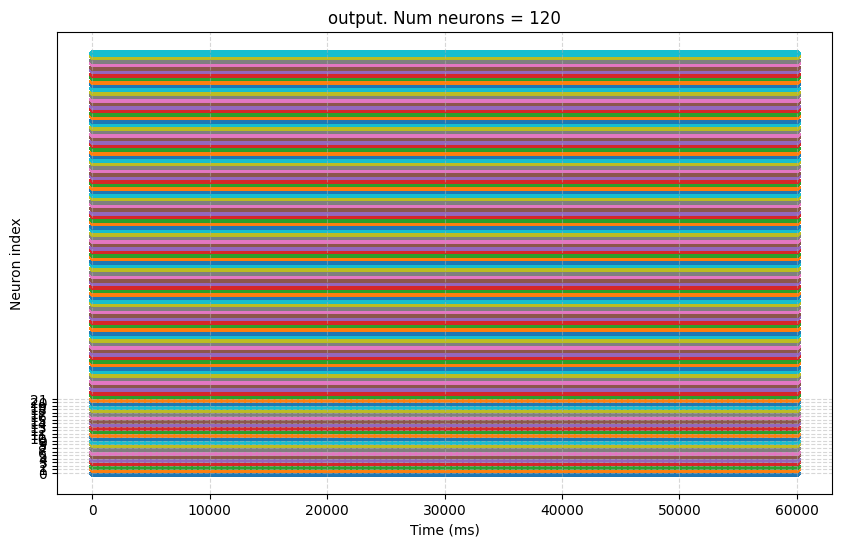

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_10')


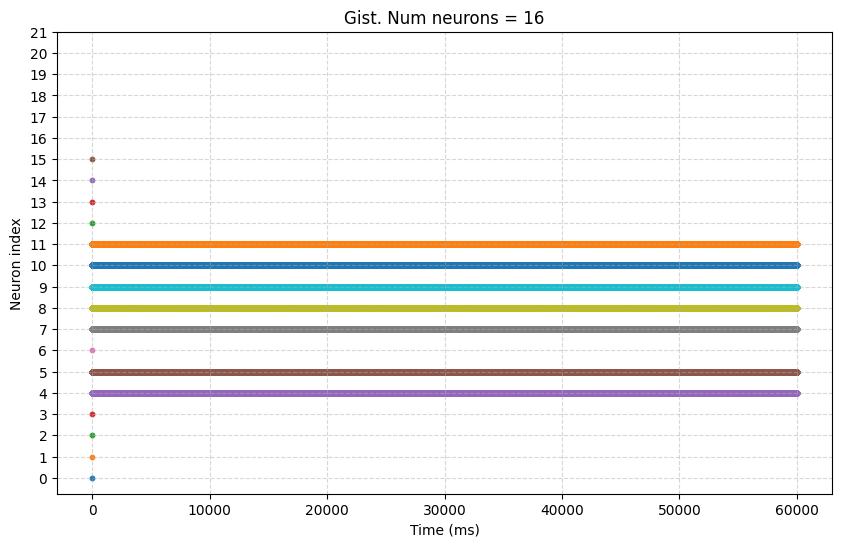

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_6')


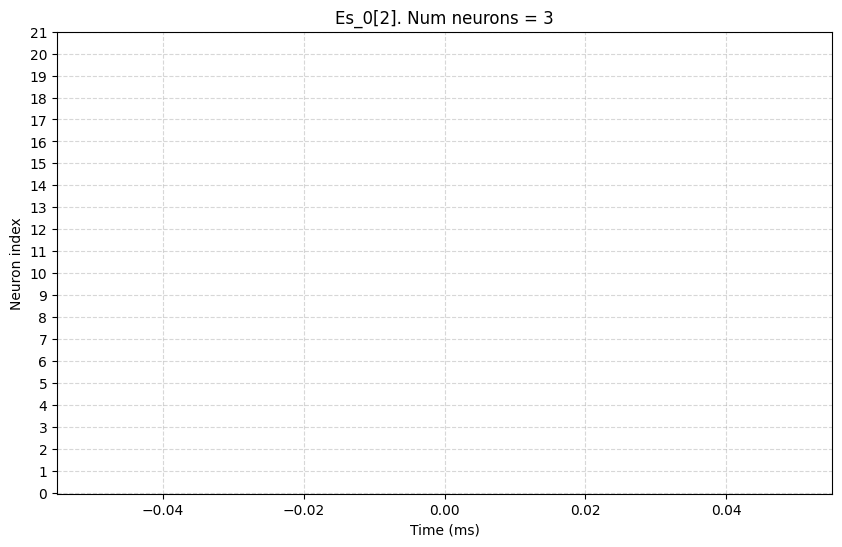

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_9')


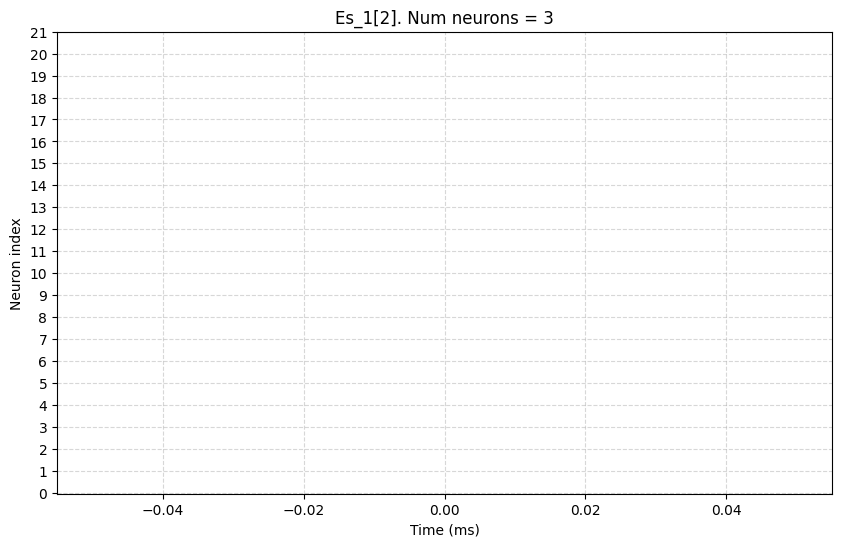

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')


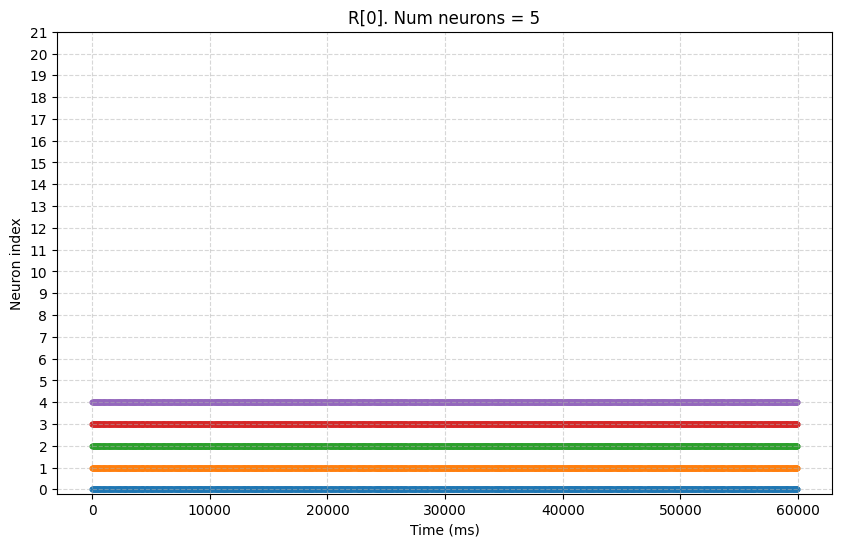

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')


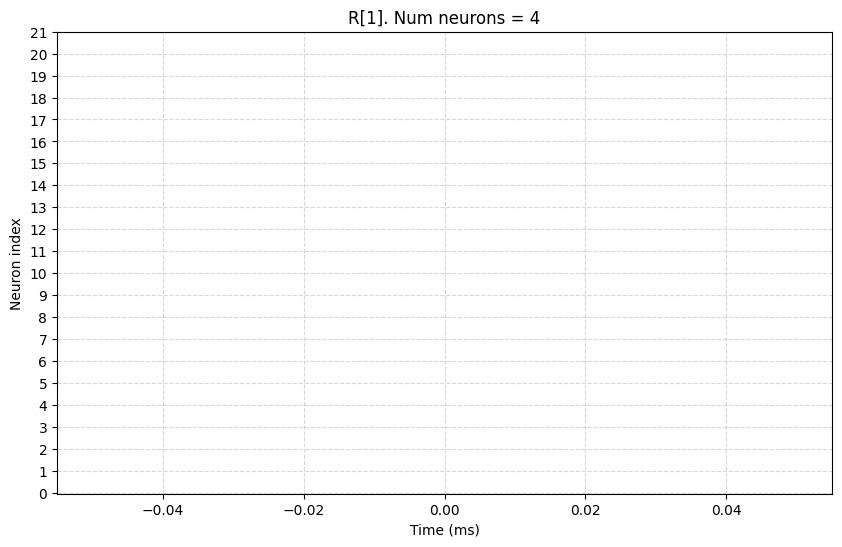

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_4')


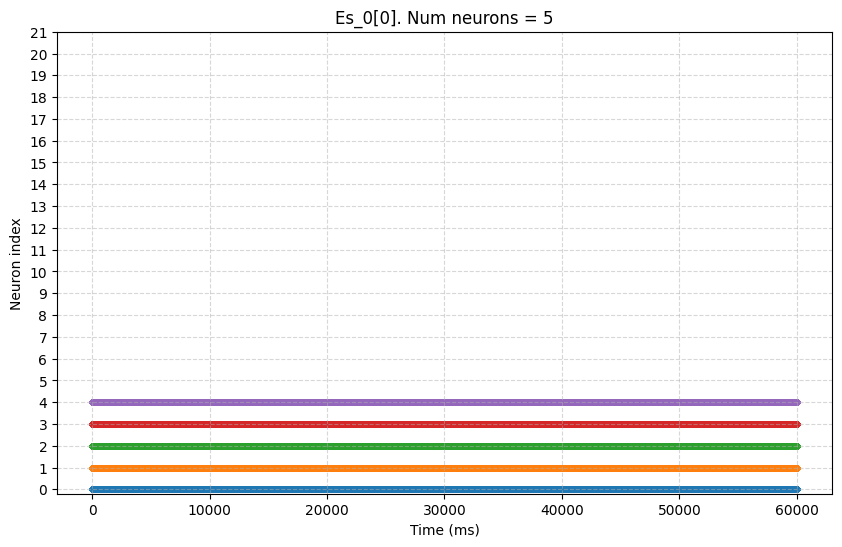

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_7')


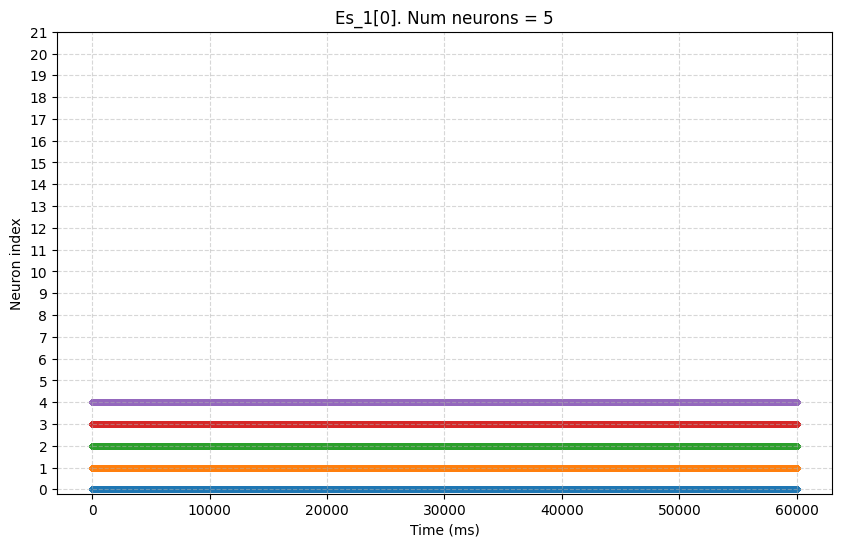

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')


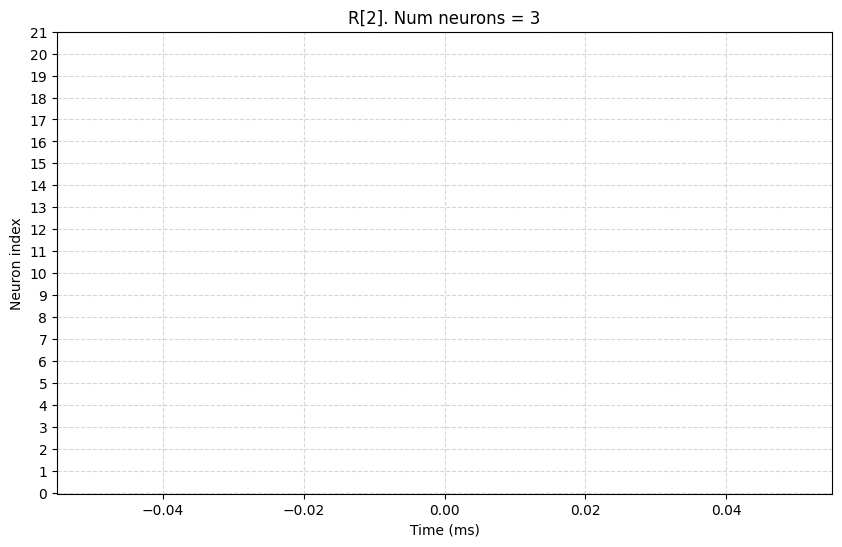

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_5')


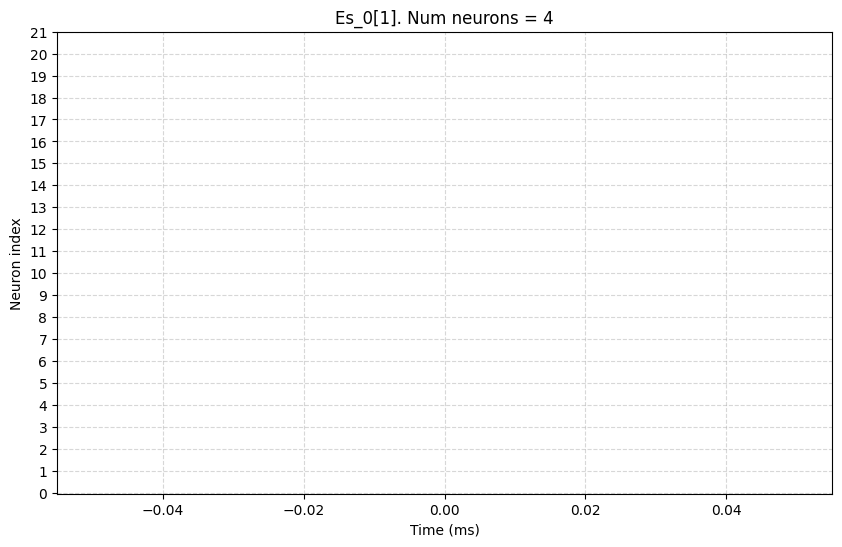

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_8')


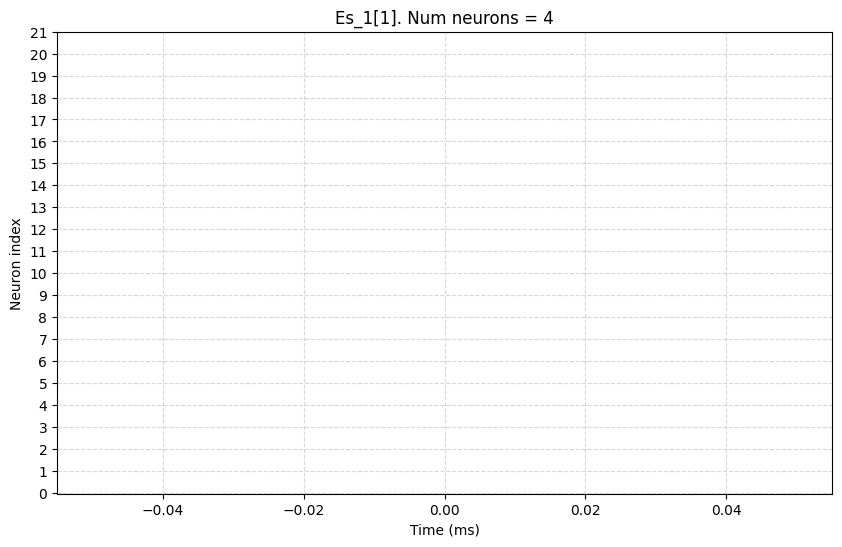

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_3')


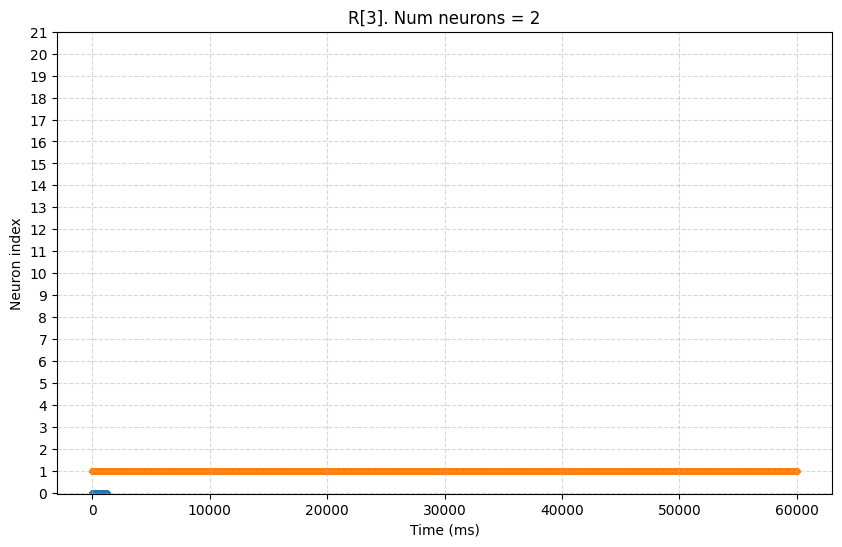

In [5]:
for key in keys:
    spike_mon_o = net[key]
    spikes = spike_mon_o.spike_trains()
    # Plotting the spike train with dots
    plt.figure(figsize=(10, 6))
    i=0
    old = 0
    for neuron, spike_times in spikes.items():
    
        old = spike_times
        
        if i < 1000:
            plt.scatter(spike_times/ms, [neuron] * len(spike_times), s=10, label=f'Neuron {neuron}' if neuron == 0 else "")
            i+=1

    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.title(f'{spike_mon_o.custom_name}. Num neurons = {len(spikes.items())}')
    print(spike_mon_o.source)
    plt.yticks(range(N))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    
    '''# Add spike monitors for all neuron groups
spike_mon_Rs = [SpikeMonitor(group, record=True) for group in Rs]
spike_mon_Es_0 = [SpikeMonitor(group, record=True) for group in Es_0]
spike_mon_Es_1 = [SpikeMonitor(group, record=True) for group in Es_1]
spike_mon_G = SpikeMonitor(G, record=True)


# Add all monitors to the network
net = Network(
    Rs, Es_0, Es_1, G, Os,  # Neuron groups
    all_synapses,           # Synapses
    monitor_o, spike_mon_o, # Output monitors
    spike_mon_Rs, spike_mon_Es_0, spike_mon_Es_1, spike_mon_G,  # Spike monitors
    debug, update_sums, apply_weight_update  # Additional operations
)
'''

In [11]:
print("Mean weight of bottom_up_0:", np.mean(bu_syns[0].w[:]))


Mean weight of bottom_up_0: 1. nS


In [16]:
spikes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119])

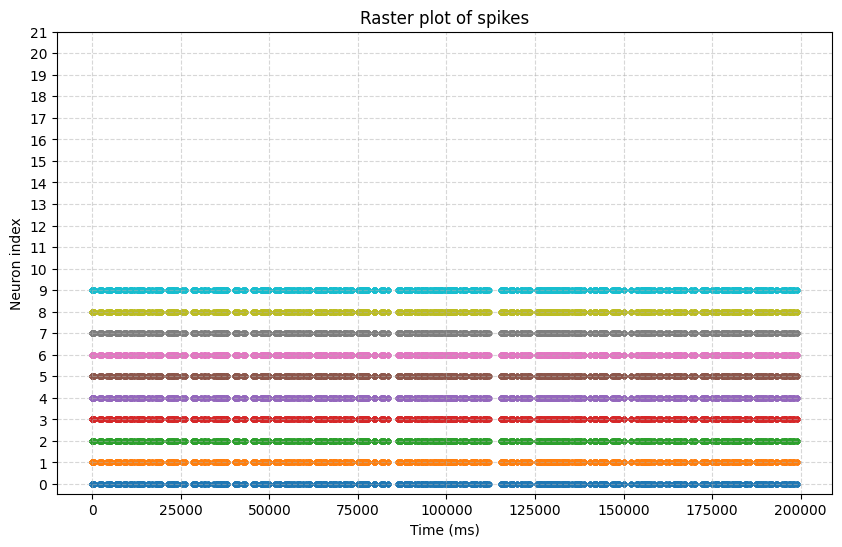

In [20]:
# Plotting the spike train with dots
plt.figure(figsize=(10, 6))
i=0
for neuron, spike_times in spikes.items():
    if i < 10:
        plt.scatter(spike_times/ms, [neuron] * len(spike_times), s=10, label=f'Neuron {neuron}' if neuron == 0 else "")
        i+=1

plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Raster plot of spikes')
plt.yticks(range(N))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Text(0.5, 1.0, 'Firing Rate')

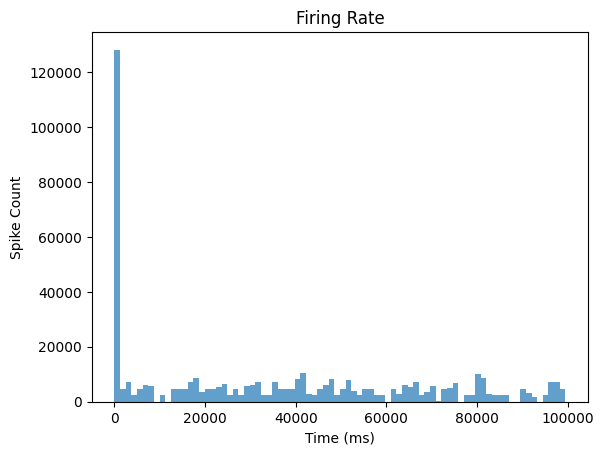

In [23]:
plt.hist(spike_mon_o["t"]/ ms, bins=80, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate')


In [24]:
from collections import defaultdict

# Organize spikes by neuron
spike_times_by_neuron = defaultdict(list)

# Loop through the recorded spikes
for neuron_idx, spike_time in zip(spike_mon_o["i"], spike_mon_o["t"]):
    spike_times_by_neuron[neuron_idx].append(spike_time)



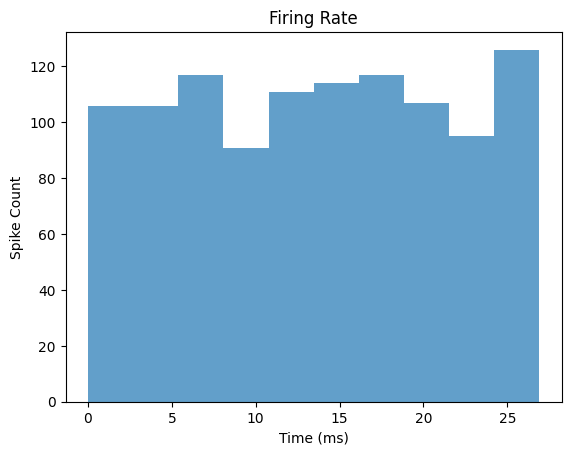

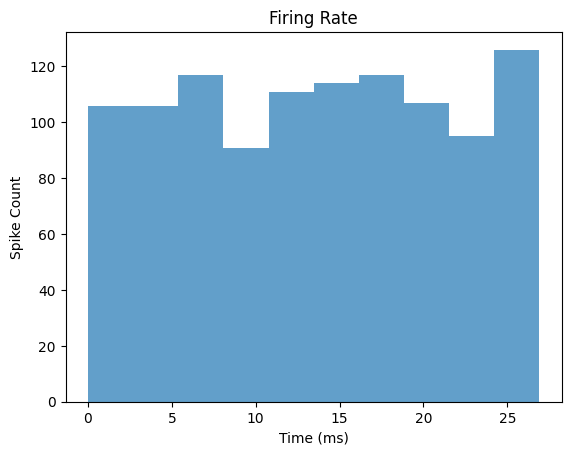

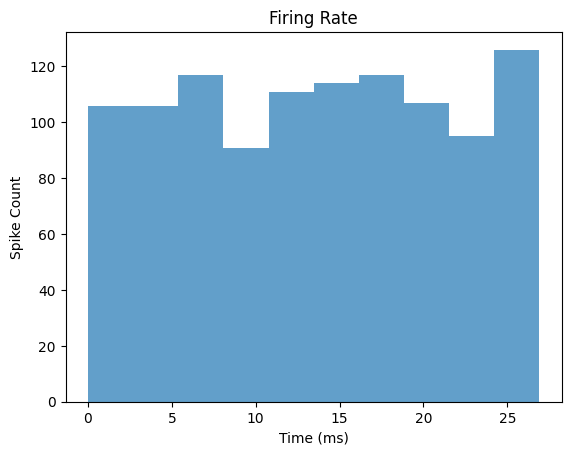

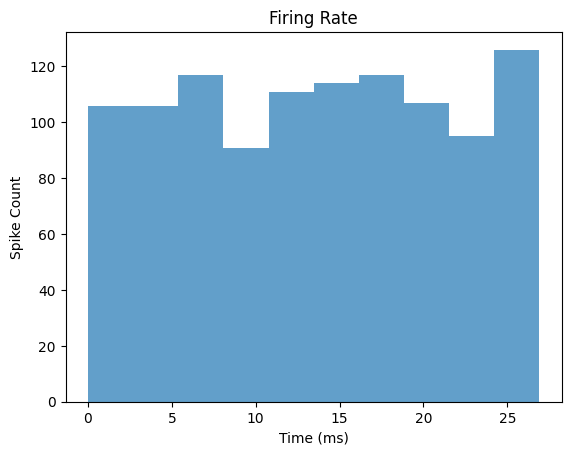

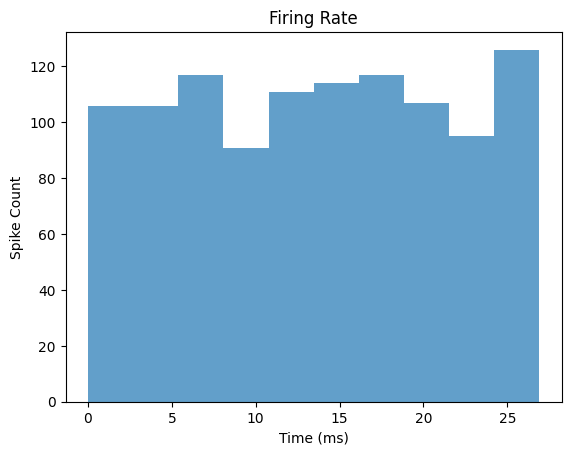

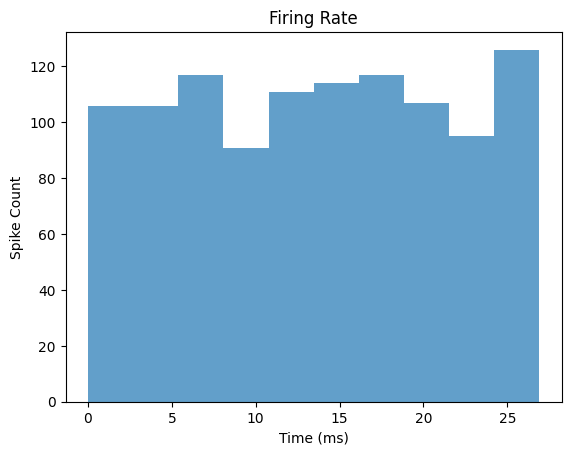

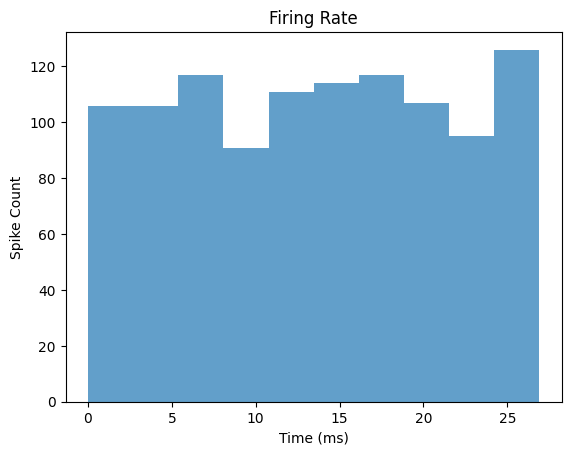

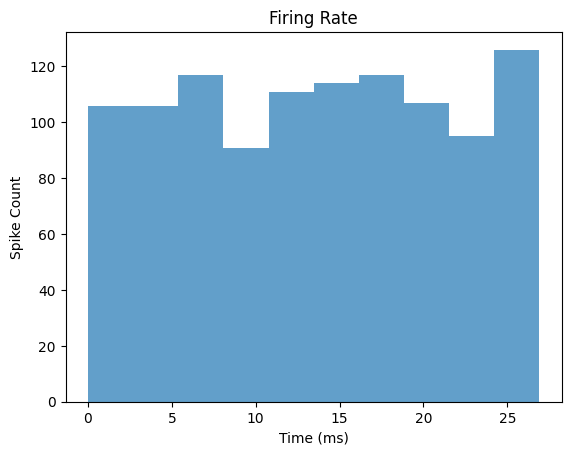

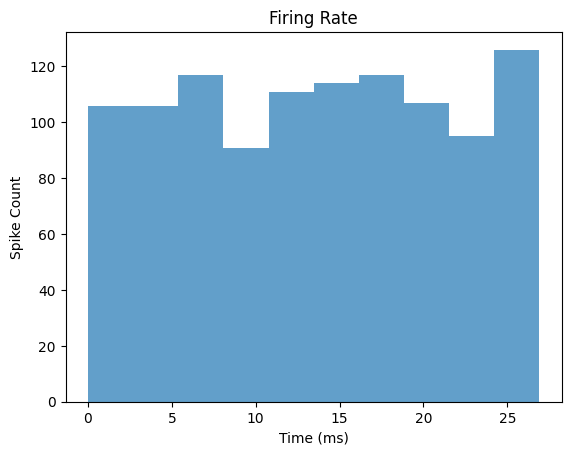

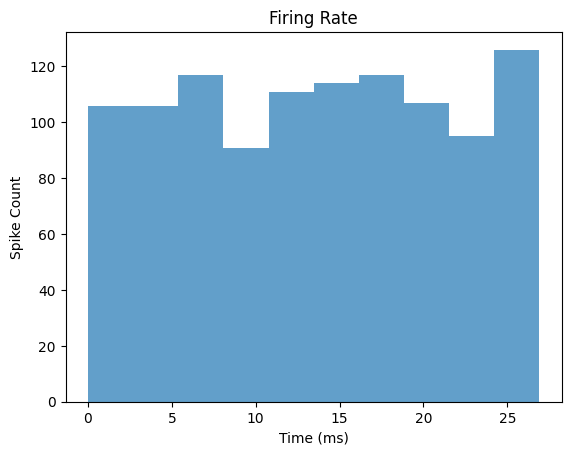

In [13]:
for n in spike_times_by_neuron.keys():
    plt.hist(spike_times_by_neuron[n], bins=100, alpha=0.7)
    plt.xlabel('Time (ms)')
    plt.ylabel('Spike Count')
    plt.title('Firing Rate')
    plt.show()

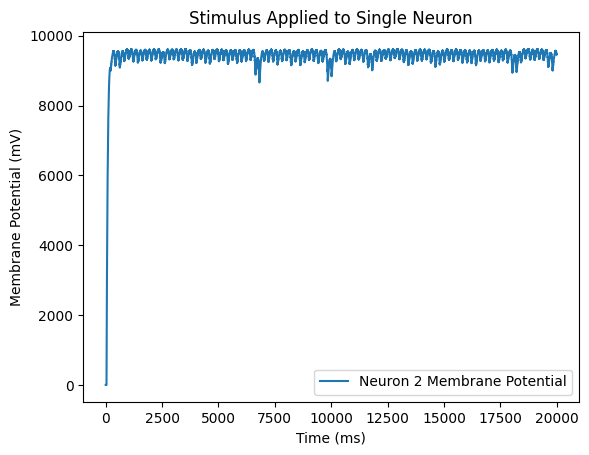

In [3]:
plt.plot(monitor_o.t / ms, monitor_o.X[1] / mV, label='Neuron 2 Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Stimulus Applied to Single Neuron')
plt.legend()

In [5]:
spike_mon_o[7].t

TypeError: 'SpikeMonitor' object is not subscriptable

Labels:  tensor([[1, 2, 0],
        [0, 2, 1],
        [1, 0, 1],
        [0, 0, 1],
        [1, 1, 2],
        [1, 0, 0],
        [2, 2, 2],
        [2, 1, 2],
        [2, 1, 1],
        [2, 1, 0],
        [2, 2, 2],
        [2, 1, 0],
        [2, 2, 0],
        [2, 0, 2],
        [0, 2, 2],
        [0, 0, 0],
        [2, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [2, 2, 0],
        [0, 1, 2],
        [2, 1, 0],
        [0, 2, 0],
        [0, 0, 0],
        [1, 0, 0],
        [2, 2, 1],
        [1, 2, 2],
        [1, 2, 2],
        [2, 2, 1],
        [2, 2, 2],
        [1, 1, 2],
        [0, 0, 2],
        [0, 0, 1],
        [1, 2, 2],
        [1, 1, 1],
        [0, 0, 1],
        [0, 1, 2],
        [0, 0, 0],
        [0, 2, 1],
        [0, 2, 0],
        [0, 0, 2],
        [1, 0, 0],
        [1, 2, 1],
        [1, 0, 1],
        [1, 0, 1],
        [0, 2, 1],
        [2, 1, 1],
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 1],
        [1, 1, 1],
        [2, 0, 2],
   

INFO:root:creating /tmp/brian_flag_test_2uv90hs5/tmp/brian_flag_test_2uv90hs5
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/brian_flag_test_2uv90hs5/flag_test.cpp -o /tmp/brian_flag_test_2uv90hs5/tmp/brian_flag_test_2uv90hs5/flag_test.o -w
INFO:root:creating /tmp/brian_flag_test_6wl5vqd6/tmp/brian_flag_test_6wl5vqd6
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/brian_flag_test_6wl5vqd6/flag_test.cpp -o /tmp/brian_flag_test_6wl5vqd6/tmp/brian_flag_test_6wl5vqd6/flag_test.o -O3
INFO:root:creating /tmp/brian_flag_test_tgds_nqq/tmp/brian_flag_test_tgds_nqq
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwr

spikemonitor
NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')


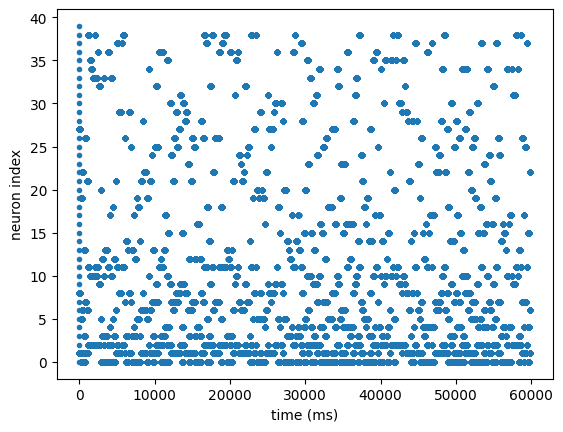

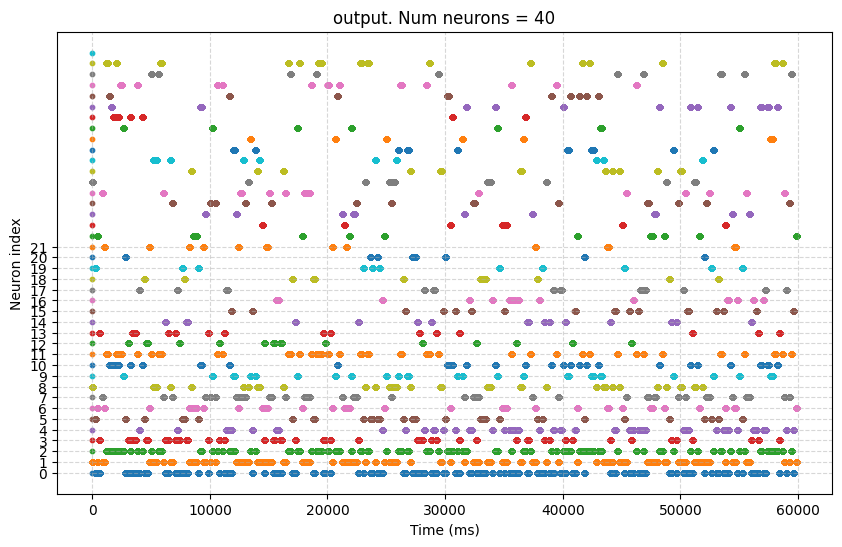

In [1]:

import os

import time
import torch
import datetime
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils




from brian2 import prefs
#from brian2 import set_device
from brian2.devices import device_module

import brian2cuda
from brian2cuda import *

import brian2tools as b2t


# set_device("cpp_standalone", directory='project', build_on_run=False)

# device = b2.get_device()





# REMEMBER YOU SWITCHED SOME EXCITATORY WITH INHIBITORY!!!!!!!!


###############################################################################
# Model Parameters and Equations
###############################################################################

msec_step = 100 * ms

# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# TODO: Make weights always non-negative! (maybe not necessary)
# Equations for everything. I_post in the synapse is modifying I in the target neuron




# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -45.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 100 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.1 * nsiemens   # Initial synaptic weight (conductance)

regularizer = 10 * nvolt


# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : volt   # Accumulate X values over a batch

'''
# Ii = I + input_stimuli(t)  :  amp  # Input current




out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp  # Synaptic input
Iexc_internal : amp  # Synaptic input
I_tot = Iexc + Iexc_internal + output_stimuli(t, i) : amp
indices : integer  # dimensionless index variable
spike_count = 0 : integer
batch_sum_X : volt
'''








###############################################################################
# Helper Functions
###############################################################################
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for i, dim in enumerate(dims):
        if i == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups


class NamedSynapses(Synapses):
    def __init__(self, source, target=None, model=None, custom_name=None, **kwargs):
        super().__init__(source, target, model, **kwargs)
        
        self.add_attribute("brian2_name")
        self.add_attribute("custom_name")
        
        self.brian2_name = self.name  
        
        self.custom_name = custom_name or f"{source}-{target}"
        
        print(self.brian2_name, self.custom_name)
        
    def connect(self, **kwargs):
        # Call the original connect method
        super().connect(**kwargs)
        if self.custom_name == "suygu5":
            # Print the connections
            connections = [(i, j) for i, j in zip(self.i[:], self.j[:])]
            print("Connections created:")
            for pre, post in connections:
                print(f"Pre: {pre}, Post: {post}")
            
        
        
class NamedSpikeMonitor(SpikeMonitor):
    def __init__(self, group, custom_name=None, **kwargs):
        super().__init__(group, **kwargs)
        self.add_attribute("custom_name")
        self.custom_name = custom_name or str(group)    
     
     
     
def manual_fully_connect(syn, N_pre, N_post):
    # Manually specify connections
    pre_indices = [i for i in range(N_pre) for _ in range(N_post)]
    post_indices = [j for _ in range(N_pre) for j in range(N_post)]

    # Connect manually
    syn.connect(i=pre_indices, j=post_indices) 
    
    return syn  
            


def make_output_layer(num_classes_per_layer, max_depth):
    
    '''
    if w_out_init is None:
        w_out_init = w_init/3000
        print("W_OUT_INIT: ", w_out_init)
    '''

    total_neurons = sum([num_classes_per_layer**(d) for d in range(max_depth)])
    Os = NeuronGroup(N=total_neurons, model=out_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

    #S_o = NamedSynapses(Os, Os, model=syn_eqs_exc_output, on_pre='Y_post = 1*mvolt')

    trace = 0
    for d in range(num_classes_per_layer - 1):
        new_trace = trace + num_classes_per_layer**(d+1)
        source_indices = list(range(trace, trace + num_classes_per_layer**(d+1)))
        target_indices = list(range(new_trace, new_trace + num_classes_per_layer**(d+2)))
        ii, jj = np.meshgrid(source_indices, target_indices, indexing='ij')
        #S_o.connect(i=ii.flatten(), j=jj.flatten())
        trace = new_trace

    # Assign indices for output stimuli
    stimulus_indices = []
    for i in range(max_depth):
        for _ in range(num_classes_per_layer**(i+1)):
            stimulus_indices.append(i)
    Os.indices = stimulus_indices

    return Os#, S_o



def make_network(dims, num_classes_per_layer, max_depth):
    max_depth += 1
   

    Os = make_output_layer(num_classes_per_layer, max_depth)
   
  
    # return Rs, Es_0, Es_1, G, Os, S_o_internal, connections
    
    return Os




def normalize_tensor(tensor, old_min, old_max, new_min, new_max):
    normalized_tensor = (tensor - old_min) / (old_max - old_min)
    scaled_tensor = normalized_tensor * (new_max - new_min) + new_min
    return scaled_tensor




def normalize_and_unwrap_dataset(dt, minval, maxval):
    minimum = 0
    maximum = 0
    all_curves = [torch.tensor(curve, dtype=torch.float64) for curve in chain.from_iterable(dt["curves"].values())]
    for curve in all_curves:
        _min = torch.min(curve)
        _max = torch.max(curve)
        if (minimum > _min): minimum = _min
        if (maximum < _max): maximum = _max

    unwrapped = []
    for key in dt["categories"].keys():
        for curve in dt["curves"][key]:
            unwrapped.append((torch.tensor(key), normalize_tensor(torch.tensor(curve), minimum, maximum, minval, maxval)))
    return unwrapped



def get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer):
    if labels.ndim == 1:
        labels = labels.unsqueeze(0)

    indexes = torch.zeros_like(labels)
    for i in range(labels.shape[1]):
        summed = 0
        if i > 0:
            summed = torch.stack([labels[:, j]*num_classes_per_layer**(i-j) for j in range(i)]).sum(dim=0)
        indexes[:, i] = summed + labels[:, i]

    # Adjust indexes for concatenation
    to_sum = 0
    for i in range(labels.shape[1]):
        if i > 0:
            to_sum += num_classes_per_layer**i
        indexes[:, i] = indexes[:, i] + to_sum
    return indexes

def get_output_current_arrays(I_indexes, dim, I_value):
    if I_indexes.ndim == 1:
        I_indexes = I_indexes.unsqueeze(0)

    out = torch.zeros((I_indexes.shape[0], dim), dtype=torch.float32)
    row_indices = torch.arange(I_indexes.shape[0]).repeat_interleave(I_indexes.shape[1])
    col_indices = I_indexes.flatten()
    out[row_indices, col_indices] = I_value
    return out

class CurveDataset(Dataset):
    def __init__(self, data, minval, maxval):
        self.data = normalize_and_unwrap_dataset(data, minval, maxval)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels, curves = self.data[idx]
        return labels, curves.flatten()

def collate_fn(batch, msec_step, num_pause_blocks, num_classes_per_layer, out_dim):
    labels, curves = zip(*batch)
    labels = torch.stack(labels, dim=0)
    curves = torch.stack(curves, dim=0)

    pause = torch.zeros_like(curves[0])
    pause_block = torch.tile(pause, (num_pause_blocks, 1))
    curves_with_pause = torch.vstack([torch.vstack((row, pause_block)) for row in curves])
    visual_stimulus = TimedArray(curves_with_pause.numpy() * nA, dt=msec_step)

    stimulus_indexes = TimedArray(np.tile([1] + [0] * num_pause_blocks, curves.size(0)), dt=msec_step)
    
    out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer)
    out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
    label_pause = torch.zeros(out_dim)
    label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1))
    out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])
    output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * amp, dt=msec_step)

    return stimulus_indexes, output_stimuli, visual_stimulus

###############################################################################
# Build the network and run
###############################################################################
#dims = [22*22, 250, 125, 64]
dims = [10,10,10]
num_classes_per_layer = 3
max_depth = 3

# Rs, Es_0, Es_1, G, Os, S_o_internal, connections = make_network(dims, num_classes_per_layer, max_depth)
Os = make_network(dims, num_classes_per_layer, max_depth)

su = Synthetic_Dataset_Utils()
ranges = [30, 30, 30, 30]
prior_params = [10, 10, 10, 10]
num_samples_per_class = 500
N = 22
tree = su.build_tree(prior_params, 0, max_depth, num_classes_per_layer, 1, ranges)
synth_dataset = su.make_dataset(tree, num_classes_per_layer, num_samples_per_class=num_samples_per_class, N=N)

output_dim = Os.N
lr = 0.03
batch_size = 300
num_pause_blocks = 1

dataset = CurveDataset(synth_dataset, 0.6, 1.5)
dl = DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=partial(
        collate_fn,
        msec_step=msec_step,
        num_pause_blocks=num_pause_blocks,
        num_classes_per_layer=num_classes_per_layer,
        out_dim=output_dim
    )
)



torch.save(dataset, "data/dataset1.pt")

#dataset = torch.load("data/dataset1.pt")



 

monitor_o1 = StateMonitor(Os, ['v'], record=True)
monitor_o2 = StateMonitor(Os, ['I_tot'], record=True)
monitor_o3 = StateMonitor(Os, ['X'], record=True)
monitor_o4 = StateMonitor(Os, ['Y'], record=True)
spike_mon_o = NamedSpikeMonitor(Os, record = True, custom_name = "output")



stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))


net = Network( Os, monitor_o1, monitor_o2, monitor_o3, monitor_o4, spike_mon_o)





all_batch_rates = []
output_spikes = []

s = 0

#stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))

#net.stimulus_indexes = stimulus_indexes
#net.output_stimuli   = output_stimuli
#net.input_stimuli    = input_stimuli

run_time = (batch_size + batch_size*num_pause_blocks)*100*ms
net.run(run_time)
#result_dir = f'results_v2'
#device.build(run=True, directory="project_v2",results_directory=result_dir) 

# device.build(directory='project', run = False)

states = net.get_states()

keys = []
for key in states.keys():
    if "spike" in key:
        keys.append(key)
        print(key)
        
for key in keys:
    spike_mon_o = net[key]
    spikes = spike_mon_o.spike_trains()
    
    b2t.brian_plot(spike_mon_o)
    # Plotting the spike train with dots
    plt.figure(figsize=(10, 6))
    i=0
    old = 0
    for neuron, spike_times in spikes.items():
    
        old = spike_times
        
        if i < 100:
            plt.scatter(spike_times/ms, [neuron] * len(spike_times), s=10, label=f'Neuron {neuron}' if neuron == 0 else "")
            i+=1

    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.title(f'{spike_mon_o.custom_name}. Num neurons = {len(spikes.items())}')
    print(spike_mon_o.source)
    plt.yticks(range(N))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    

    


In [ ]:
stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))

In [10]:
output_stimuli.values[38:]

array([[0.00000000e+00, 9.99999972e-10, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.99999972e-10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99999972e-10, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [3]:
output_stimuli.values[:38]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [2]:
labels = torch.tensor([[2,2,2],[0,1,1]])

In [3]:
out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, 3)

out_stimuli_idx

tensor([[ 2, 11, 38],
        [ 0,  4, 16]])

In [6]:
out_dim = 80
out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
out_stimuli_array

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, 3)
out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
label_pause = torch.zeros(out_dim)
label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1))
out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])
output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * amp, dt=msec_step)


In [2]:
keys = []
for key in states.keys():
    if "state" in key:
        keys.append(key)
        print(key)
print("keys: ", keys)


statemonitor
statemonitor_1
statemonitor_2
statemonitor_3
keys:  ['statemonitor', 'statemonitor_1', 'statemonitor_2', 'statemonitor_3']


0


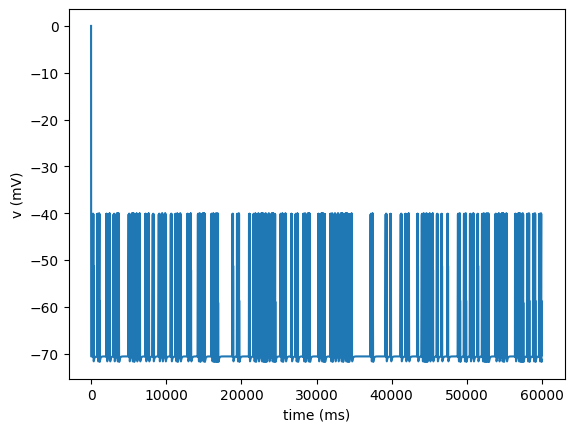

1


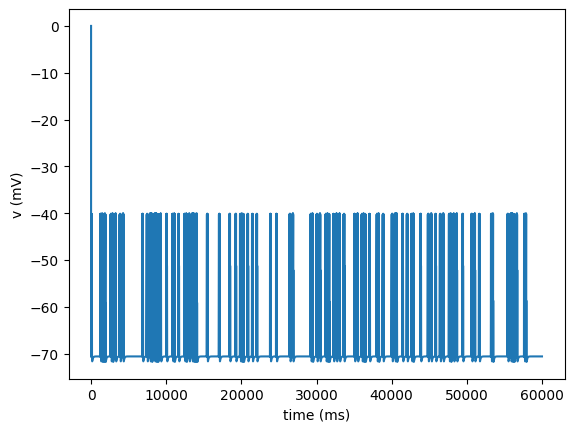

2


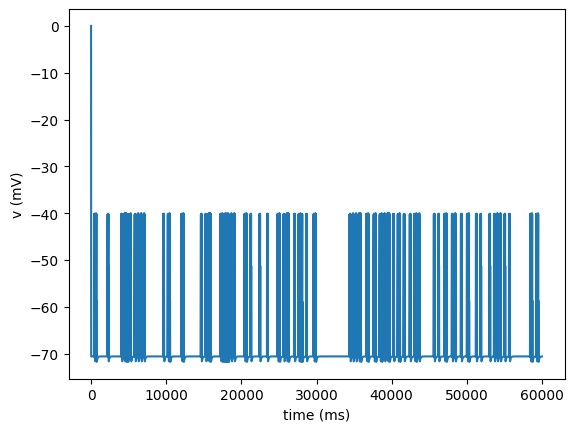

3


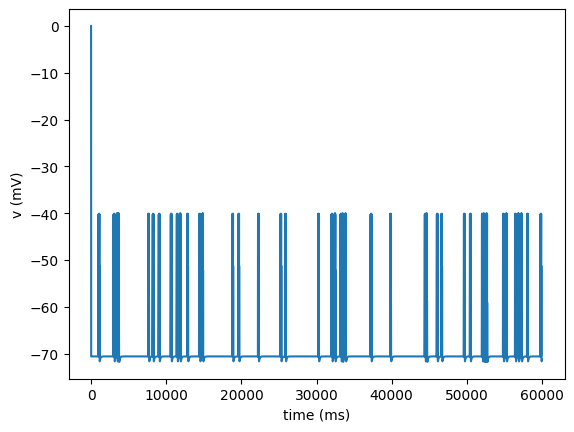

4


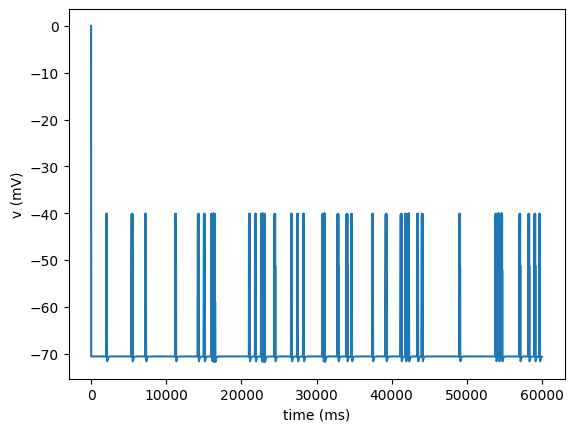

5


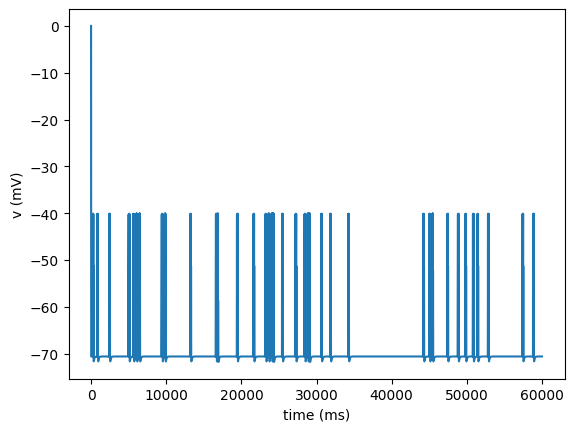

6


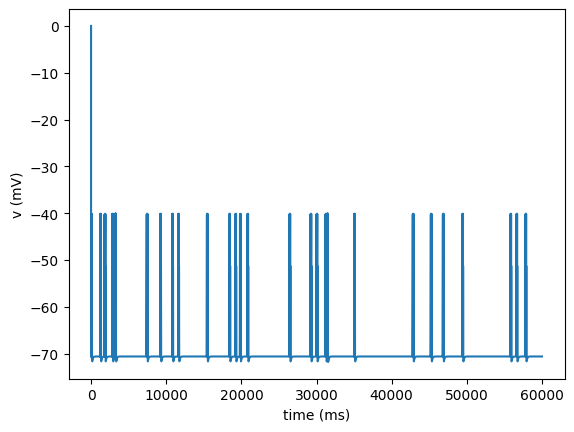

7


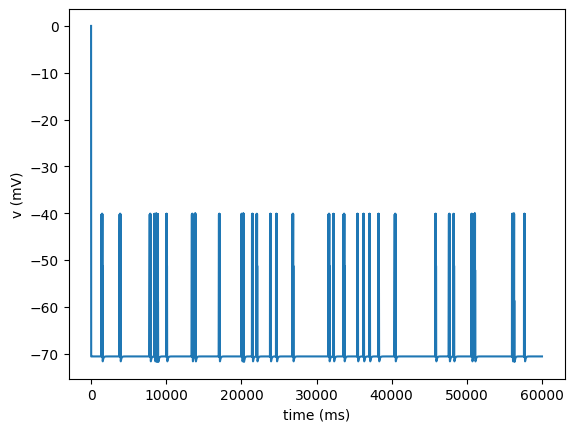

8


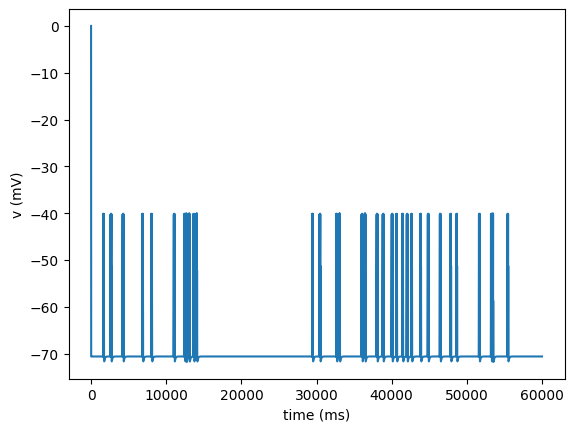

9


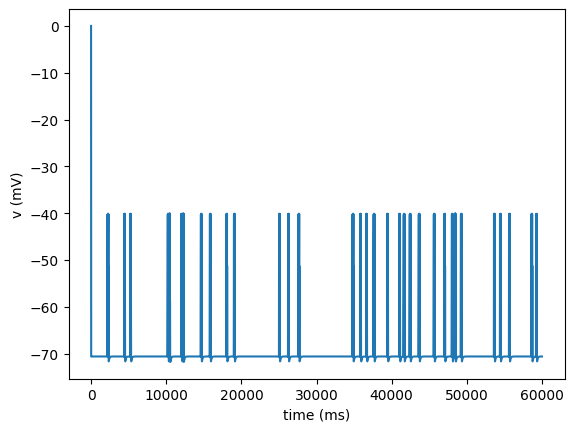

10


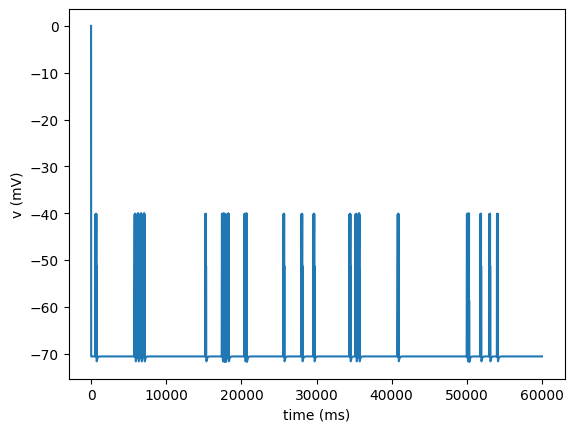

11


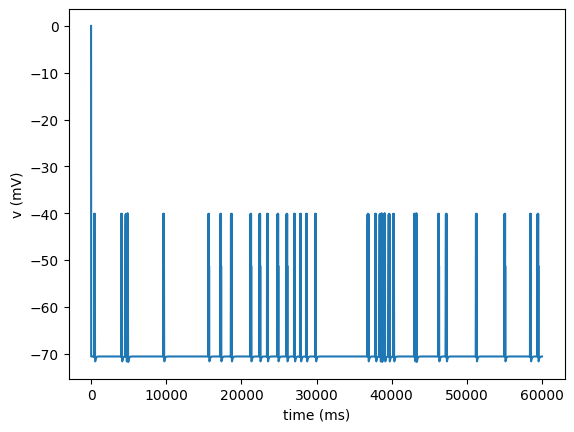

12


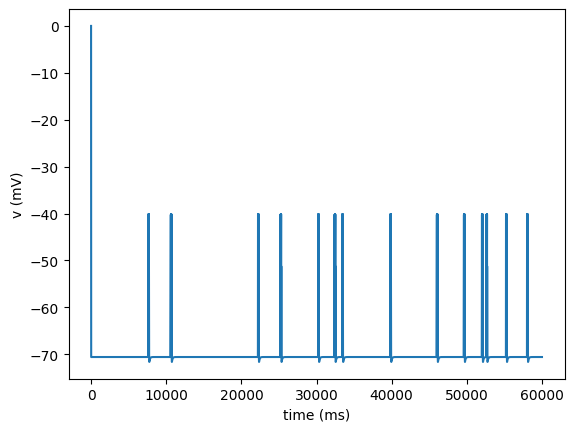

13


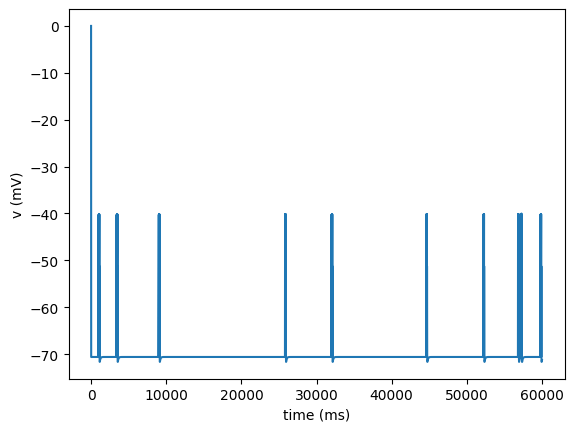

14


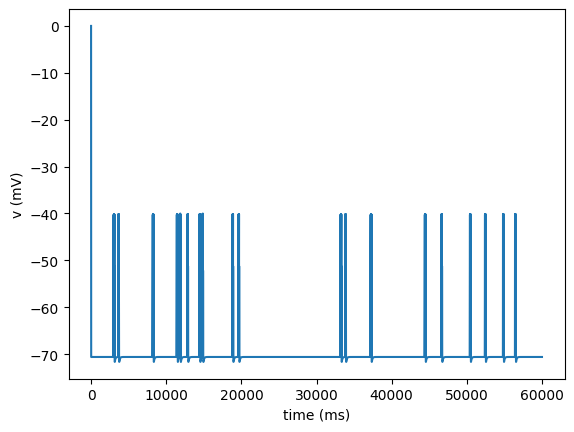

15


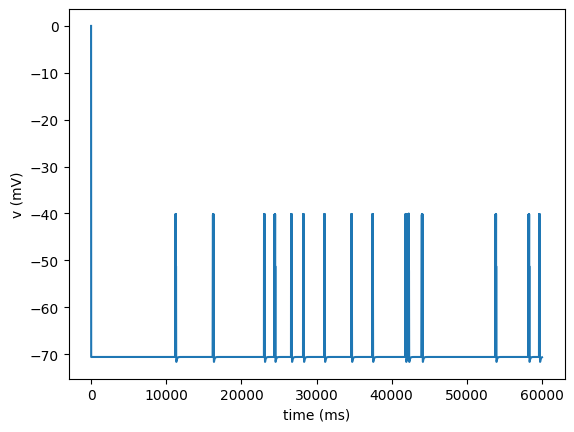

16


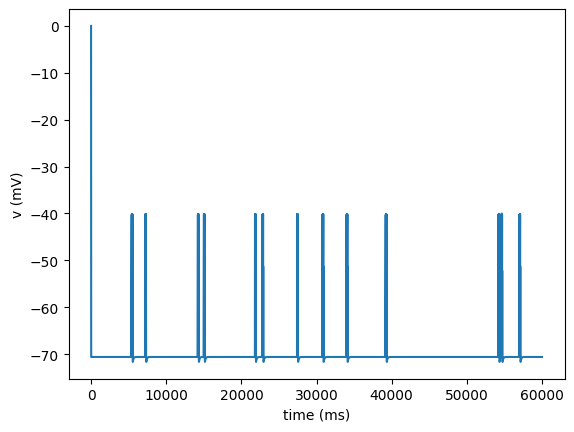

17


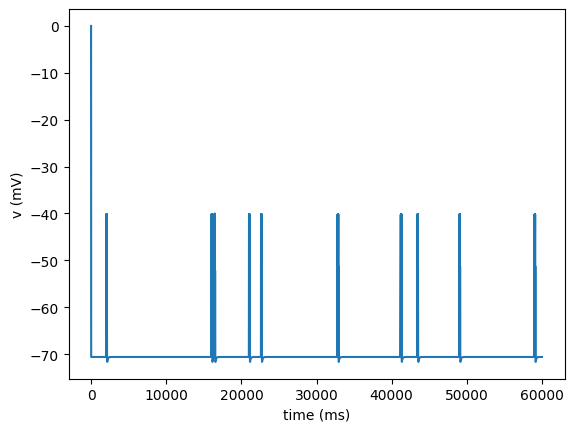

18


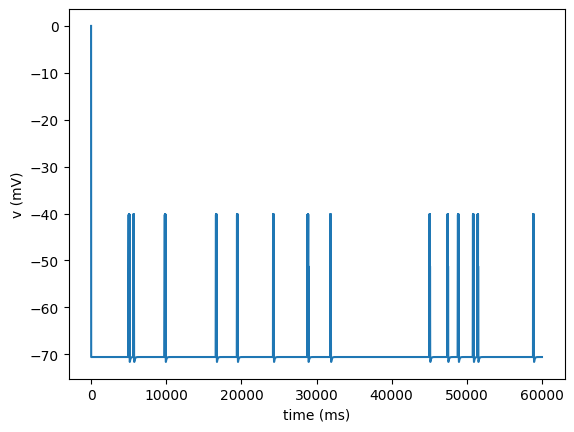

19


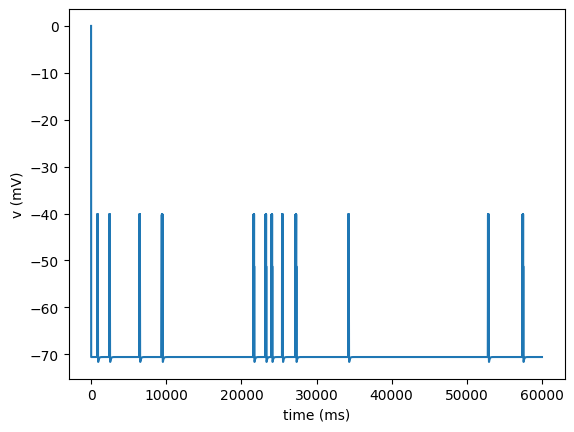

20


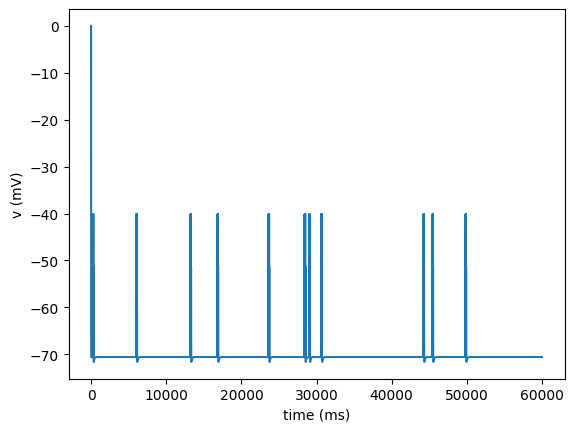

21


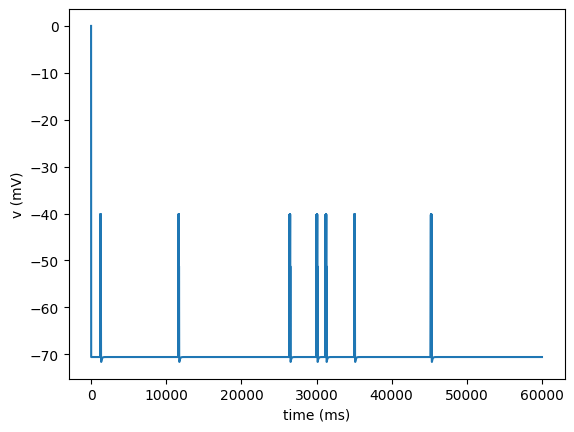

22


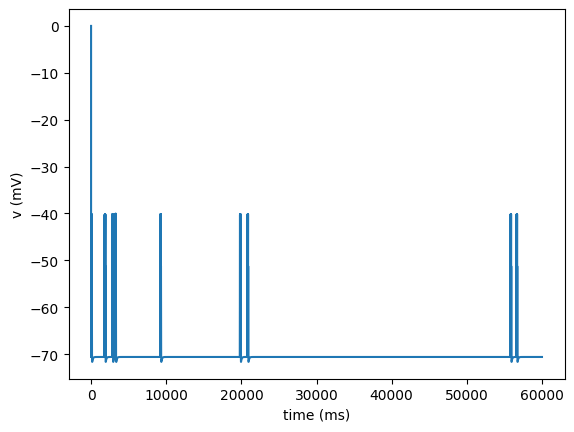

23


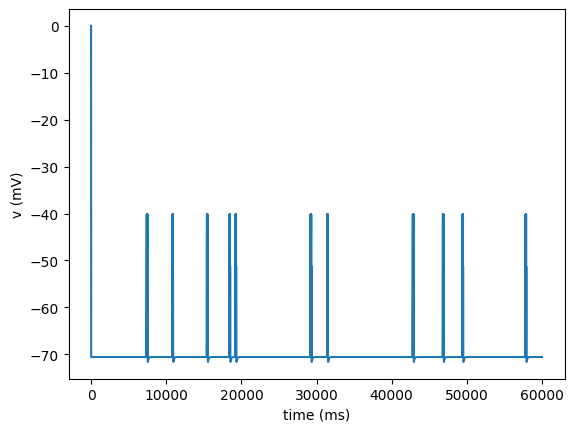

24


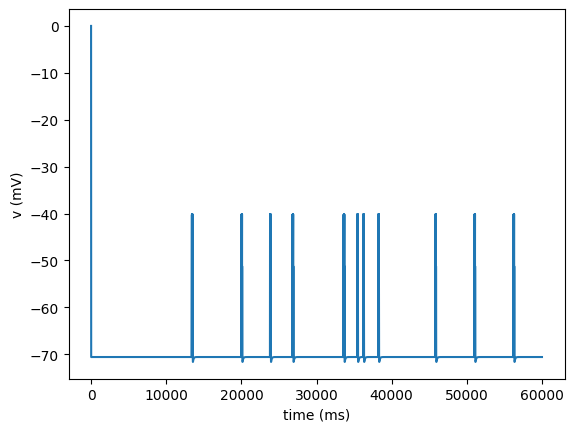

25


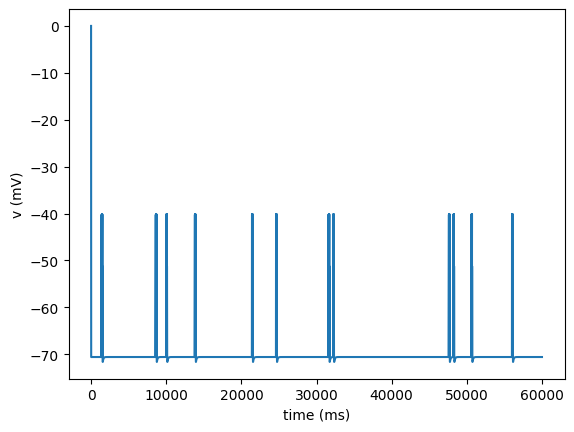

26


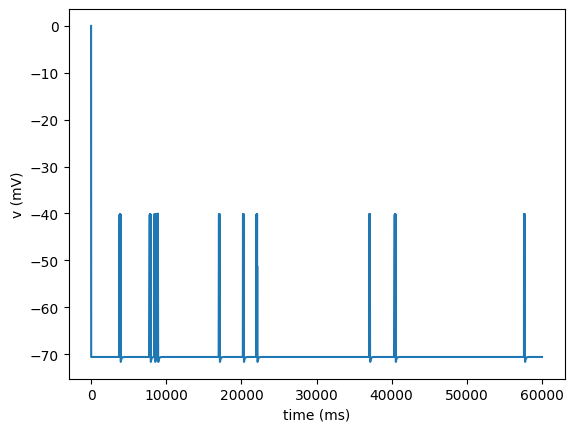

27


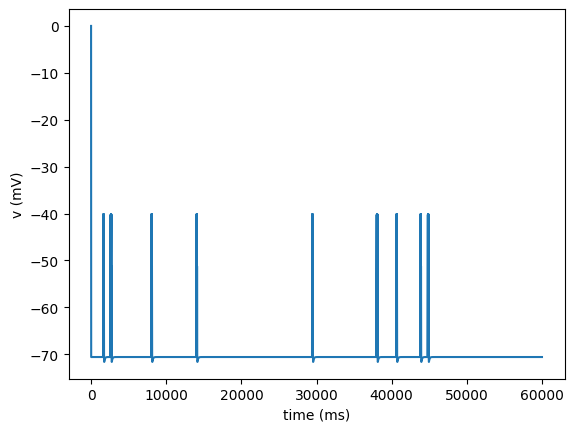

28


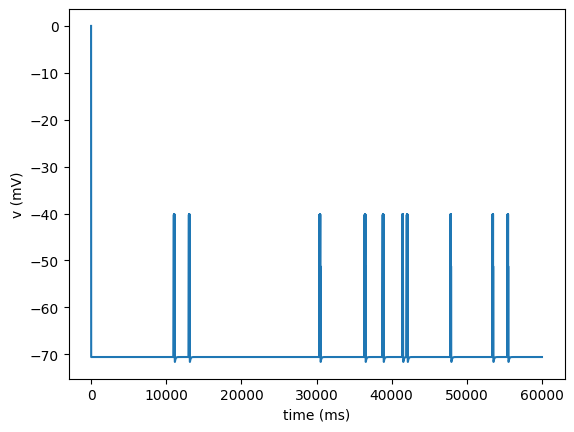

29


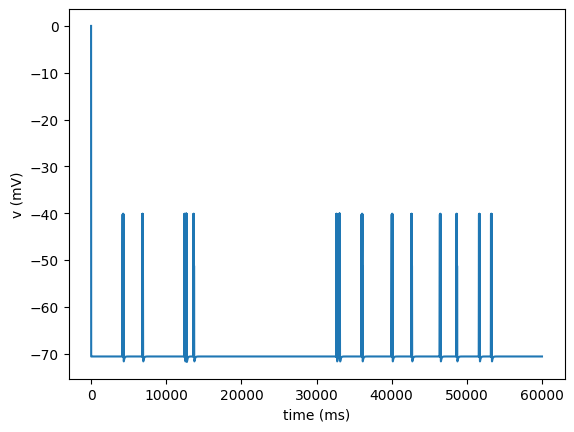

30


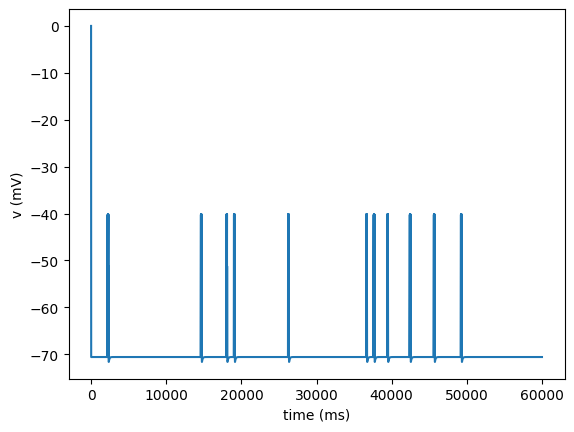

31


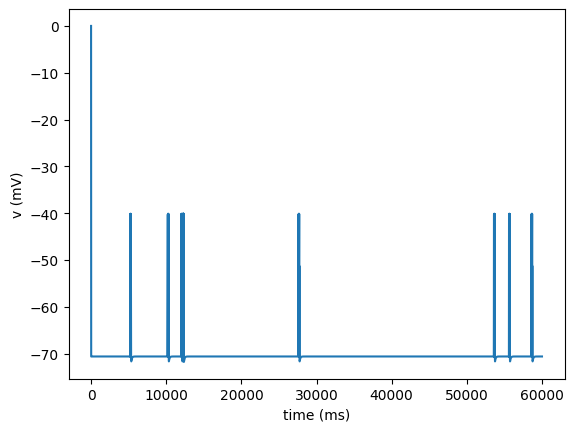

32


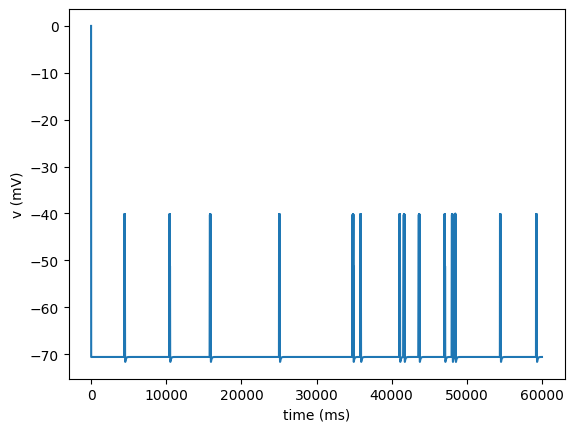

33


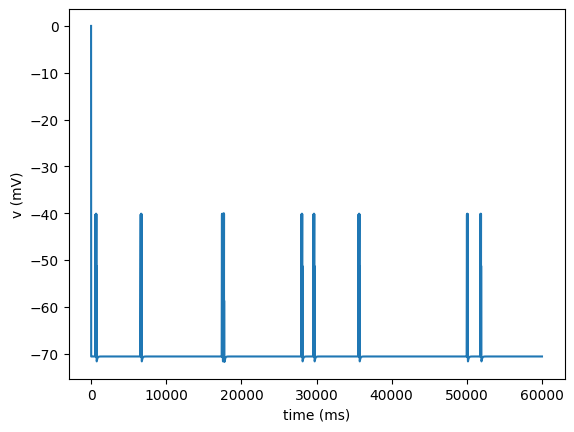

34


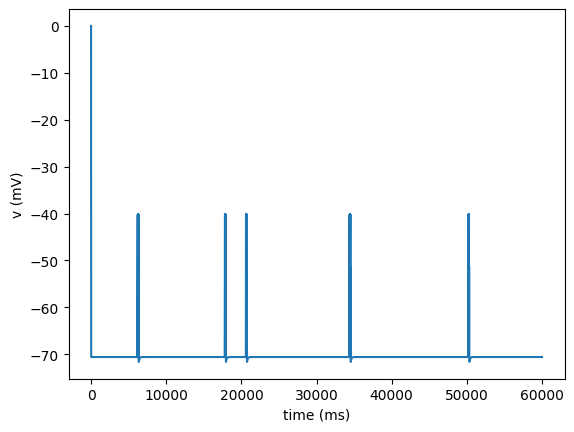

35


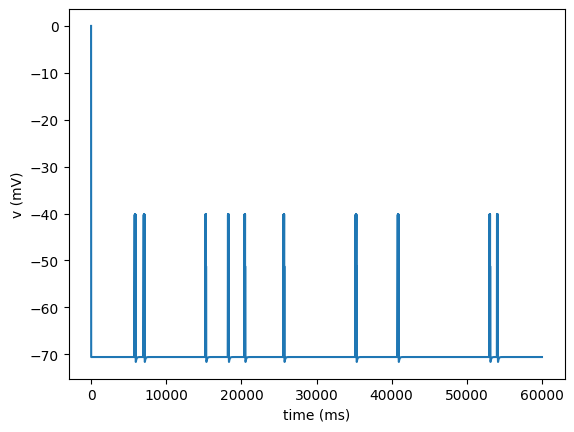

36


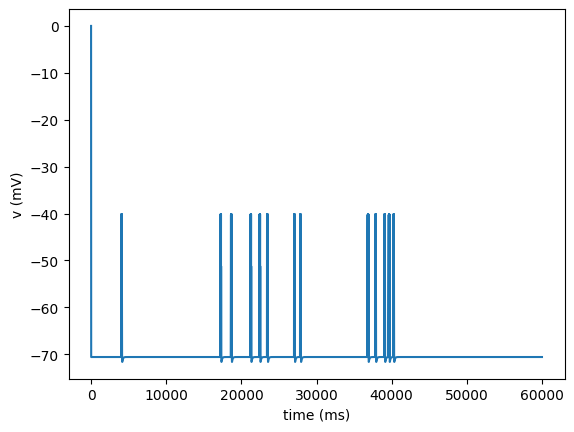

37


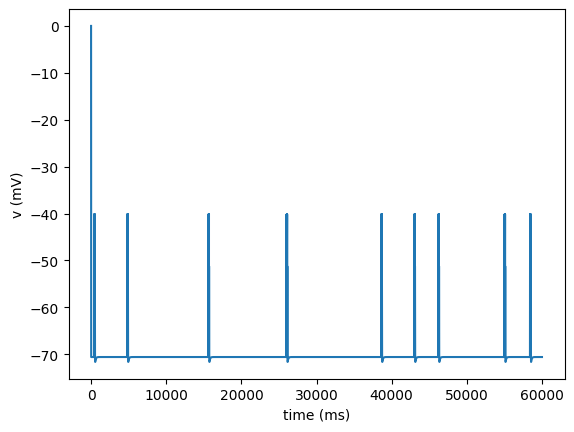

38


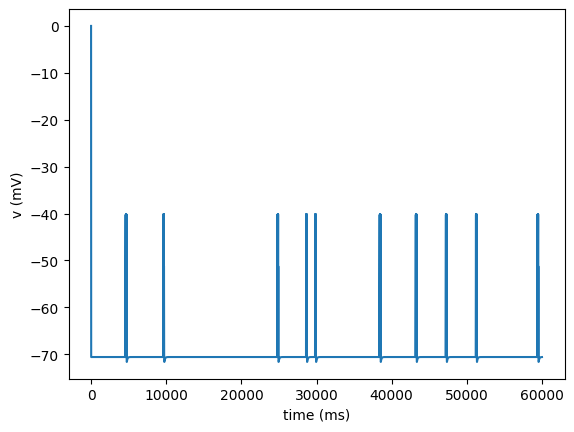

39


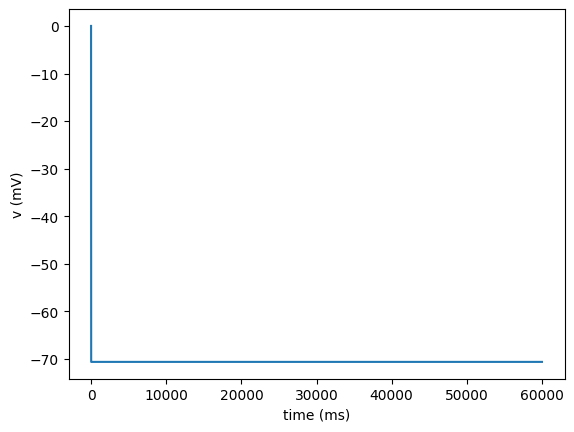

40


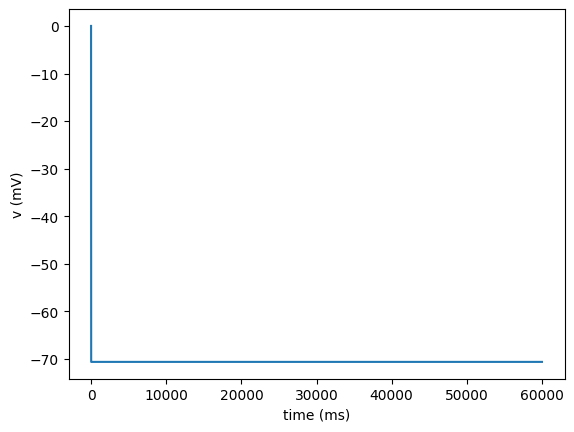

41


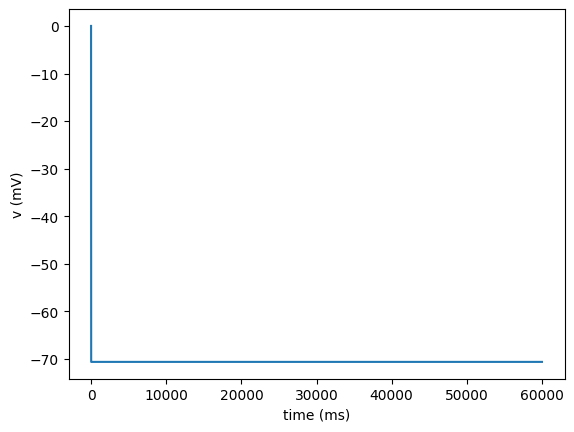

42


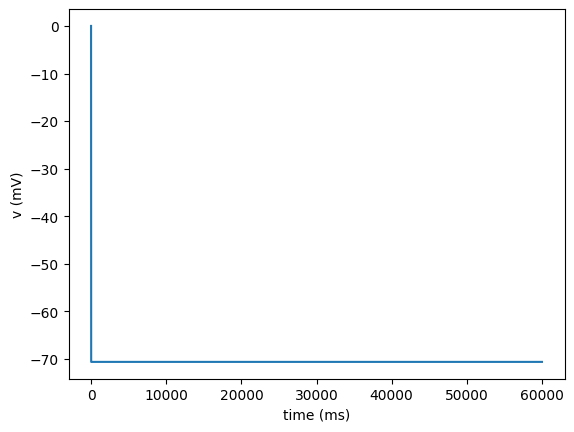

43


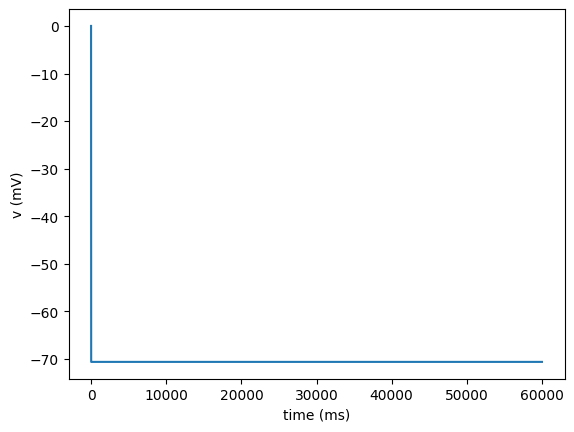

44


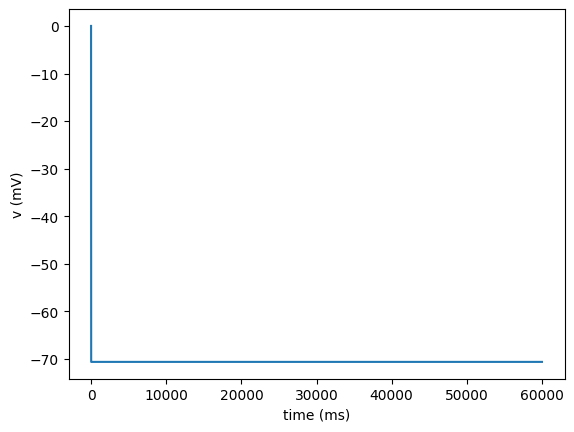

45


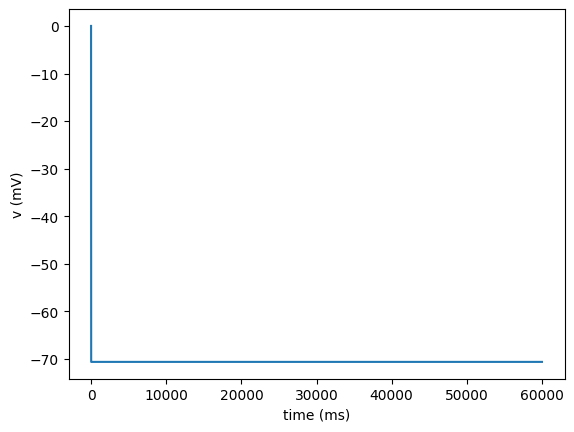

46


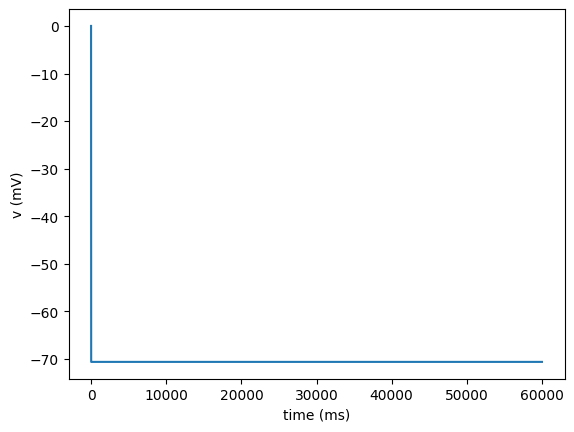

47


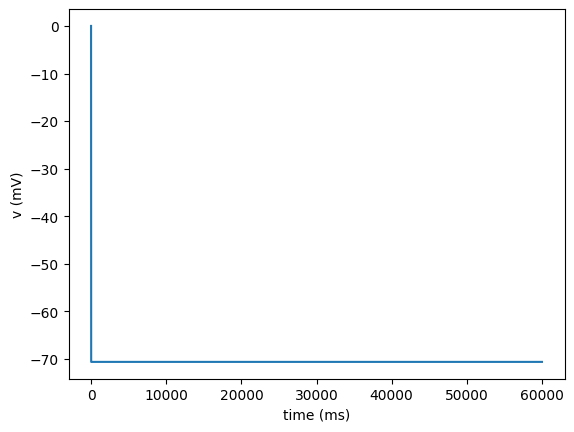

48


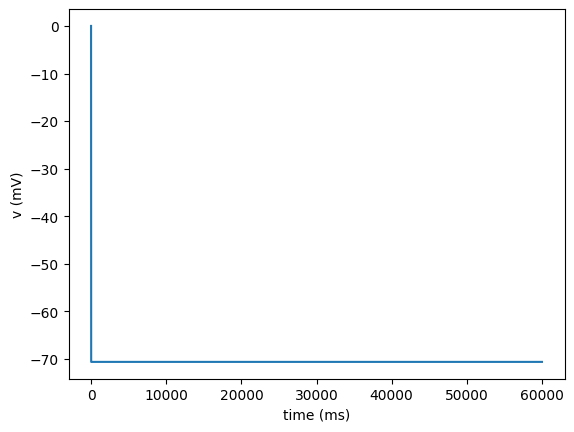

49


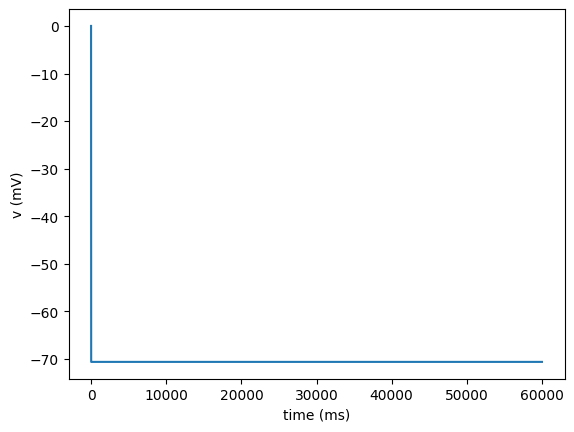

50


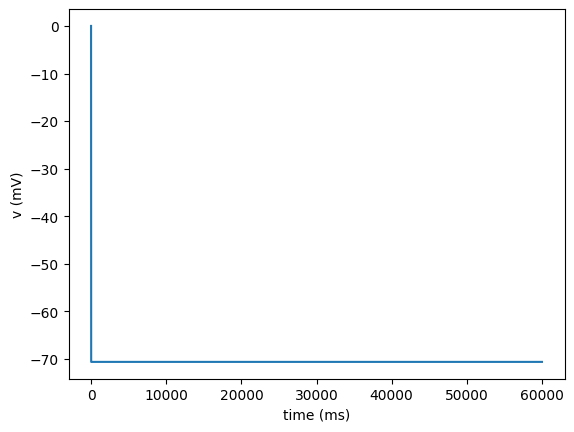

51


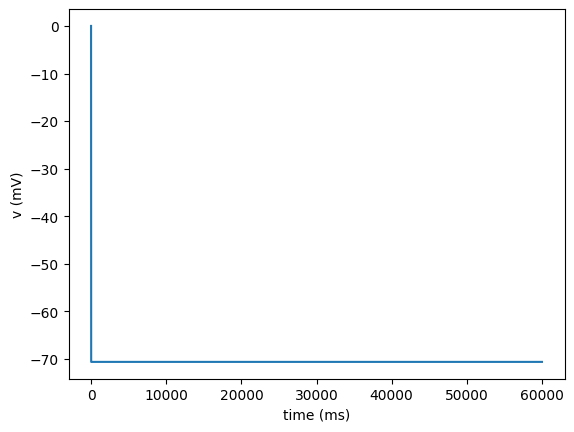

52


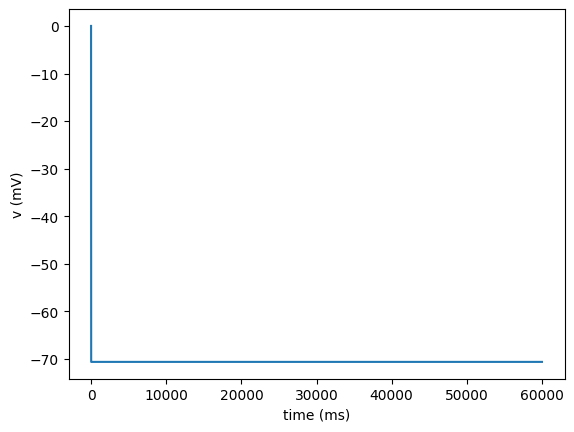

53


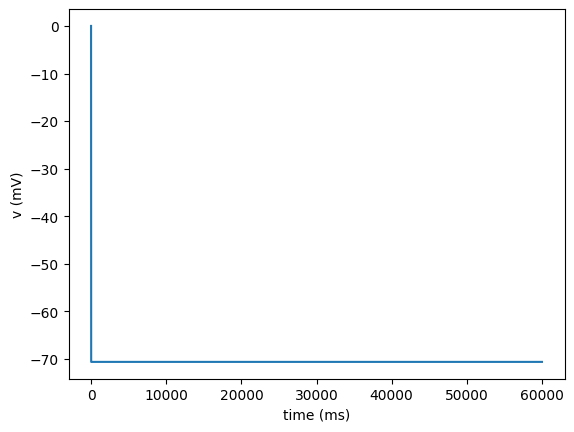

54


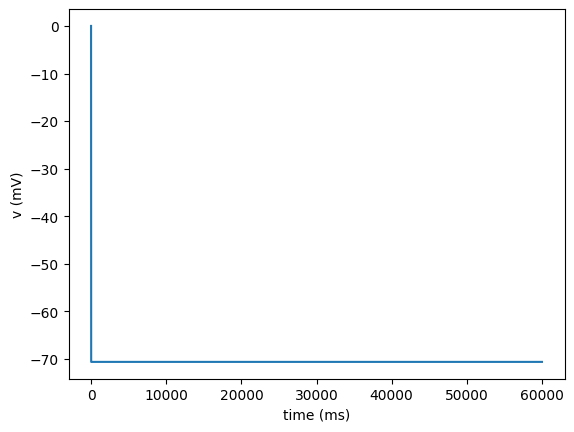

55


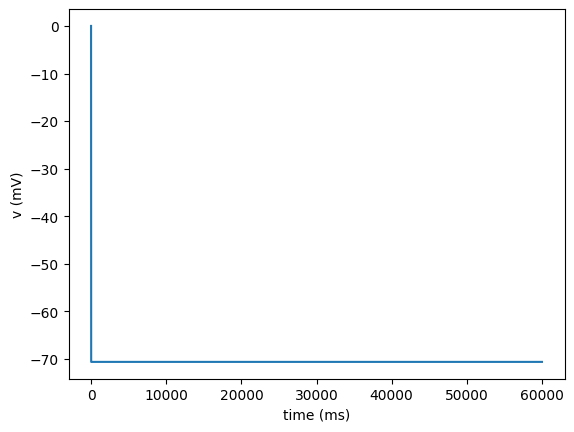

56


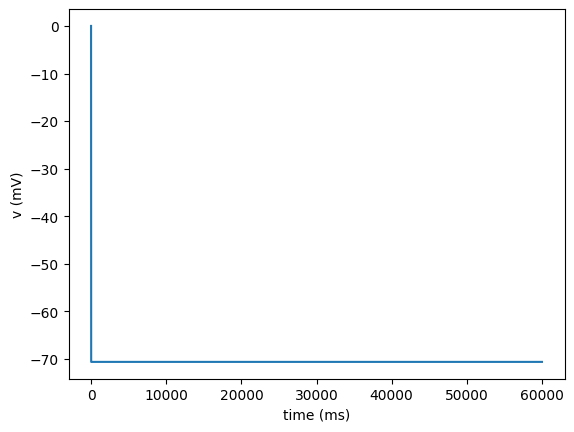

57


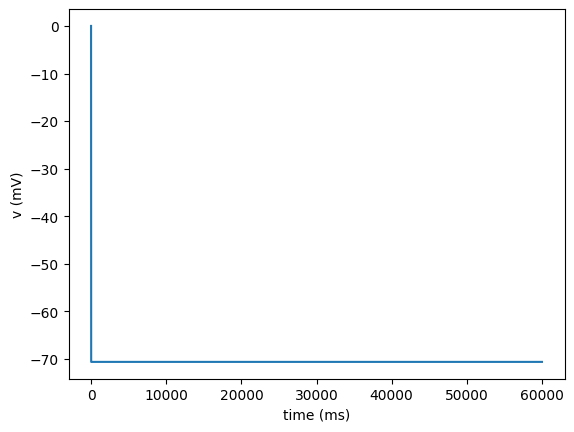

58


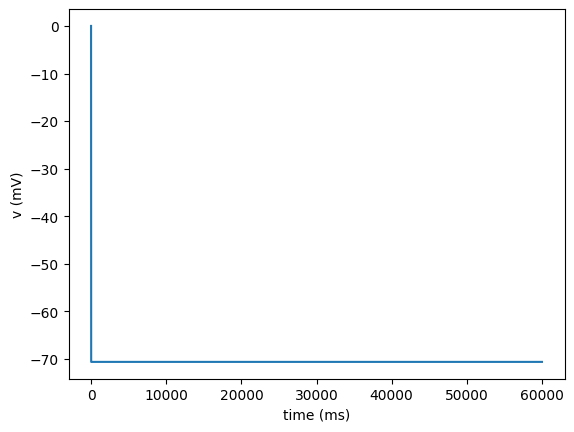

59


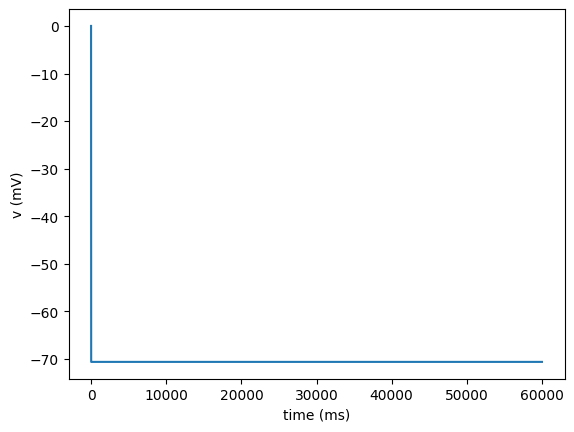

60


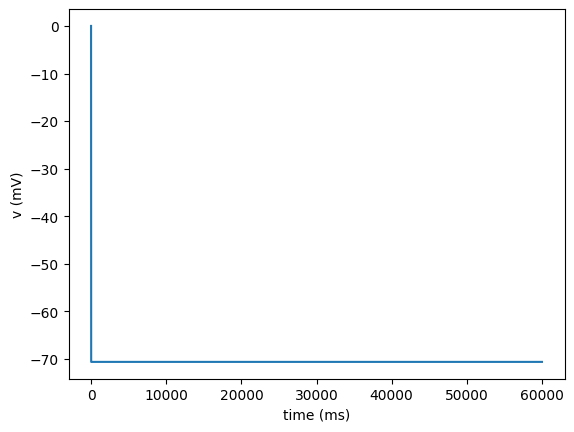

61


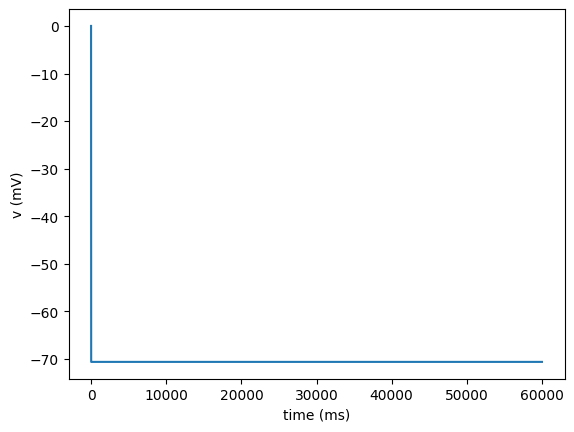

62


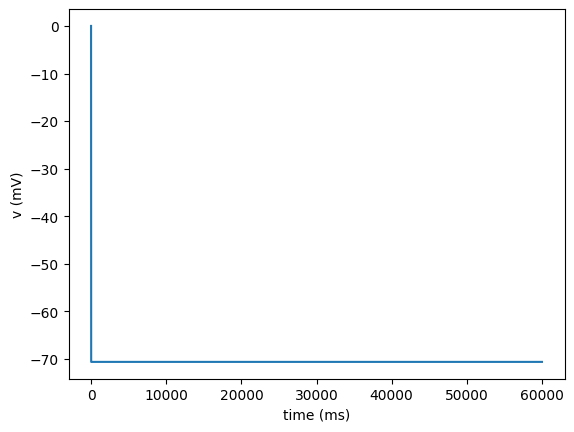

63


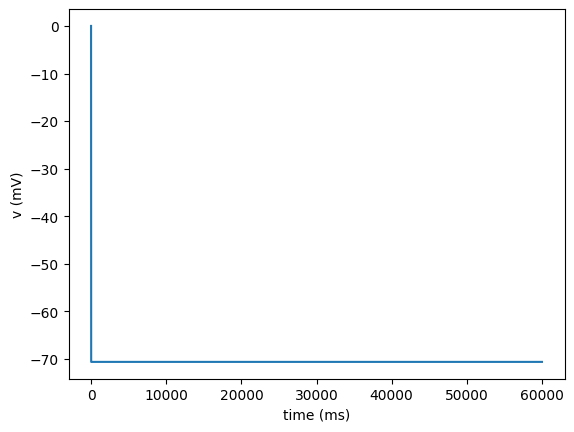

64


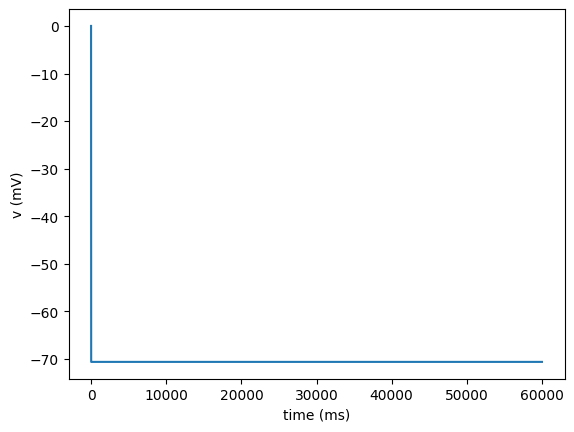

65


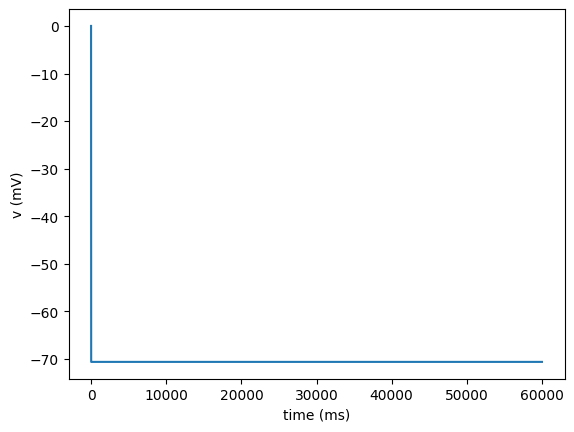

66


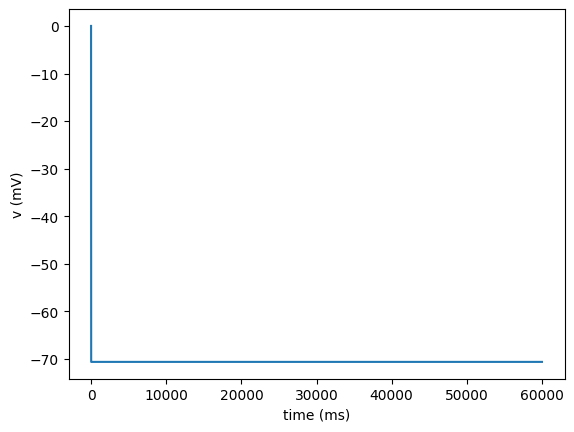

67


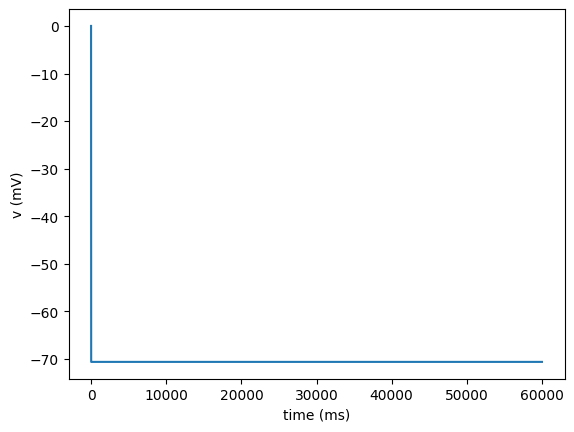

68


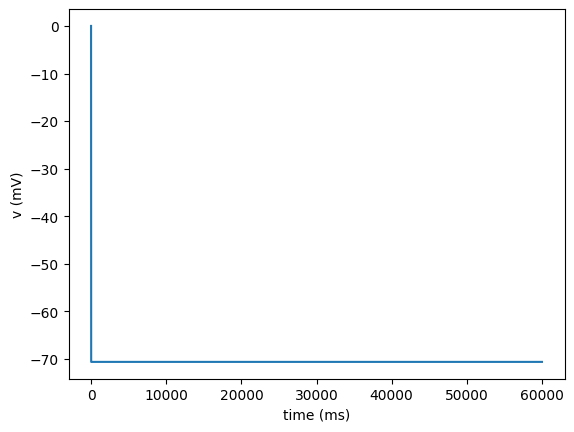

69


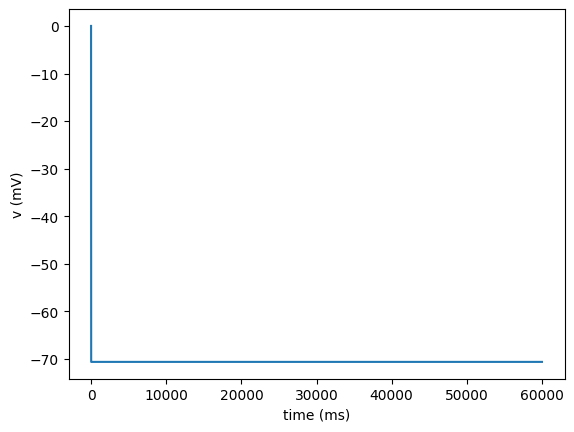

70


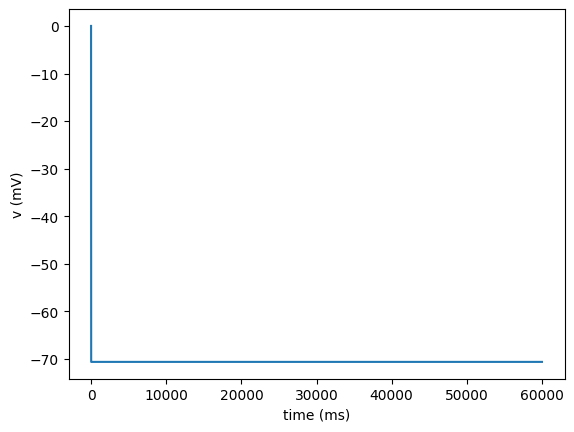

71


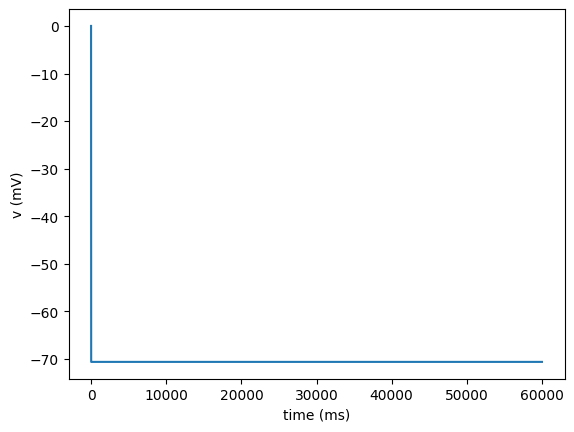

72


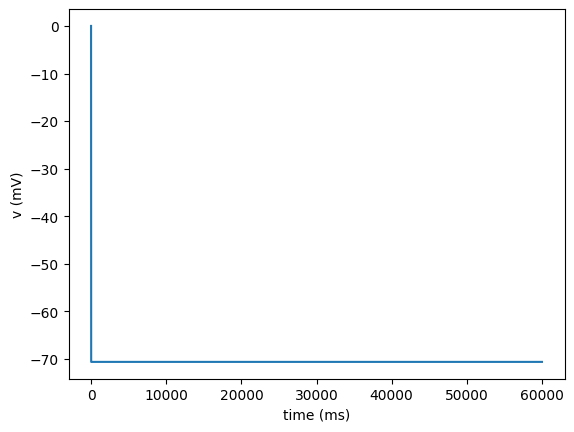

73


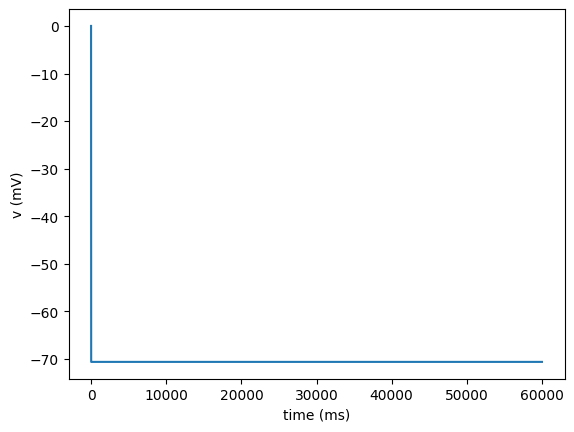

74


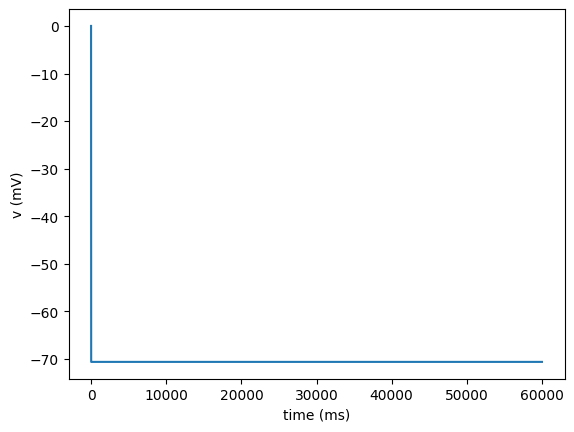

75


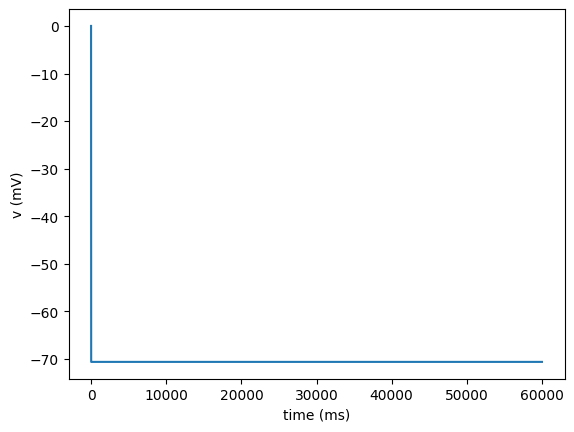

76


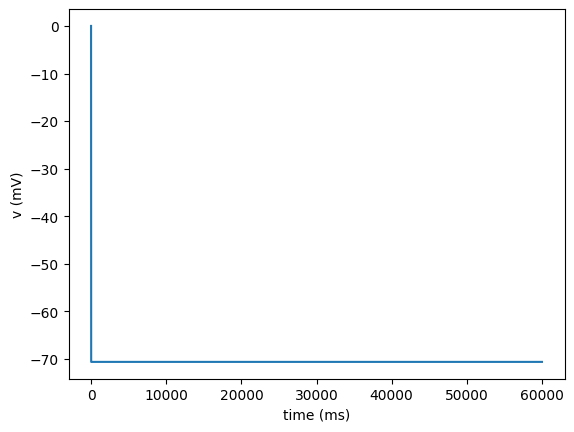

77


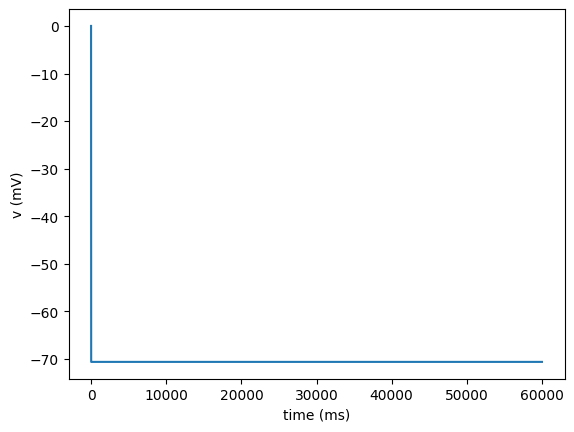

78


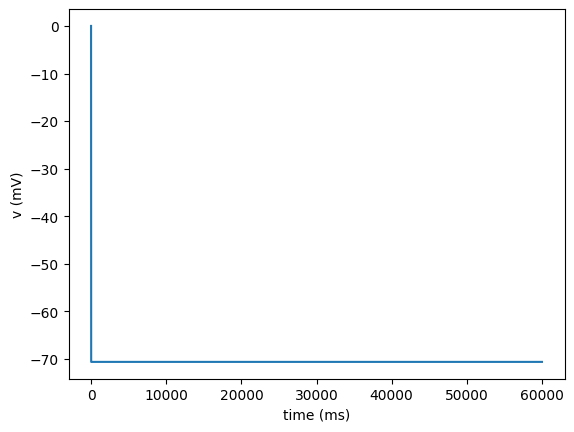

79


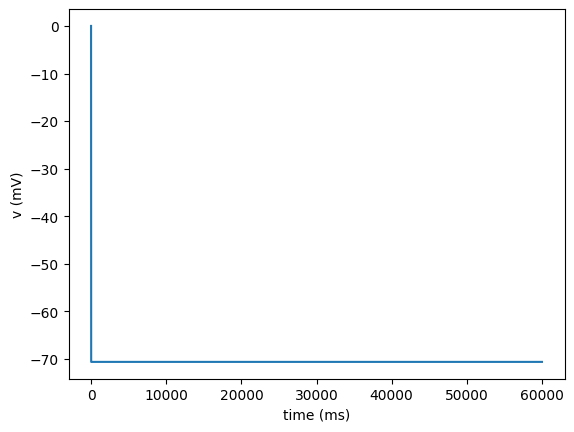

80


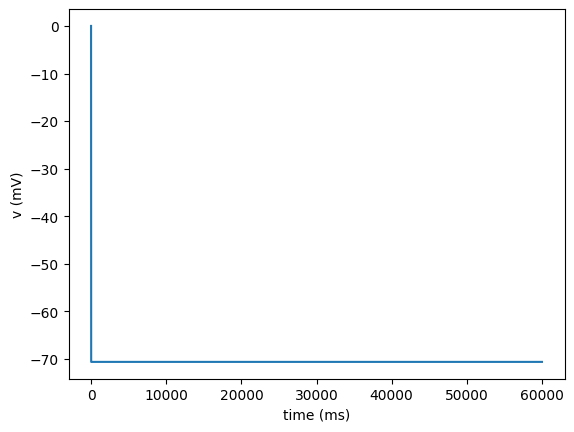

81


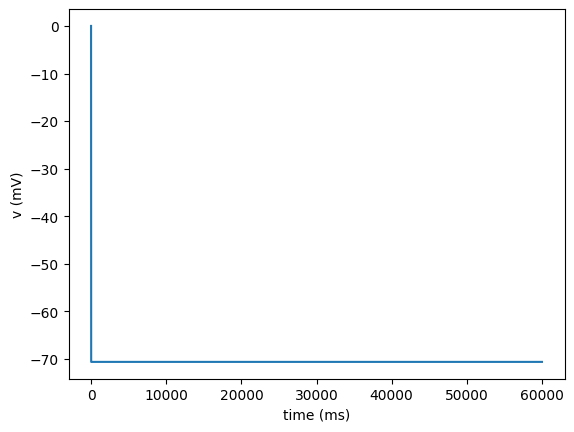

82


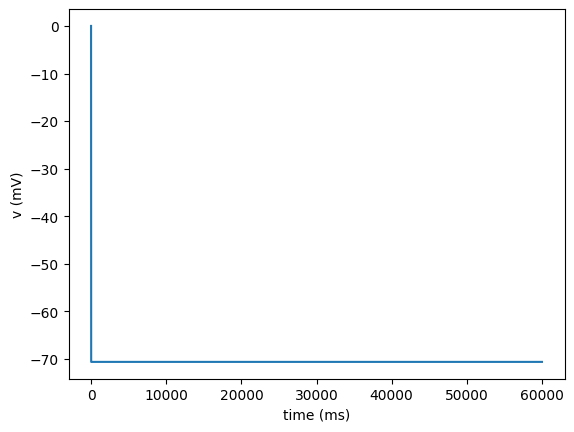

83


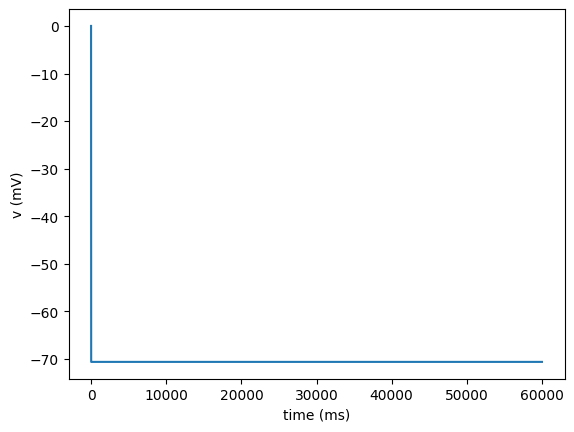

84


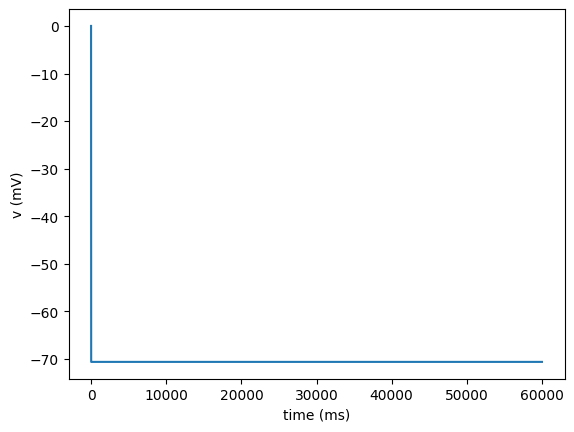

85


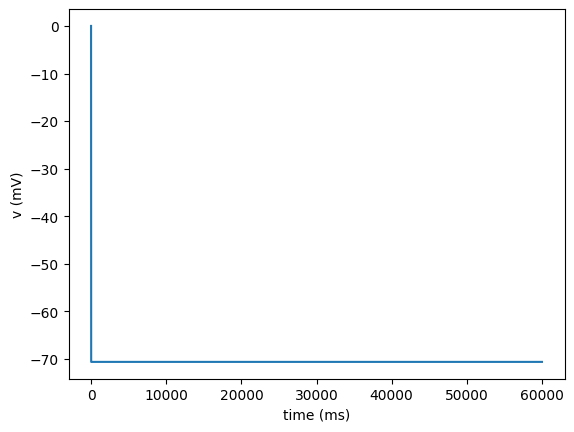

86


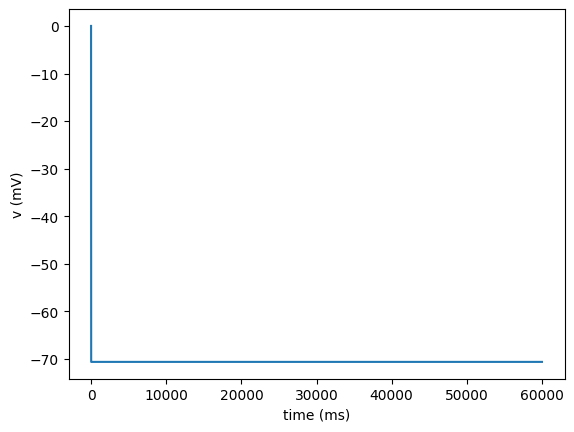

87


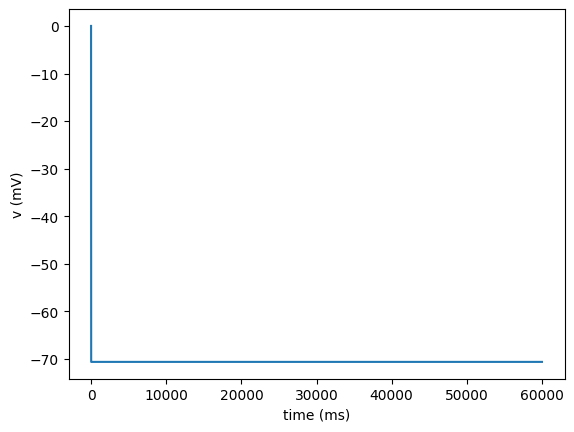

88


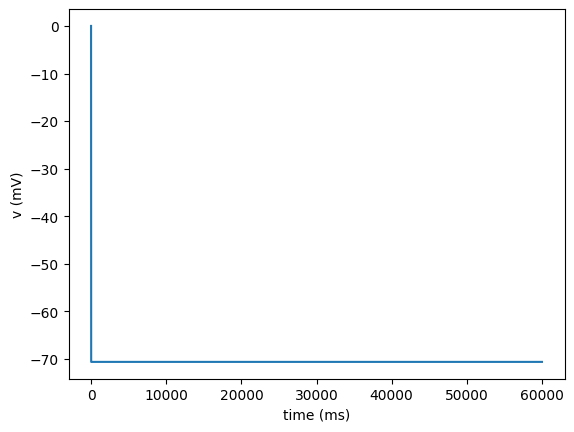

89


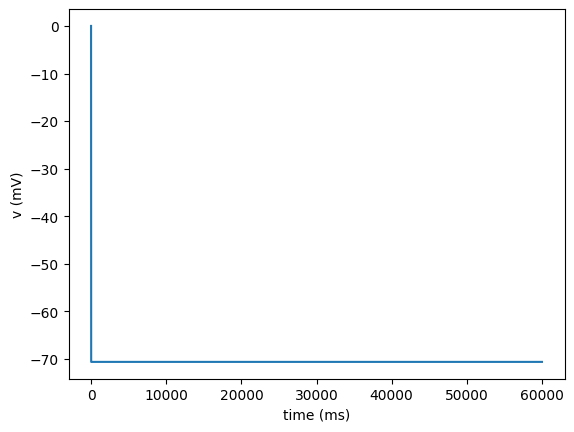

90


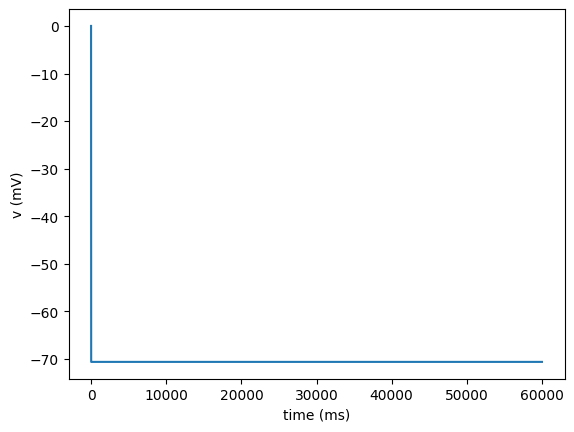

91


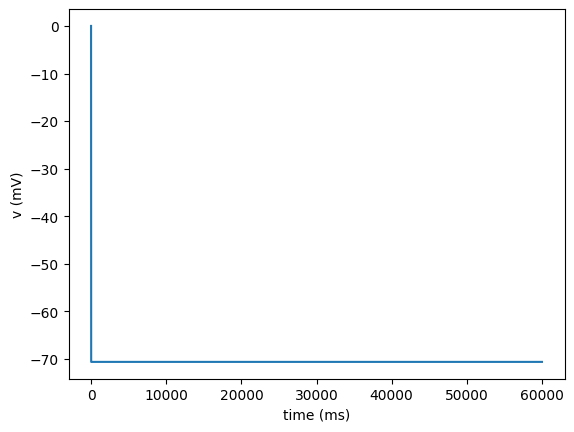

92


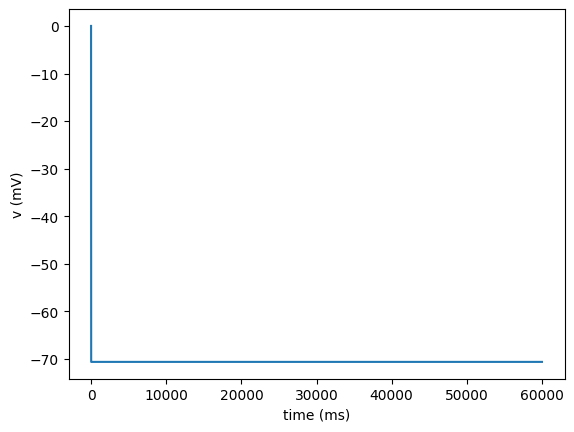

93


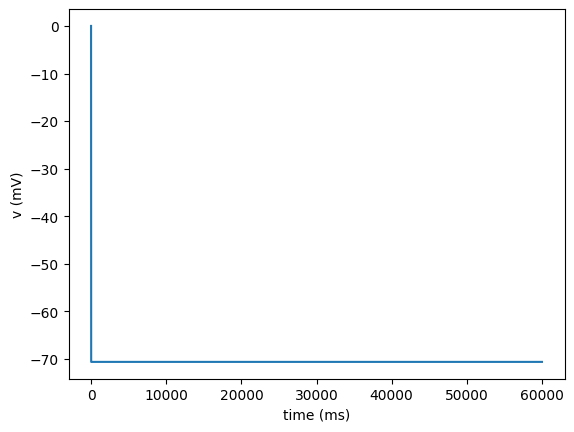

94


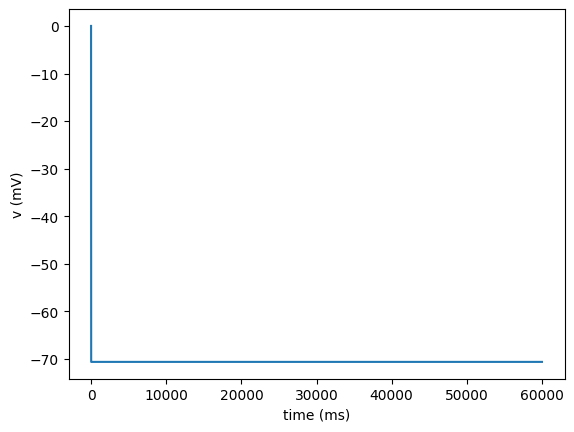

95


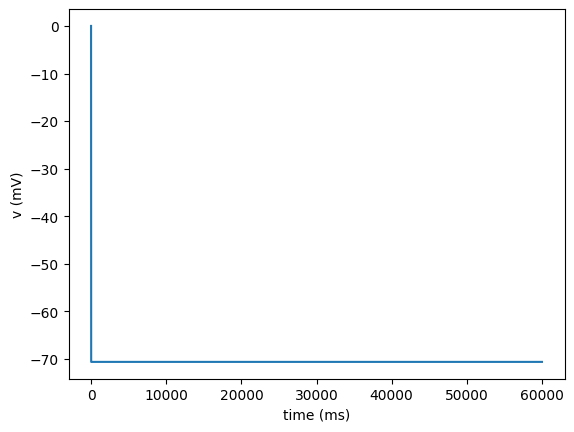

96


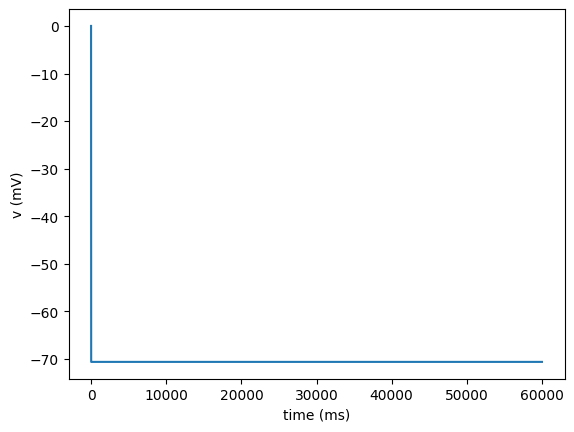

97


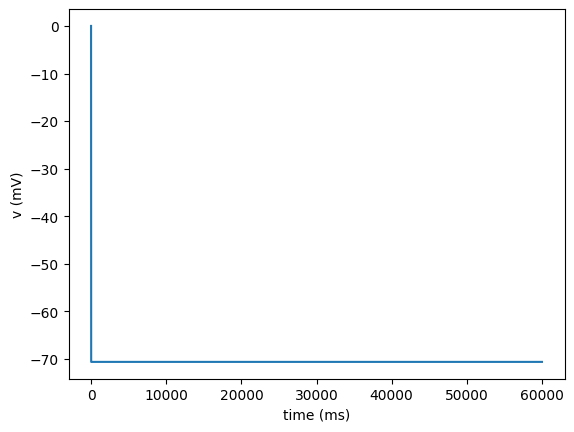

98


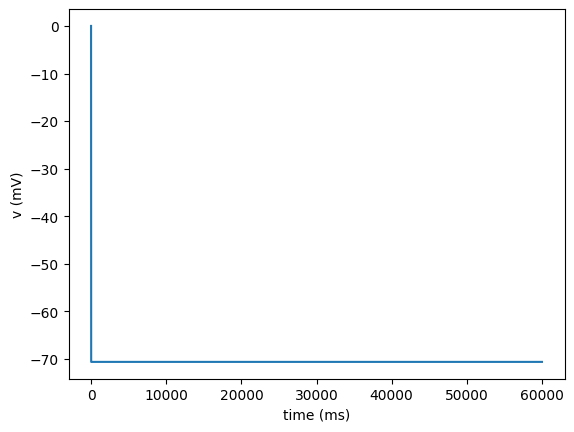

99


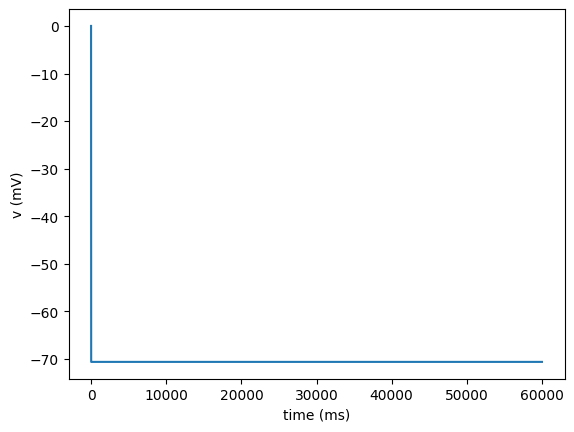

100


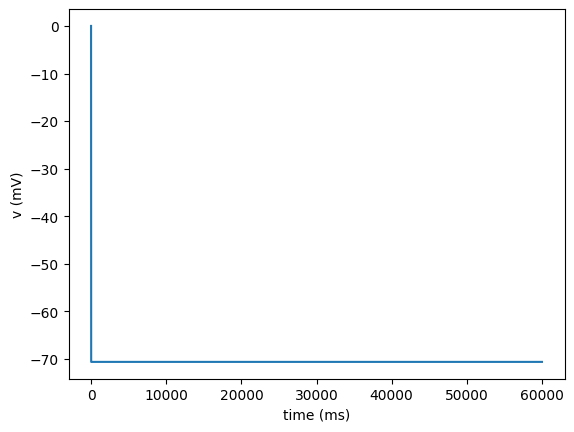

101


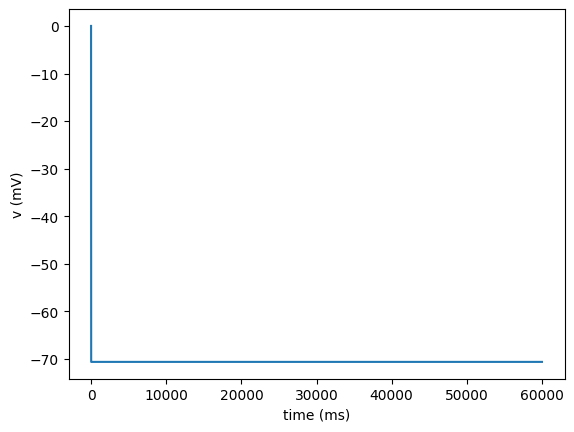

102


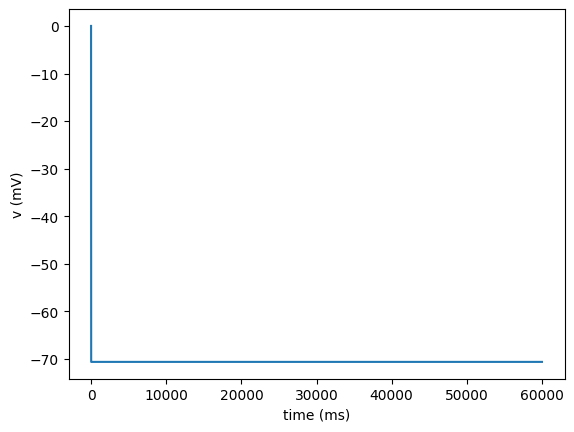

103


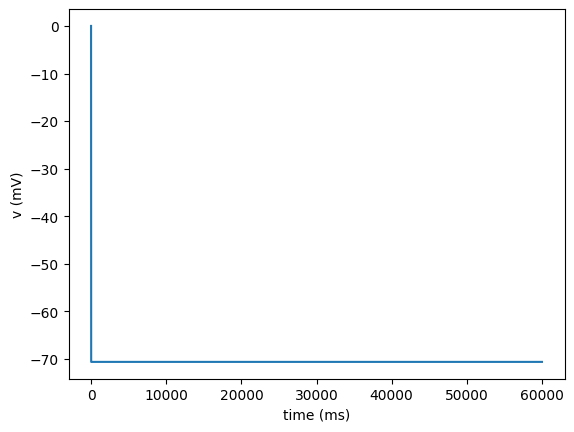

104


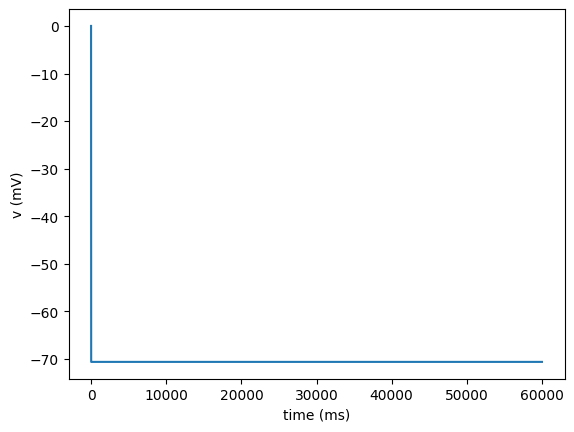

105


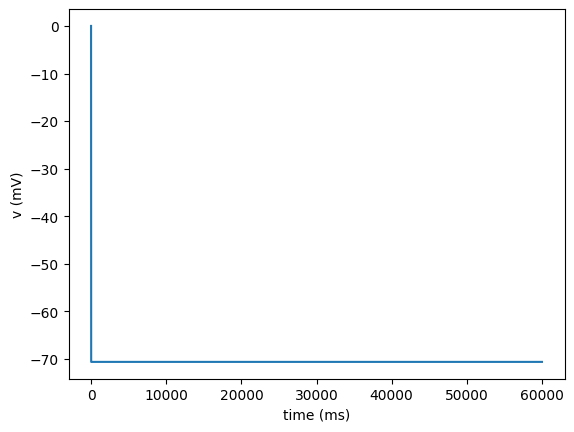

106


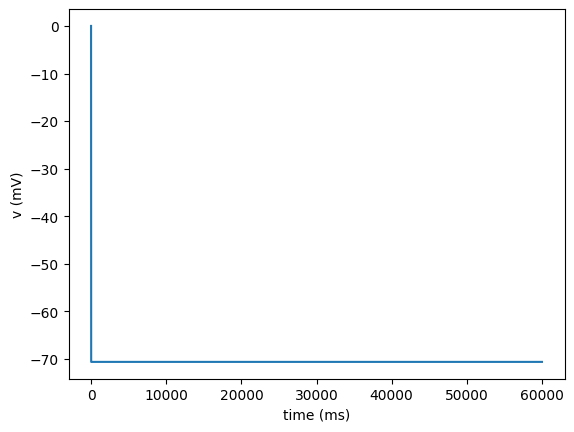

107


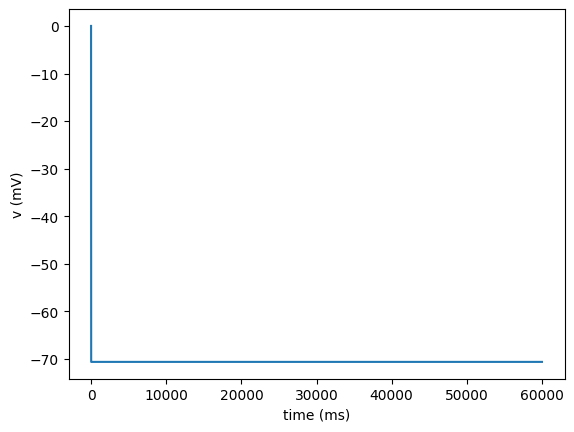

108


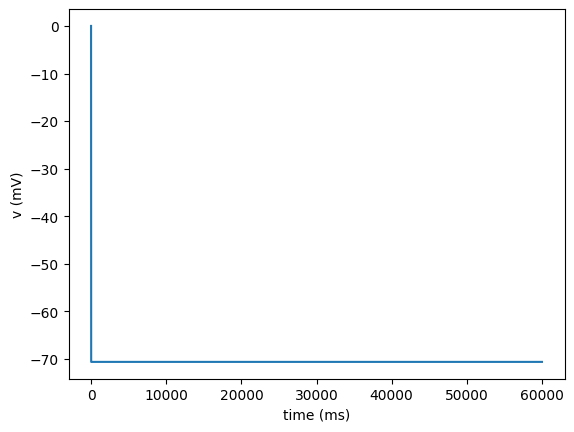

109


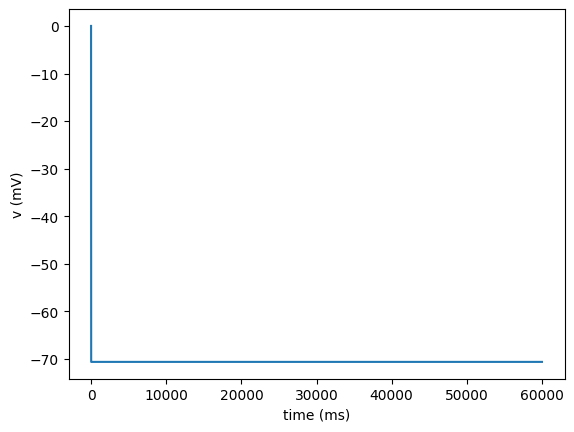

110


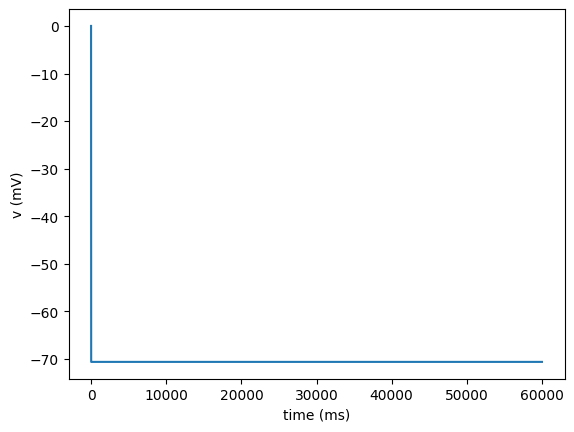

111


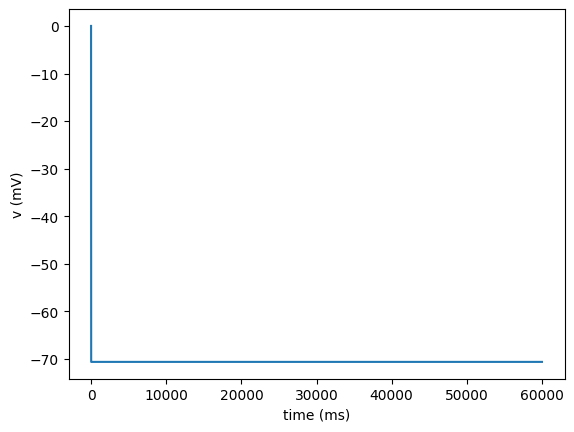

112


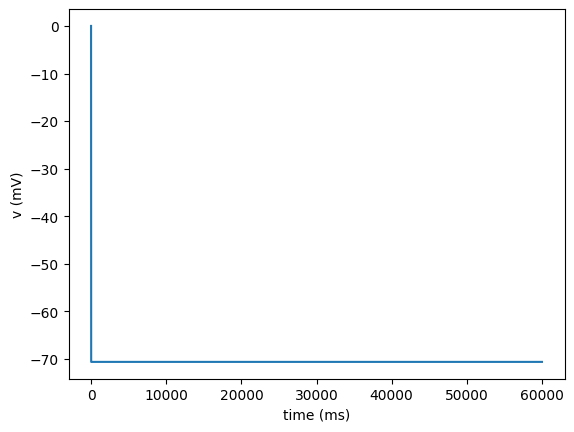

113


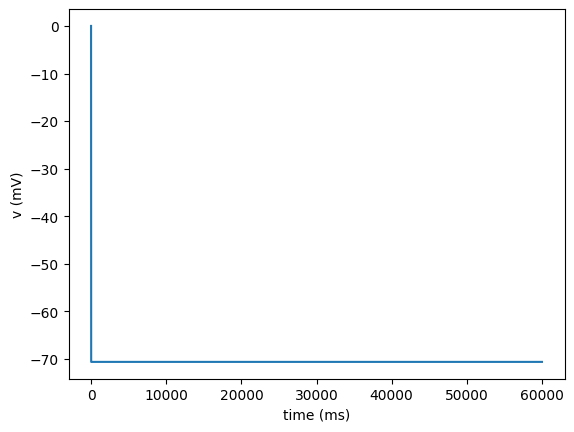

114


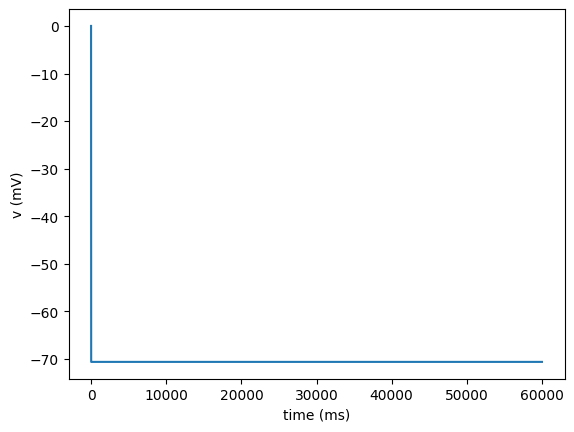

115


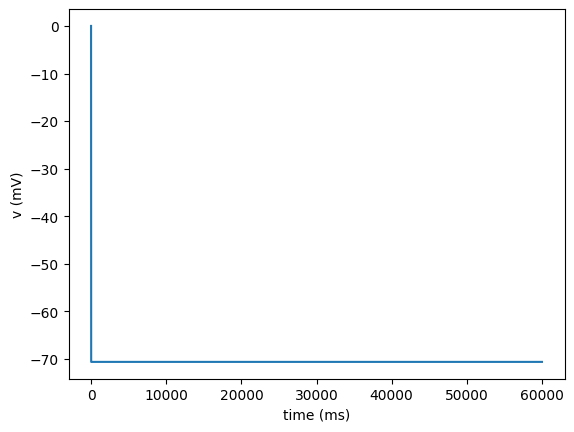

116


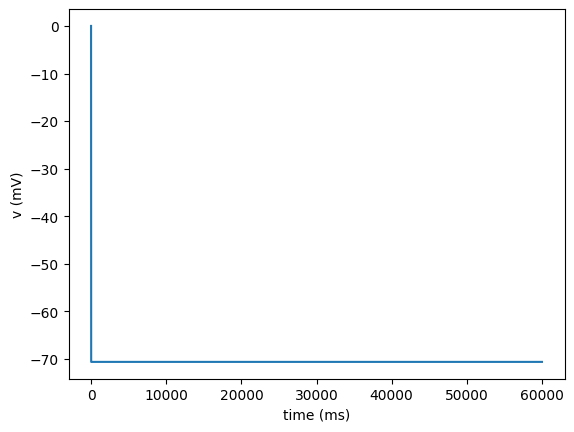

117


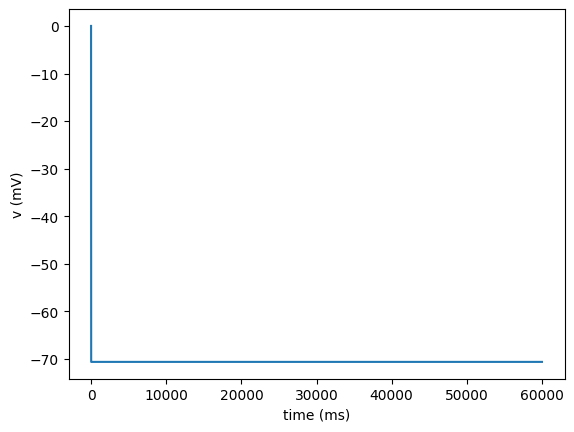

118


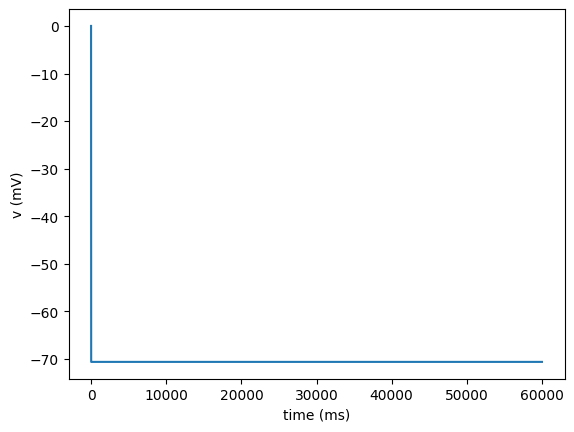

119


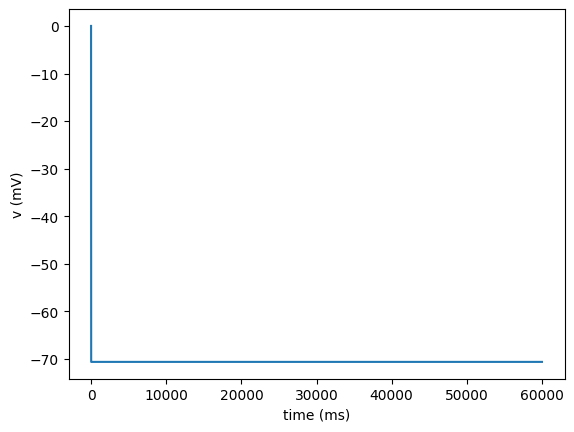

120


IndexError: Index number 120 has not been recorded

In [7]:
for ii in range(150):
    print(ii)
    b2t.brian_plot(net[keys[0]][ii])
    plt.show()

<Axes: xlabel='time (ms)', ylabel='I_tot (A)'>

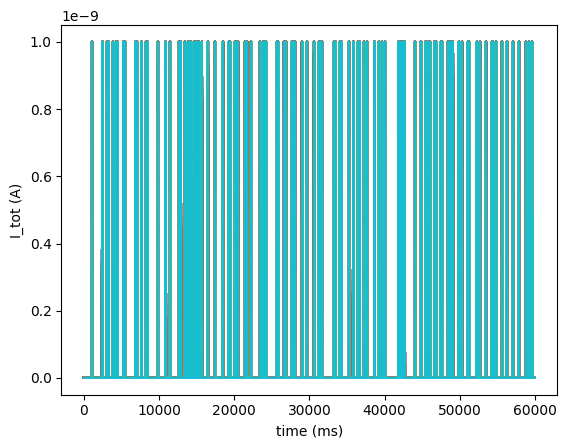

In [3]:
b2t.brian_plot(net[keys[1]])

<Axes: xlabel='time (ms)', ylabel='X (V)'>

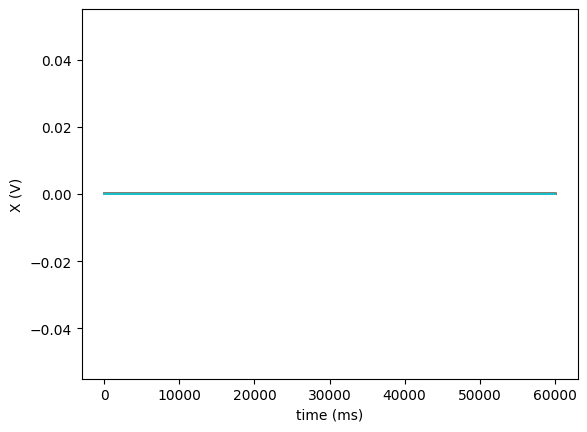

In [4]:
b2t.brian_plot(net[keys[2]])

<Axes: xlabel='time (ms)', ylabel='Y (V)'>

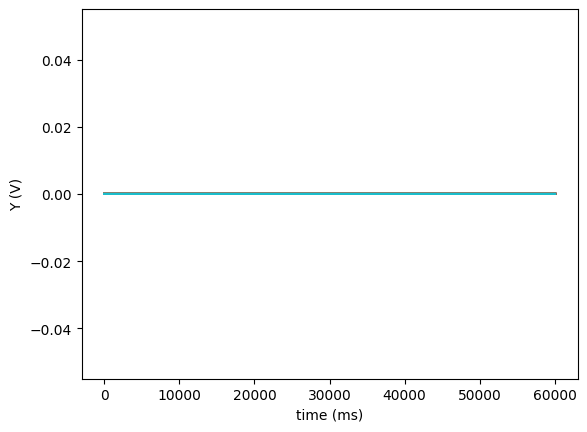

In [5]:
b2t.brian_plot(net[keys[3]])

INFO:root:creating /tmp/brian_flag_test_b_tyne75/tmp/brian_flag_test_b_tyne75
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/brian_flag_test_b_tyne75/flag_test.cpp -o /tmp/brian_flag_test_b_tyne75/tmp/brian_flag_test_b_tyne75/flag_test.o -w
INFO:root:creating /tmp/brian_flag_test_gpvhur5a/tmp/brian_flag_test_gpvhur5a
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/brian_flag_test_gpvhur5a/flag_test.cpp -o /tmp/brian_flag_test_gpvhur5a/tmp/brian_flag_test_gpvhur5a/flag_test.o -O3
INFO:root:creating /tmp/brian_flag_test__j1wdafy/tmp/brian_flag_test__j1wdafy
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwr

spikemonitor
NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')


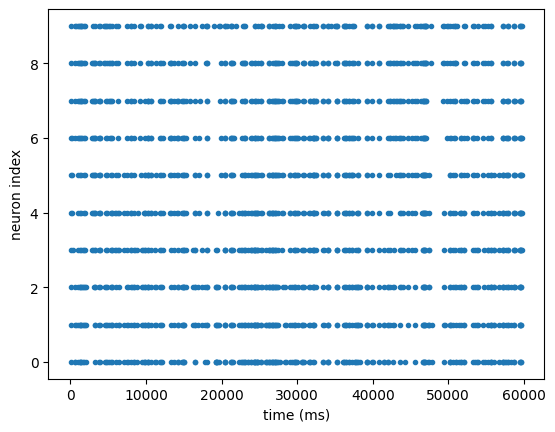

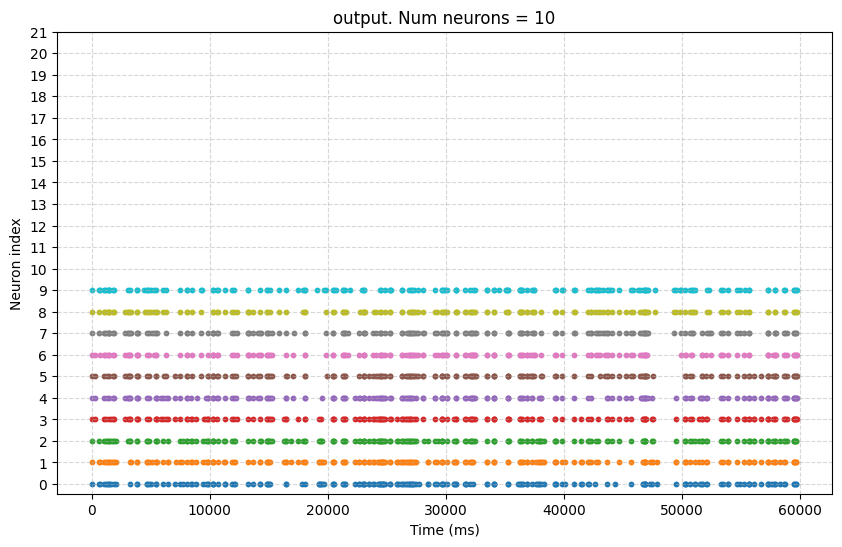

In [ ]:

import os

import time
import torch
import datetime
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils




from brian2 import prefs
#from brian2 import set_device
from brian2.devices import device_module

import brian2cuda
from brian2cuda import *

import brian2tools as b2t


set_device("cpp_standalone", directory='project', build_on_run=False)

device = b2.get_device()


#set_device("cuda_standalone", build_on_run=True)
# Set specific preferences for CUDA standalone


prefs.devices.cuda_standalone.cuda_backend.cuda_runtime_version = (12.2)
prefs.devices.cuda_standalone.profile_statemonitor_copy_to_host = None
prefs.devices.cuda_standalone.cuda_backend.extra_compile_args_nvcc = ['-use_fast_math', '-w']
prefs.devices.cuda_standalone.cuda_backend.detect_gpus = True
prefs.devices.cuda_standalone.cuda_backend.gpu_id = 0  # Use the first GPU
# prefs.devices.cuda_standalone.cuda_backend.cuda_path = '/home/brovoletto/SerotoninSNN/nvcc_installation/nvcc_folder'



# REMEMBER YOU SWITCHED SOME EXCITATORY WITH INHIBITORY!!!!!!!!


###############################################################################
# Model Parameters and Equations
###############################################################################
msec_step = 100 * ms

# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# TODO: Make weights always non-negative! (maybe not necessary)
# Equations for everything. I_post in the synapse is modifying I in the target neuron




# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -45.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 100 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nsiemens   # Initial synaptic weight (conductance)

regularizer = 10 * nvolt


# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : volt   # Accumulate X values over a batch

'''
# Ii = I + input_stimuli(t)  :  amp  # Input current


input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
I = input_stimuli(t, i) : amp
indices : integer
'''







###############################################################################
# Helper Functions
###############################################################################
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for i, dim in enumerate(dims):
        if i == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups


class NamedSynapses(Synapses):
    def __init__(self, source, target=None, model=None, custom_name=None, **kwargs):
        super().__init__(source, target, model, **kwargs)
        
        self.add_attribute("brian2_name")
        self.add_attribute("custom_name")
        
        self.brian2_name = self.name  
        
        self.custom_name = custom_name or f"{source}-{target}"
        
        print(self.brian2_name, self.custom_name)
        
    def connect(self, **kwargs):
        # Call the original connect method
        super().connect(**kwargs)
        if self.custom_name == "suygu5":
            # Print the connections
            connections = [(i, j) for i, j in zip(self.i[:], self.j[:])]
            print("Connections created:")
            for pre, post in connections:
                print(f"Pre: {pre}, Post: {post}")
            
        
        
class NamedSpikeMonitor(SpikeMonitor):
    def __init__(self, group, custom_name=None, **kwargs):
        super().__init__(group, **kwargs)
        self.add_attribute("custom_name")
        self.custom_name = custom_name or str(group)    
     
     
     



def make_network(dims, num_classes_per_layer, max_depth):
    max_depth += 1
    Rs = make_groups(dims, with_input=True)
    
    
    return Rs




def normalize_tensor(tensor, old_min, old_max, new_min, new_max):
    normalized_tensor = (tensor - old_min) / (old_max - old_min)
    scaled_tensor = normalized_tensor * (new_max - new_min) + new_min
    return scaled_tensor




def normalize_and_unwrap_dataset(dt, minval, maxval):
    minimum = 0
    maximum = 0
    all_curves = [torch.tensor(curve, dtype=torch.float64) for curve in chain.from_iterable(dt["curves"].values())]
    for curve in all_curves:
        _min = torch.min(curve)
        _max = torch.max(curve)
        if (minimum > _min): minimum = _min
        if (maximum < _max): maximum = _max

    unwrapped = []
    for key in dt["categories"].keys():
        for curve in dt["curves"][key]:
            unwrapped.append((torch.tensor(key), normalize_tensor(torch.tensor(curve), minimum, maximum, minval, maxval)))
    return unwrapped



def get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer):
    if labels.ndim == 1:
        labels = labels.unsqueeze(0)

    indexes = torch.zeros_like(labels)
    for i in range(labels.shape[1]):
        summed = 0
        if i > 0:
            summed = torch.stack([labels[:, j]*num_classes_per_layer**(i-j) for j in range(i)]).sum(dim=0)
        indexes[:, i] = summed + labels[:, i]

    # Adjust indexes for concatenation
    to_sum = 0
    for i in range(labels.shape[1]):
        if i > 0:
            to_sum += num_classes_per_layer**i
        indexes[:, i] = indexes[:, i] + to_sum
    return indexes

def get_output_current_arrays(I_indexes, dim, I_value):
    if I_indexes.ndim == 1:
        I_indexes = I_indexes.unsqueeze(0)

    out = torch.zeros((I_indexes.shape[0], dim), dtype=torch.float32)
    row_indices = torch.arange(I_indexes.shape[0]).repeat_interleave(I_indexes.shape[1])
    col_indices = I_indexes.flatten()
    out[row_indices, col_indices] = I_value
    return out

class CurveDataset(Dataset):
    def __init__(self, data, minval, maxval):
        self.data = normalize_and_unwrap_dataset(data, minval, maxval)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels, curves = self.data[idx]
        return labels, curves.flatten()

def collate_fn(batch, msec_step, num_pause_blocks, num_classes_per_layer, out_dim):
    labels, curves = zip(*batch)
    labels = torch.stack(labels, dim=0)
    curves = torch.stack(curves, dim=0)

    pause = torch.zeros_like(curves[0])
    pause_block = torch.tile(pause, (num_pause_blocks, 1))
    curves_with_pause = torch.vstack([torch.vstack((row, pause_block)) for row in curves])
    visual_stimulus = TimedArray(curves_with_pause.numpy() * nA, dt=msec_step)

    stimulus_indexes = TimedArray(np.tile([1] + [0] * num_pause_blocks, curves.size(0)), dt=msec_step)

    out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer)
    out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
    label_pause = torch.zeros(out_dim)
    label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1))
    out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])
    output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * nA, dt=msec_step)

    return stimulus_indexes, output_stimuli, visual_stimulus

###############################################################################
# Build the network and run
###############################################################################
#dims = [22*22, 250, 125, 64]
dims = [10,10,10]
num_classes_per_layer = 3
max_depth = 3

# Rs, Es_0, Es_1, G, Os, S_o_internal, connections = make_network(dims, num_classes_per_layer, max_depth)
Rs = make_network(dims, num_classes_per_layer, max_depth)

Rs[0].indices = range(Rs[0].N)

su = Synthetic_Dataset_Utils()
ranges = [30, 30, 30, 30]
prior_params = [10, 10, 10, 10]
num_samples_per_class = 500
N = 22
tree = su.build_tree(prior_params, 0, max_depth, num_classes_per_layer, 1, ranges)
synth_dataset = su.make_dataset(tree, num_classes_per_layer, num_samples_per_class=num_samples_per_class, N=N)


lr = 0.03
batch_size = 300
num_pause_blocks = 1

dataset = CurveDataset(synth_dataset, 0.5, 1)
dl = DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=partial(
        collate_fn,
        msec_step=msec_step,
        num_pause_blocks=num_pause_blocks,
        num_classes_per_layer=num_classes_per_layer,
        out_dim=39
    )
)

    
            




monitor_o = StateMonitor(Rs[0], ['v', 'I', 'X'], record=True)
spike_mon_o = NamedSpikeMonitor(Rs[0], record = True, custom_name = "output")



# Add spike monitors for all neuron groups


stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))

net = Network(
    Rs,  # Neuron groups       
    monitor_o, spike_mon_o, # Output monitors
)



#stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))

#net.stimulus_indexes = stimulus_indexes
#net.output_stimuli   = output_stimuli
#net.input_stimuli    = input_stimuli

run_time = (batch_size + batch_size*num_pause_blocks)*100*ms
net.run(run_time)
result_dir = f'results_v2'
device.build(run=True, directory="project_v2",results_directory=result_dir) 

# device.build(directory='project', run = False)

states = net.get_states()

keys = []
for key in states.keys():
    if "spike" in key:
        keys.append(key)
        print(key)
        
for key in keys:
    spike_mon_o = net[key]
    spikes = spike_mon_o.spike_trains()
    
    b2t.brian_plot(spike_mon_o)
    # Plotting the spike train with dots
    plt.figure(figsize=(10, 6))
    i=0
    old = 0
    for neuron, spike_times in spikes.items():
    
        old = spike_times
        
        if i < 100:
            plt.scatter(spike_times/ms, [neuron] * len(spike_times), s=10, label=f'Neuron {neuron}' if neuron == 0 else "")
            i+=1

    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.title(f'{spike_mon_o.custom_name}. Num neurons = {len(spikes.items())}')
    print(spike_mon_o.source)
    plt.yticks(range(N))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    
